<a href="https://colab.research.google.com/github/manognapalla/Data-Science-Methods/blob/master/AutoML_diseaseprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO6105: Data Science Engineering Methods
# Assignment 2 : *AutoML*

# Aim

In this assignment, you will an AutoML library like H2O.ai to create predictive models and interpret them. Find a significant relation for each algorithm of your choosing in your data. Create multivariate models.

For the moment you will assume the data is good. In future assignments, you will check your data, fix data issues and do some feature engineering.

We will answer the following questions:

* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

#Abstract

The Dataset: https://www.kaggle.com/datasets/houcembenmansour/predict-diabetes-based-on-diagnostic-measures


In this study, we utilize an ```AutoML``` framework to develop robust predictive models for diabetes occurrence, based on a dataset from the National Institute of Diabetes and Digestive and Kidney Diseases hosted on Kaggle.The dataset comprises several medical predictor variables, including the number of pregnancies, BMI, glucose levels, and age, among others. Prior to modeling, we will undertake rigorous data cleaning to handle missing values and outliers, as well as feature selection to identify the most relevant predictors.We plan to evaluate our models using appropriate metrics such as accuracy, precision, recall, and AUC score to ensure reliability and validity in predicting diabetes. The AutoML tool will facilitate the evaluation of various algorithms, including but not limited to lasso regression, to determine the most effective approach for this prediction task.  Through data analysis and exploration we will see the model is able to predict the diabetes.

Before we create a model we will do some data cleaning, feature selection and exploratory data analysis of the kaggle dataset.



# Installing Dependencies and H2O


In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=1e389809b007d139eff18460cc4357a9b0bfdaa2e396a6dc6ea9c1c2b6066aa8
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


# Importing required Libraries

Automated machine learning (AutoML) is the process of automating the end-to-end process of applying machine learning to real-world problems.

H2O AutoML automates the steps like basic data processing, model training and tuning. Ensemble and stacking of various models to provide the models with the best performance so that developers can focus on other steps like data collection, feature engineering and deployment of model.

We will now initialize the same:

In [2]:
# Importing all the libararies required for the assignment
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import pearsonr


import statsmodels.api as sd
from sklearn import tree
import sklearn.metrics as sm
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (16, 8)})

In [3]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

`min_mem_size = 6:` Indicates the minimum memory size required for the AutoML process, presumably in GB.

`run_time = 222:` Specifies the maximum runtime for the AutoML process, likely in minutes.

These settings are crucial for ensuring that the `AutoML process` has enough `resources and time` to run effectively but do not require further action unless there are specific constraints or requirements related to the computational resources or the duration of model training and evaluation. If your environment supports these settings, you should be good to proceed.

In [4]:
# Percentage of available memory to allocate for AutoML
pct_memory = 0.5

# Retrieve system virtual memory statistics
virtual_memory = psutil.virtual_memory()

# Calculate minimum memory size for AutoML in GB, allocating 50% of available memory
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))

# Print calculated minimum memory size
print(min_mem_size)

6


The code dynamically allocates 50% of the available system memory to the AutoML process. This decision is made to efficiently utilize the resources by balancing the memory allocation between the AutoML process and other potential applications running on the system. By calculating the minimum memory size based on current system availability, it ensures that the AutoML tool has sufficient resources to operate effectively without overwhelming the system, especially important in environments with fluctuating memory availability. This approach optimizes performance and resource utilization, tailored to the specific conditions of the machine it runs on.







# Initiating H2O

In [5]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)
#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:42878..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpftlvihu0
  JVM stdout: /tmp/tmpftlvihu0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpftlvihu0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:42878
Connecting to H2O server at http://127.0.0.1:42878 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         07 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    1 month and 30 days
H2O_cluster_name:           H2O_from_python_unknownUser_371nio
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:42878
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------


I initiated the H2O server on a dynamically chosen port between 5555 and 55555 to avoid port conflicts. This approach was taken to ensure that the server could start without issues, even in environments where other applications might be using network ports. By setting a random port, I reduced the risk of such conflicts, facilitating a smoother initiation of the H2O server for AutoML tasks.

Upon starting the server, I observed that it successfully launched, as indicated by the output. The output detailed the Java environment used, the server's start-up location, and provided a temporary directory for its operations. Notably, the server reported having 6 GB of free memory and was running on 2 cores, which matched my earlier specifications for the minimum memory allocation. This confirmed that the dynamic memory allocation was effective and that the H2O server had sufficient resources to perform its tasks.

The successful connection to the server and its status as 'locked and healthy' indicated a proper setup, ready for further AutoML operations. The detailed output, including server uptime, timezone, version, and core allocation, provided a comprehensive overview of the server's operational environment, affirming that the initialization was executed as intended.

#Loading the Dataset and Exploring

Now that we have installed the H2O package, we can proceed with loading the dataset into the H2O environment before performing the necessary data analysis and modeling.

In [6]:
# Reading the CSV file into a Pandas DataFrame, replacing commas with periods for decimal points
pandas_df = pd.read_csv("https://raw.githubusercontent.com/ronakmishra619/Data_Science_Assignment/main/diabetes.csv", decimal=",")


# Reading and Studying the data

In [7]:
#finding the columns and types of data in the dataset
pandas_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_number   390 non-null    int64  
 1   cholesterol      390 non-null    int64  
 2   glucose          390 non-null    int64  
 3   hdl_chol         390 non-null    int64  
 4   chol_hdl_ratio   390 non-null    float64
 5   age              390 non-null    int64  
 6   gender           390 non-null    object 
 7   height           390 non-null    int64  
 8   weight           390 non-null    int64  
 9   bmi              390 non-null    float64
 10  systolic_bp      390 non-null    int64  
 11  diastolic_bp     390 non-null    int64  
 12  waist            390 non-null    int64  
 13  hip              390 non-null    int64  
 14  waist_hip_ratio  390 non-null    float64
 15  diabetes         390 non-null    object 
dtypes: float64(3), int64(11), object(2)
memory usage: 48.9+ KB


In [8]:
#Finding if there are any null values

pandas_df.isnull().sum()

patient_number     0
cholesterol        0
glucose            0
hdl_chol           0
chol_hdl_ratio     0
age                0
gender             0
height             0
weight             0
bmi                0
systolic_bp        0
diastolic_bp       0
waist              0
hip                0
waist_hip_ratio    0
diabetes           0
dtype: int64

no null values founf so we are good to go!

In [9]:
# Shape of the dataframe - Here, we have 1143 samples of data with 12 predictors and 1 result

pandas_df.head()  # few rows

patient_number  cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  \
0               1          193       77        49             3.9   19   
1               2          146       79        41             3.6   19   
2               3          217       75        54             4.0   20   
3               4          226       97        70             3.2   20   
4               5          164       91        67             2.4   20   

   gender  height  weight   bmi  systolic_bp  diastolic_bp  waist  hip  \
0  female      61     119  22.5          118            70     32   38   
1  female      60     135  26.4          108            58     33   40   
2  female      67     187  29.3          110            72     40   45   
3  female      64     114  19.6          122            64     31   39   
4  female      70     141  20.2          122            86     32   39   

   waist_hip_ratio     diabetes  
0             0.84  No diabetes  
1             0.83  No diabetes  
2             0.89  No diabetes  
3             0.79  No diabetes  
4             0.82  No diabetes

In [10]:
pandas_df.shape

(390, 16)

In [11]:
#list of all columns in the dataset

columns = list(pandas_df.columns)
print(columns)  # Name of all predictors and result

['patient_number', 'cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'gender', 'height', 'weight', 'bmi', 'systolic_bp', 'diastolic_bp', 'waist', 'hip', 'waist_hip_ratio', 'diabetes']


In [12]:
# pandas_df.gender = pandas_df.gender.replace({"female": 0, "male": 1})  # female = 0, male = 1
# pandas_df.diabetes = pandas_df.diabetes.replace({"No diabetes": 0, "Diabetes": 1})  # no diabetes = 0, diabetes = 1
pandas_df.head()

patient_number  cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  \
0               1          193       77        49             3.9   19   
1               2          146       79        41             3.6   19   
2               3          217       75        54             4.0   20   
3               4          226       97        70             3.2   20   
4               5          164       91        67             2.4   20   

   gender  height  weight   bmi  systolic_bp  diastolic_bp  waist  hip  \
0  female      61     119  22.5          118            70     32   38   
1  female      60     135  26.4          108            58     33   40   
2  female      67     187  29.3          110            72     40   45   
3  female      64     114  19.6          122            64     31   39   
4  female      70     141  20.2          122            86     32   39   

   waist_hip_ratio     diabetes  
0             0.84  No diabetes  
1             0.83  No diabetes  
2             0.89  No diabetes  
3             0.79  No diabetes  
4             0.82  No diabetes

In [13]:
#Dropping the unecessary features as discussed above
pandas_df=pandas_df.drop(['patient_number', 'waist', 'hip', 'height', 'weight','waist_hip_ratio'], axis=1)


I dropped unnecessary features from the dataset, including `'patient_number', 'waist', 'hip', 'height', 'weight', and 'waist_hip_ratio',` based on prior analysis. This decision was made to streamline the dataset by removing features that either provided redundant information, were not relevant to the prediction of diabetes, or could potentially introduce bias into the model.

In [14]:
pandas_df.describe()
#function in Python is used to generate descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution.

cholesterol     glucose    hdl_chol  chol_hdl_ratio         age  \
count   390.000000  390.000000  390.000000      390.000000  390.000000   
mean    207.230769  107.338462   50.266667        4.524615   46.774359   
std      44.666005   53.798188   17.279069        1.736634   16.435911   
min      78.000000   48.000000   12.000000        1.500000   19.000000   
25%     179.000000   81.000000   38.000000        3.200000   34.000000   
50%     203.000000   90.000000   46.000000        4.200000   44.500000   
75%     229.000000  107.750000   59.000000        5.400000   60.000000   
max     443.000000  385.000000  120.000000       19.300000   92.000000   

              bmi  systolic_bp  diastolic_bp  
count  390.000000   390.000000    390.000000  
mean    28.775641   137.133333     83.289744  
std      6.600915    22.859528     13.498192  
min     15.200000    90.000000     48.000000  
25%     24.100000   122.000000     75.000000  
50%     27.800000   136.000000     82.000000  
75%     32.275000   148.000000     90.000000  
max     55.800000   250.000000    124.000000

The `pandas_df.describe()` function in Python is used to generate descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution. When applied to a pandas DataFrame, this function computes various summary statistics for each numerical column in the DataFrame.

The `describe()` function provides the following statistics for each numerical column:

1. **Count:** The number of non-null values in each column.
2. **Mean:** The average value of each column.
3. **Standard Deviation:** The measure of the amount of variation or dispersion of values in each column.
4. **Minimum:** The smallest value in each column.
5. **25th Percentile (Q1):** The value below which 25% of the data falls.
6. **50th Percentile (Median or Q2):** The middle value in the dataset when it is sorted in ascending order.
7. **75th Percentile (Q3):** The value below which 75% of the data falls.
8. **Maximum:** The largest value in each column.

By providing an overview of these statistics, `pandas_df.describe()` helps in understanding the distribution of numerical data within the DataFrame, enabling initial data exploration and analysis.


Since there are categorical values also-- for example: gender_male and gender_female are equated to 0 or 1.


In [15]:
pandas_df.corr() #Check the correlation between all features in the data

cholesterol   glucose  hdl_chol  chol_hdl_ratio       age  \
cholesterol        1.000000  0.158102  0.193162        0.475927  0.247333   
glucose            0.158102  1.000000 -0.158302        0.282210  0.294392   
hdl_chol           0.193162 -0.158302  1.000000       -0.681867  0.028210   
chol_hdl_ratio     0.475927  0.282210 -0.681867        1.000000  0.163201   
age                0.247333  0.294392  0.028210        0.163201  1.000000   
bmi                0.091695  0.129286 -0.241860        0.228407 -0.009164   
systolic_bp        0.207741  0.162777  0.031807        0.115505  0.453417   
diastolic_bp       0.166241  0.020262  0.078342        0.038242  0.068649   

                     bmi  systolic_bp  diastolic_bp  
cholesterol     0.091695     0.207741      0.166241  
glucose         0.129286     0.162777      0.020262  
hdl_chol       -0.241860     0.031807      0.078342  
chol_hdl_ratio  0.228407     0.115505      0.038242  
age            -0.009164     0.453417      0.068649  
bmi             1.000000     0.121408      0.145304  
systolic_bp     0.121408     1.000000      0.603662  
diastolic_bp    0.145304     0.603662      1.000000

Converting the above into a heatmap:

<Axes: >

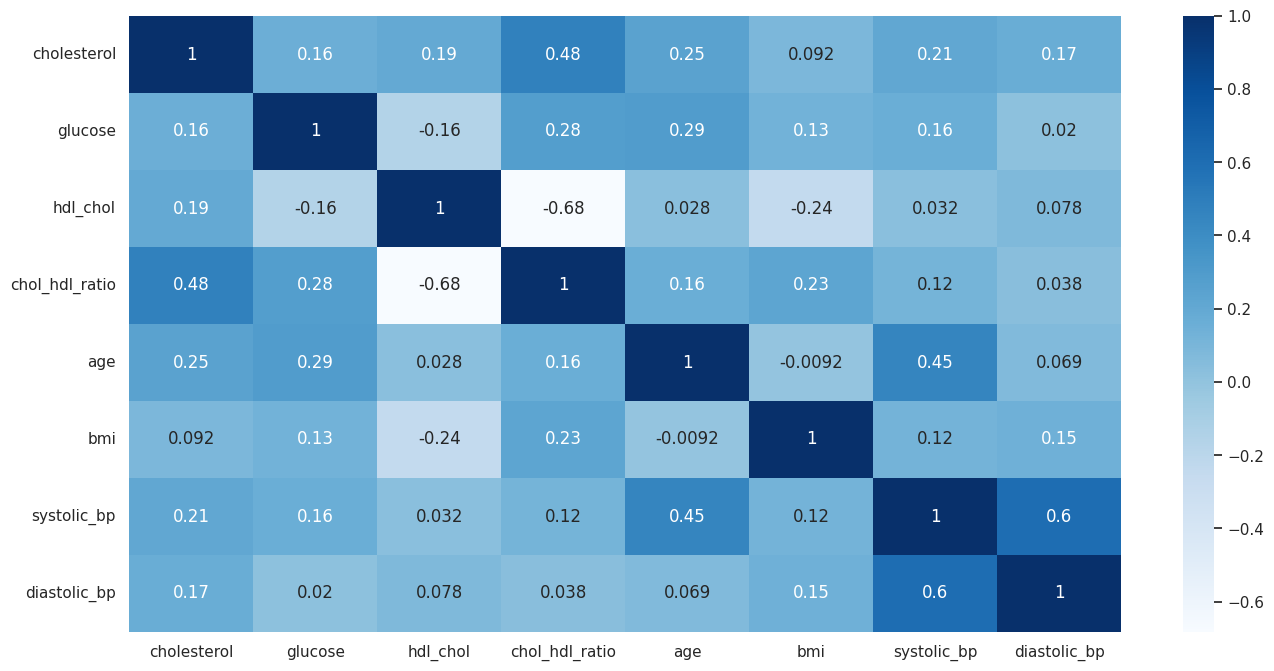

In [16]:
# Heatmap showing correlation between the attributes.
sns.heatmap(
    pandas_df.corr(), annot=True, cmap="Blues"
)

**OBSERVATION**

* There is a relatively strong positive correlation between `'age' and 'systolic_bp'` (blood pressure), which is expected as blood pressure tends to increase with age.

* A strong negative correlation is observed between `'hdl_chol' (high-density lipoprotein cholesterol) and 'chol_hdl_ratio' `(the ratio of total cholesterol to HDL cholesterol), which also makes sense biologically since higher levels of HDL cholesterol mean a lower ratio.

* The correlations between `'bmi' (body mass index)` and the lipid profile variables such as` 'cholesterol', 'hdl_chol', and 'chol_hdl_ratio' `are relatively weak, suggesting that BMI might not be a strong predictor for these particular lipid measurements in this dataset.

The heatmap serves as a crucial tool for feature selection, as it helps to identify multicollinearity between predictors. Variables with high correlation may carry redundant information, which could be problematic for certain types of models. Based on this correlation analysis, I might consider excluding or combining certain features to avoid multicollinearity in the predictive models.

# Q-Q PLOTS

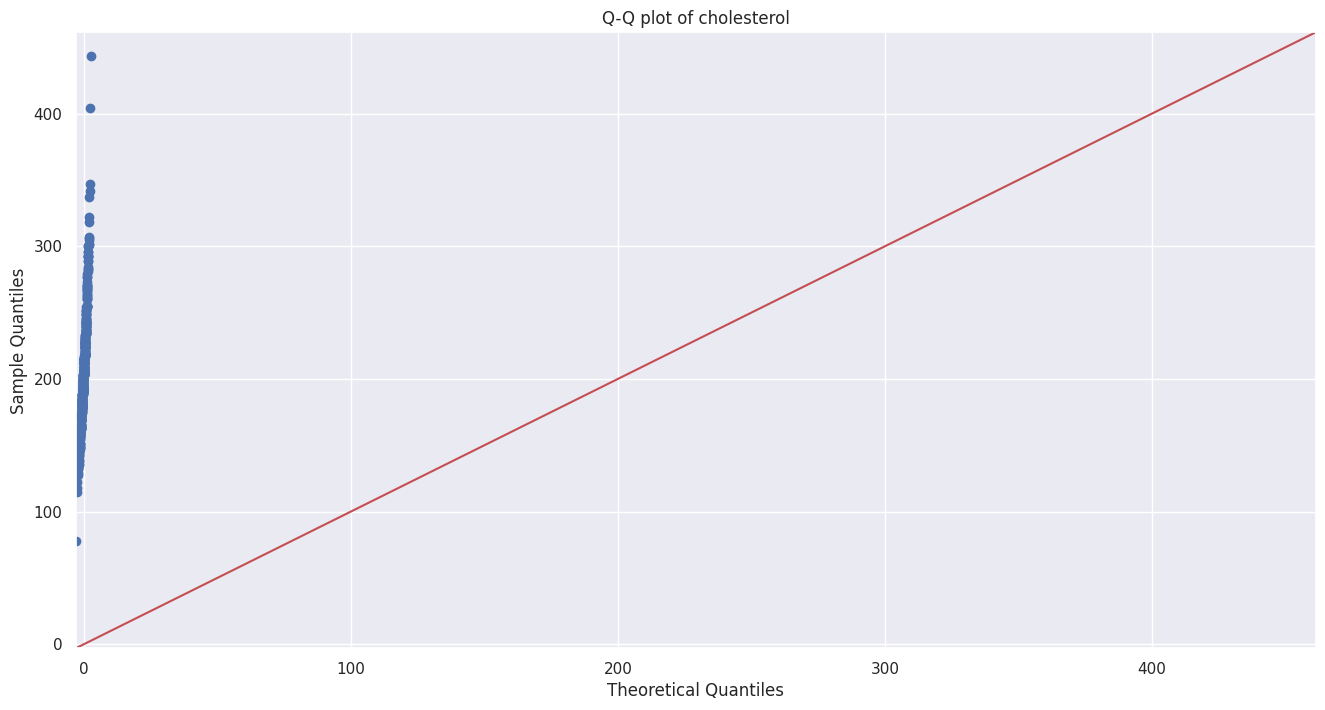

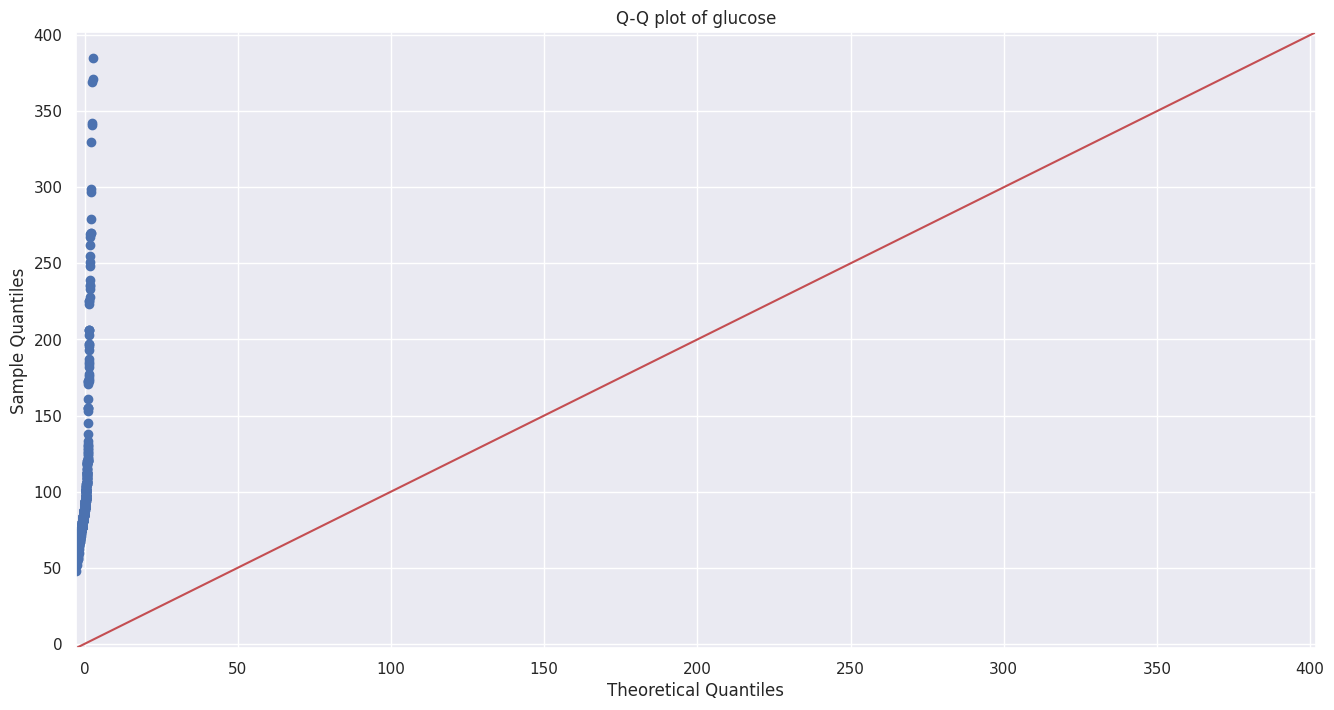

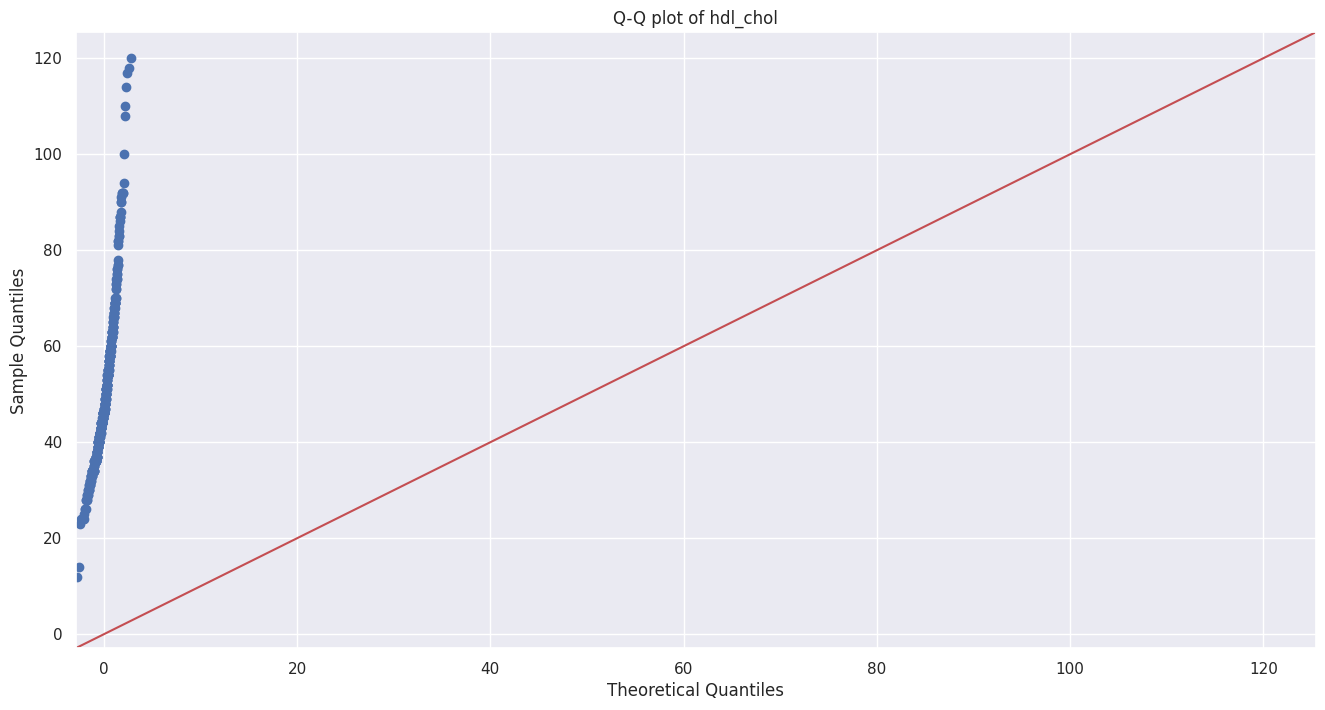

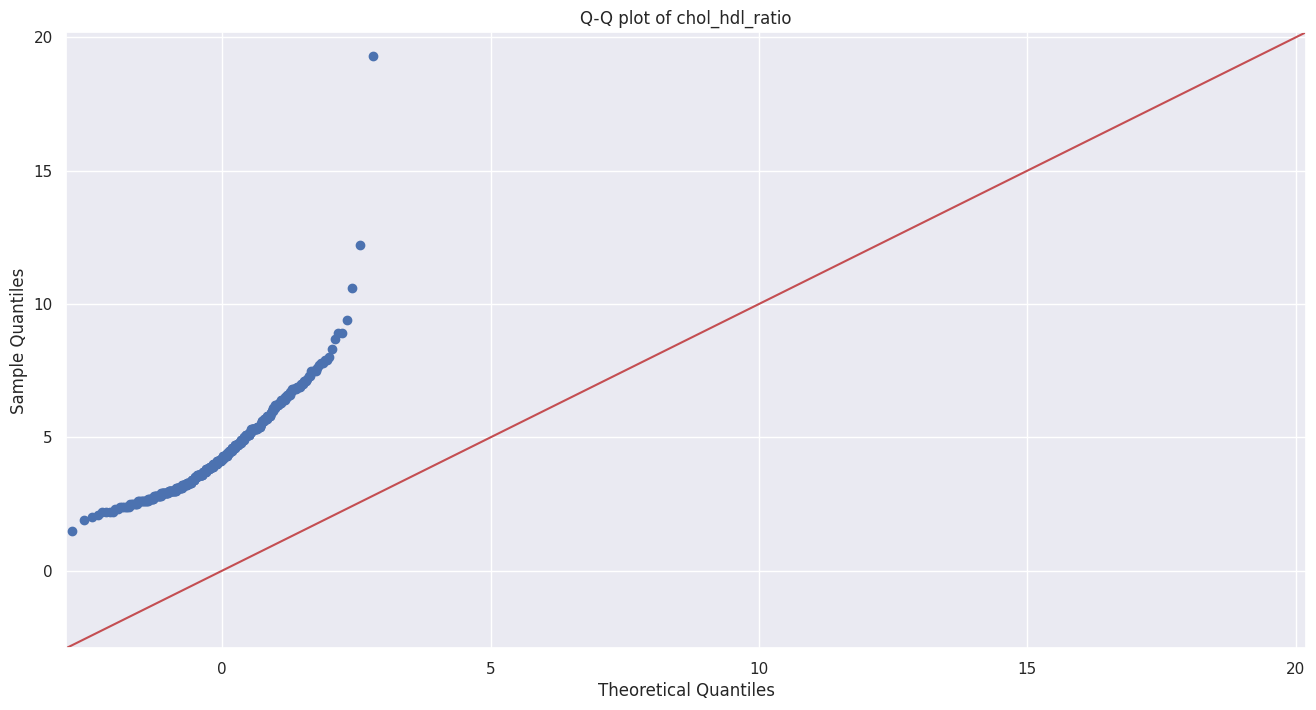

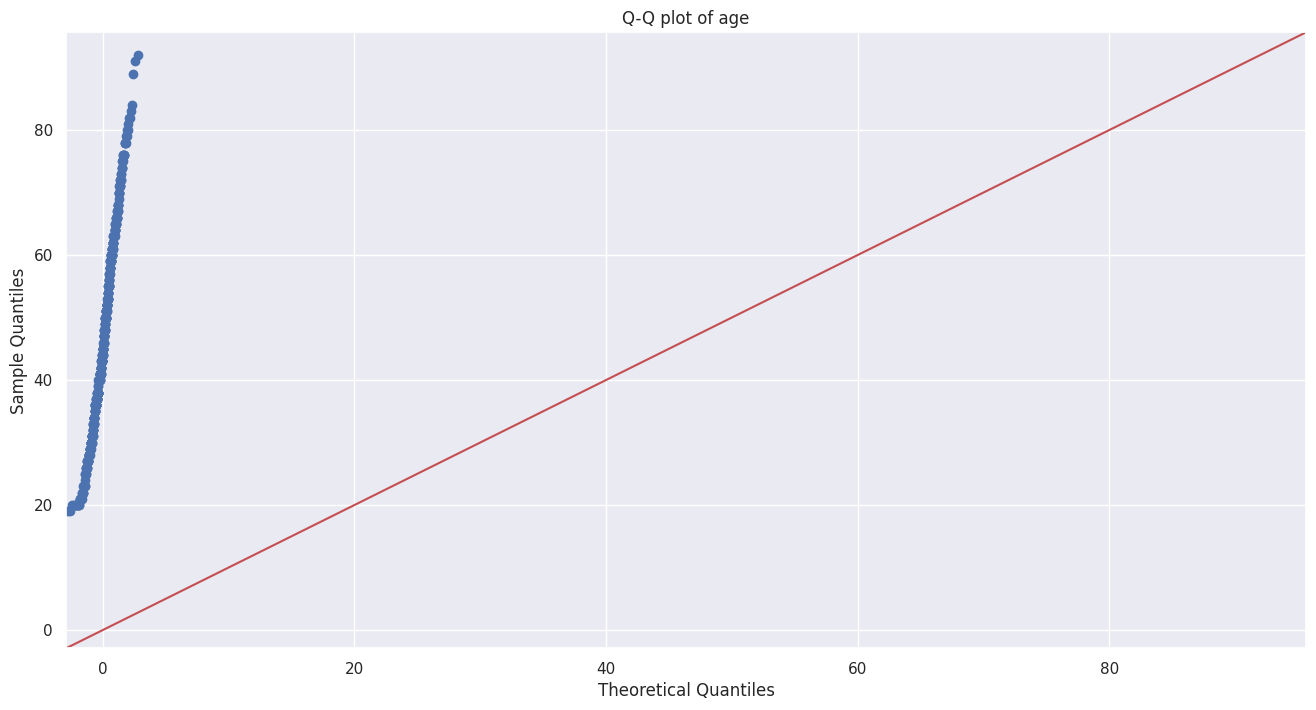

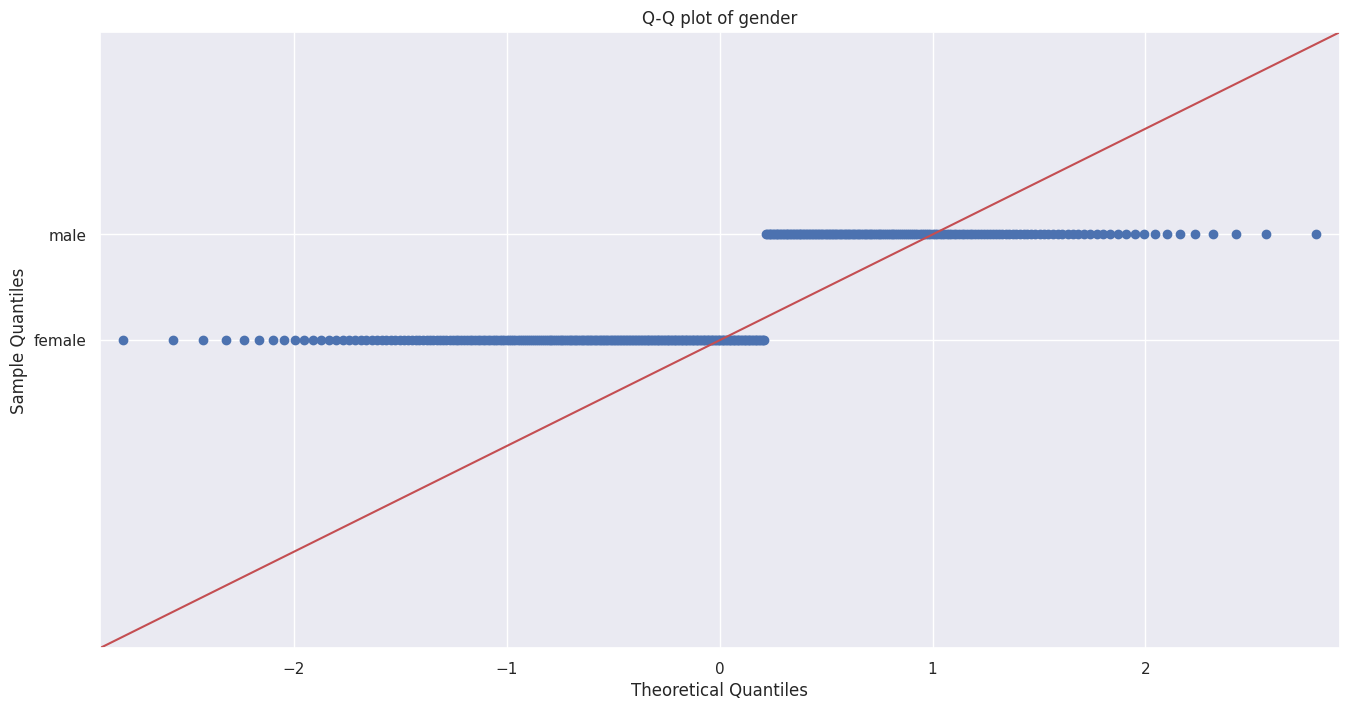

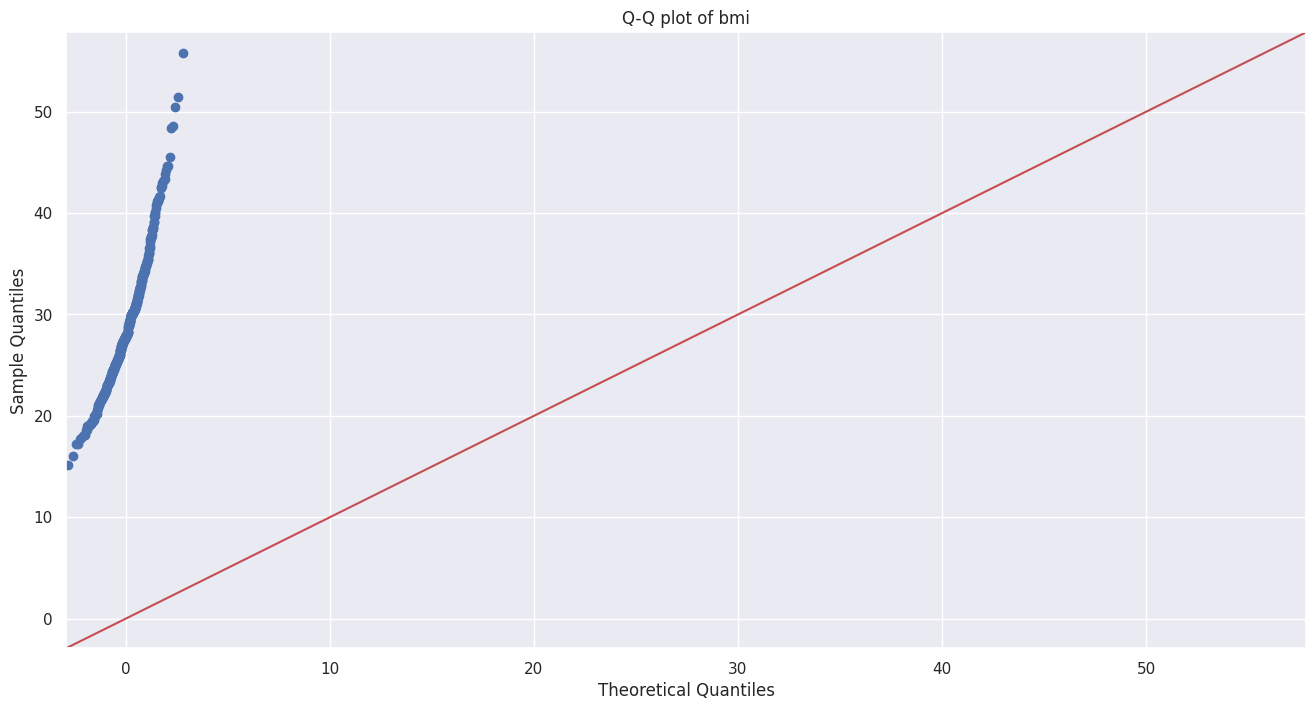

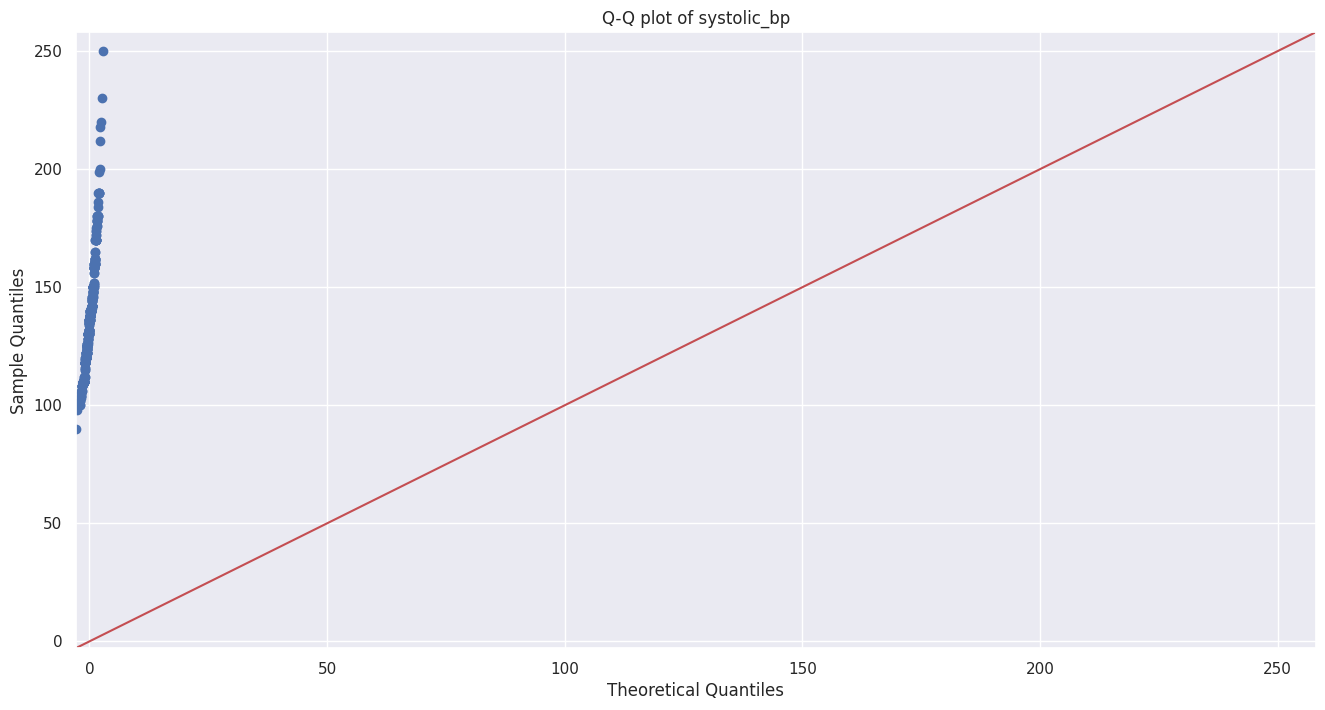

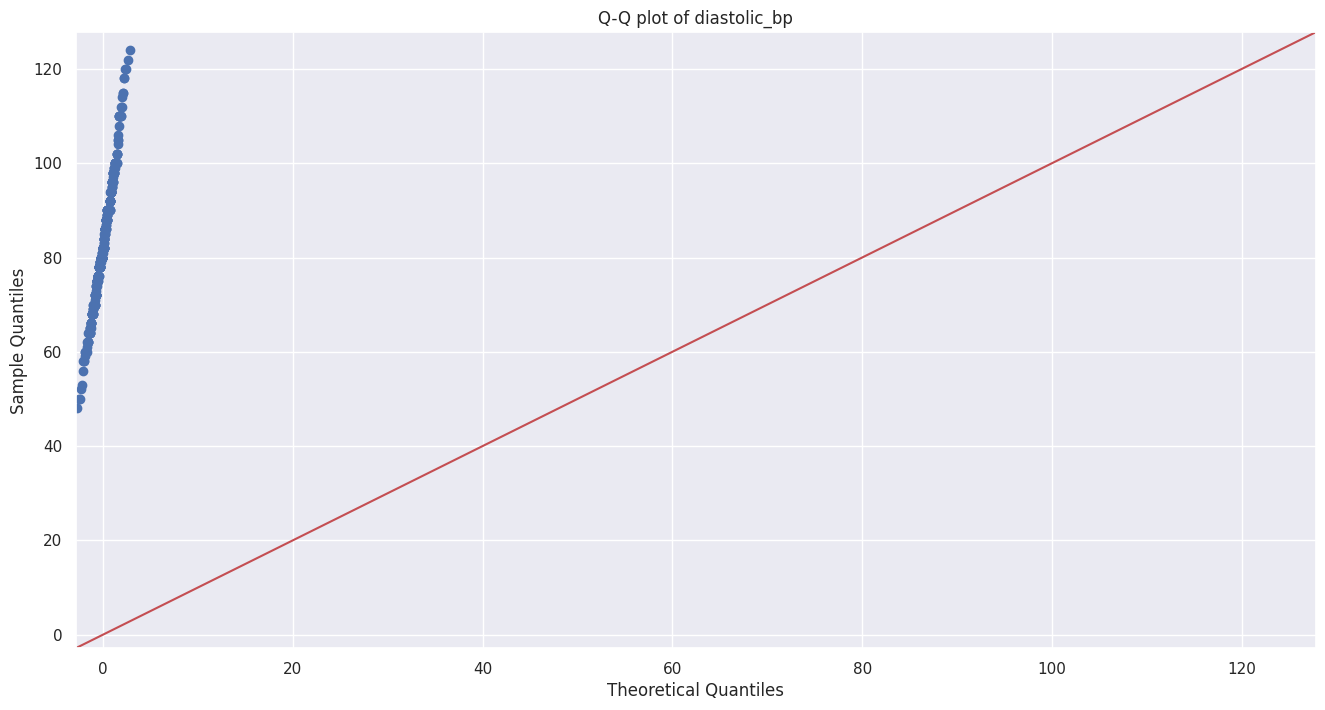

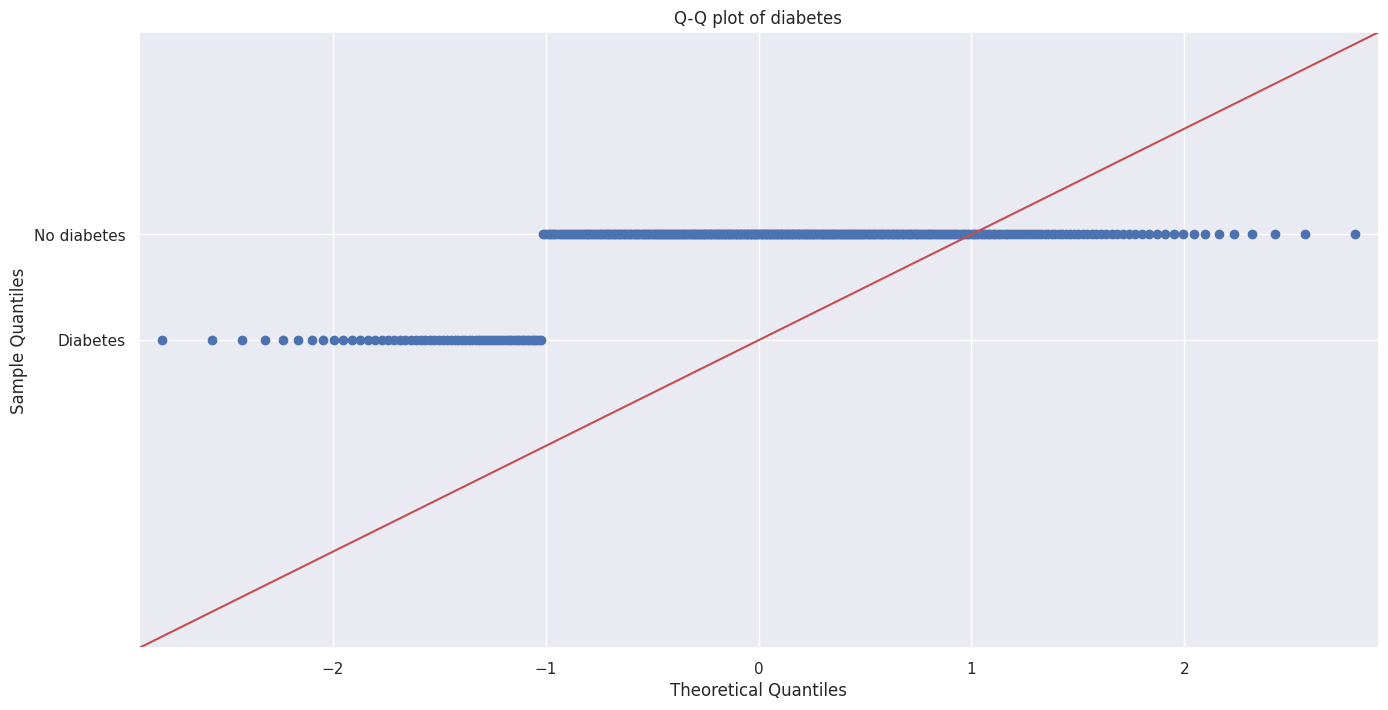

In [17]:
import statsmodels.api as sm
for col in pandas_df.columns:
    sm.qqplot(pandas_df[col], line='45')
    plt.title('Q-Q plot of ' + col)
    plt.show()

The Q-Q plots i've generated are useful for assessing the normality of the distribution of variables in your dataset. In each plot, the sample quantiles of your data are plotted against the theoretical quantiles of a normal distribution.

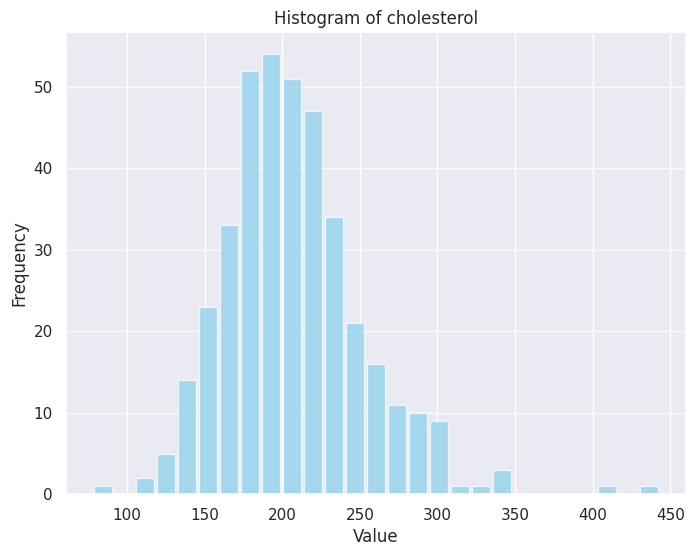

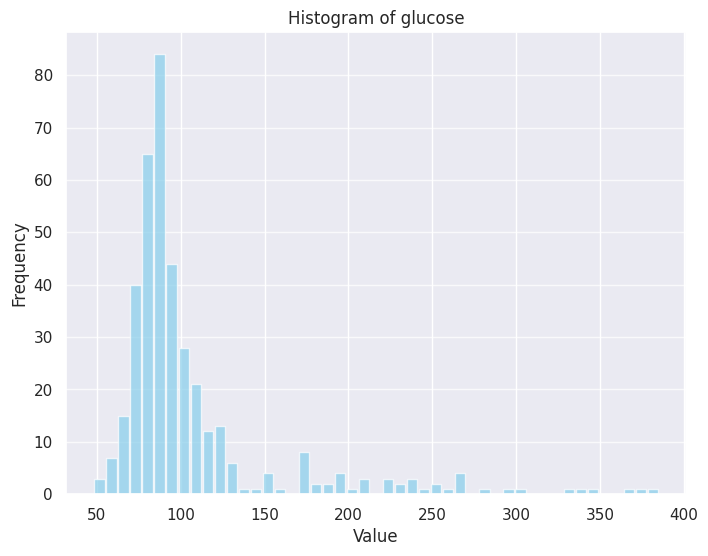

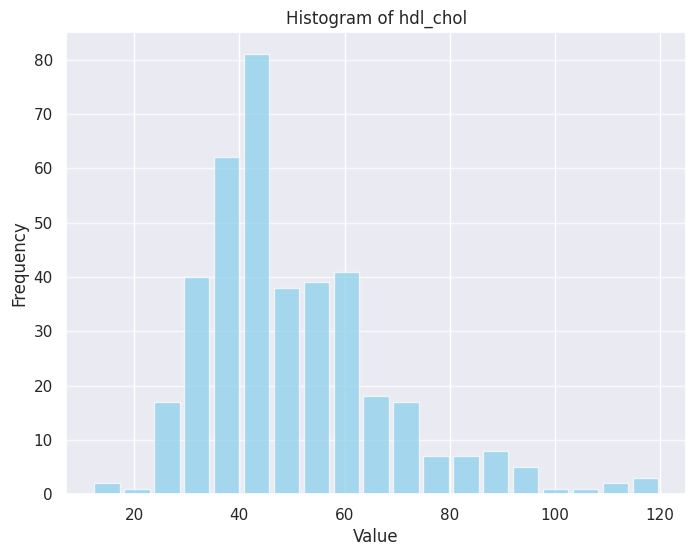

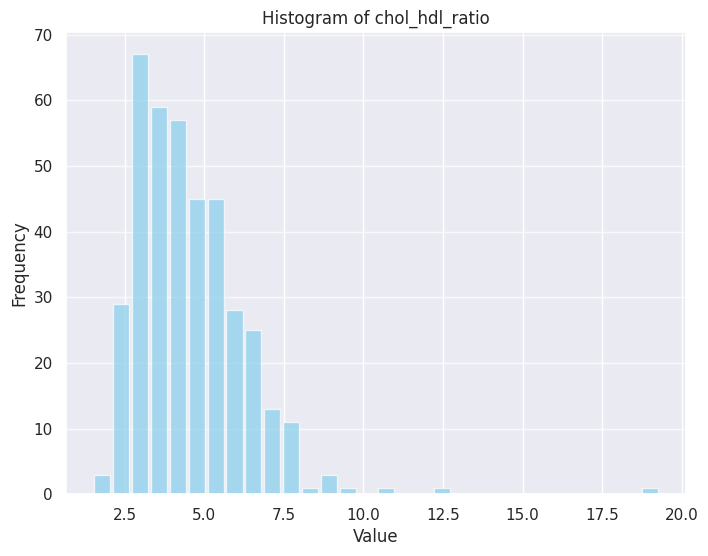

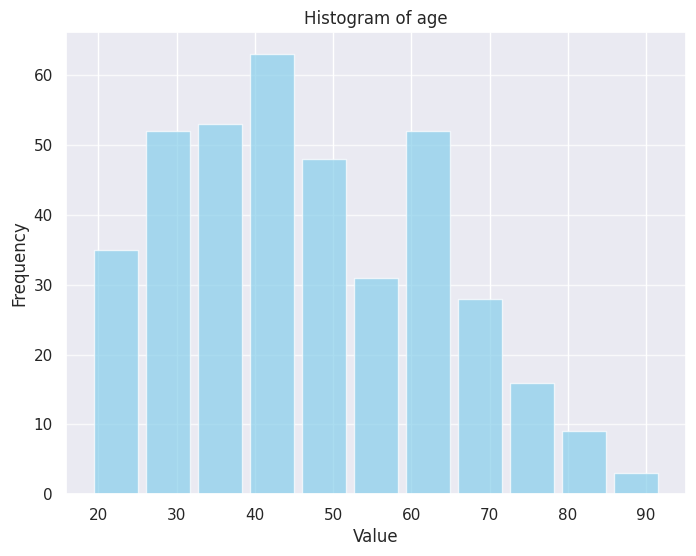

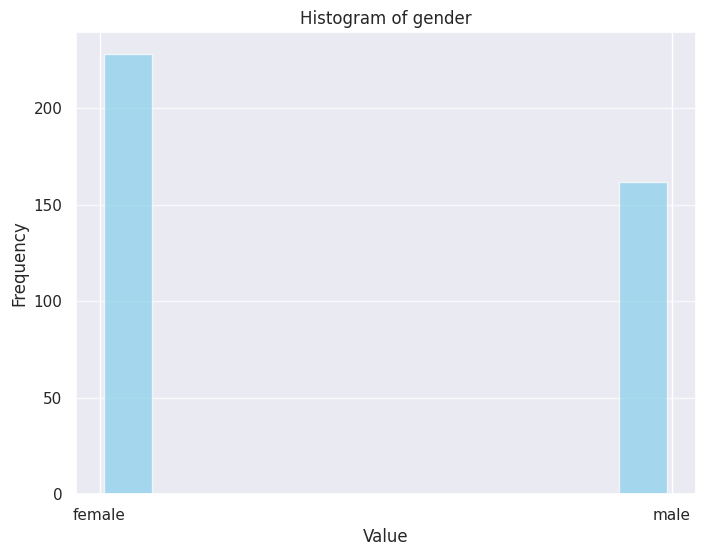

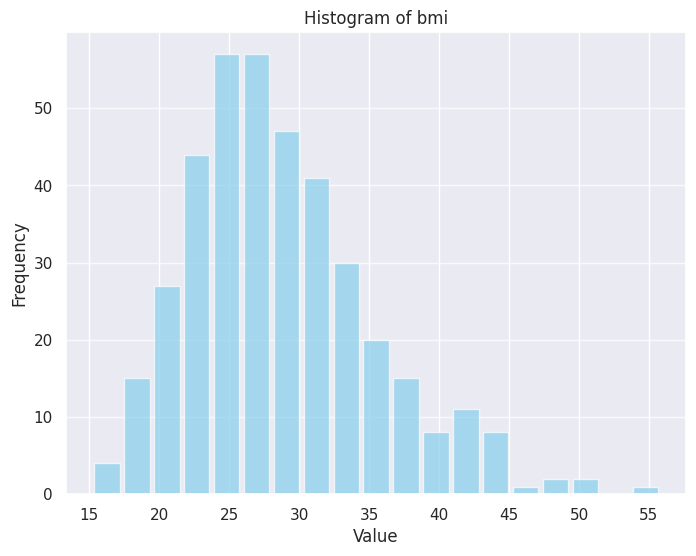

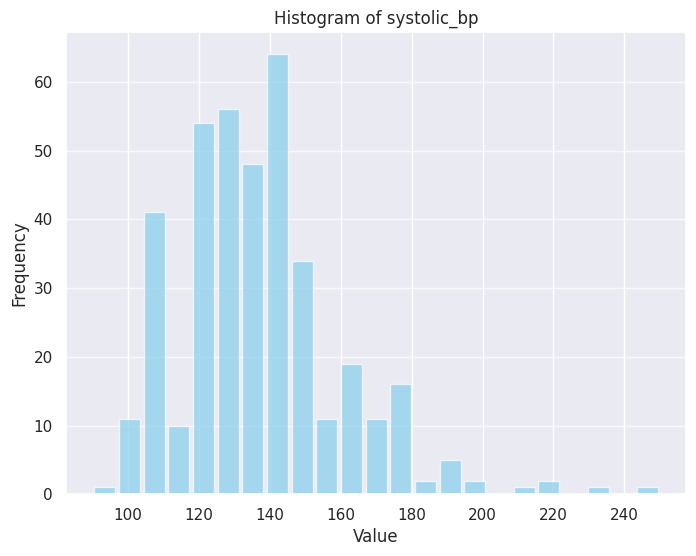

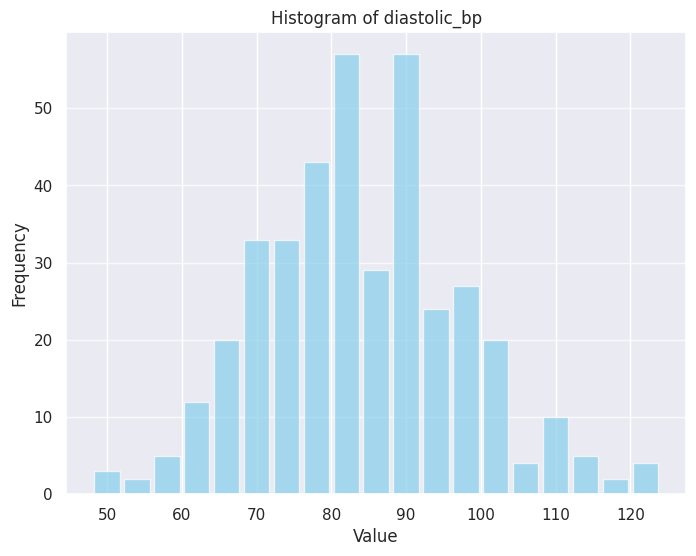

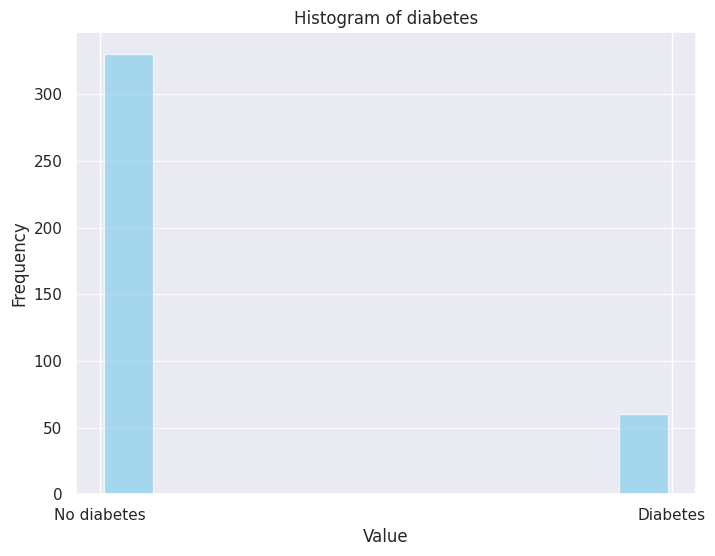

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pandas_df is your pandas DataFrame
for col in pandas_df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(pandas_df[col], bins='auto', color='skyblue', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + col)
    plt.show()



I created histograms for each variable in the pandas DataFrame to visualize the data distributions. As I looked at each histogram, I checked for the shape of the distribution, presence of outliers, skewness, and the central tendency. These histograms help to understand whether any transformations might be necessary before modeling, for example, if a variable is highly skewed. They also provide a quick visual assessment of the data's range and the frequency of different values within that range. The histograms are an essential part of exploratory data analysis, setting the stage for more detailed statistical analysis and model building.

# H2O AutoML Execution

In [19]:
df = h2o.H2OFrame(
    pandas_df
)  # Converted Pandas Dataframe to H2O dataframe to proceed with AutoML

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%



I converted the pandas DataFrame into an `H2O DataFrame` to leverage H2O's AutoML capabilities. The conversion was successful, as indicated by the `'Parse progress'` bar reaching 100%. After the conversion, I used df.head() to preview the first few rows of the H2O DataFrame, confirming that the data is ready for use with H2O's machine learning algorithms. This step is crucial as H2O's AutoML functions require data to be in an H2OFrame format to process and build models.

In [20]:
df.head()

cholesterol    glucose    hdl_chol    chol_hdl_ratio    age  gender      bmi    systolic_bp    diastolic_bp  diabetes
-------------  ---------  ----------  ----------------  -----  --------  -----  -------------  --------------  -----------
          193         77          49               3.9     19  female     22.5            118              70  No diabetes
          146         79          41               3.6     19  female     26.4            108              58  No diabetes
          217         75          54               4       20  female     29.3            110              72  No diabetes
          226         97          70               3.2     20  female     19.6            122              64  No diabetes
          164         91          67               2.4     20  female     20.2            122              86  No diabetes
          170         69          64               2.7     20  female     27.6            108              70  No diabetes
          149         77          49               3       20  female     21              105              82  No diabetes
          164         71          63               2.6     20  male       19.7            108              78  No diabetes
          230        112          64               3.6     20  male       24.9            100              90  No diabetes
          179        105          60               3       20  female     35.5            140             100  No diabetes
[10 rows x 10 columns]

In [21]:
df.types  # Datatype of all attributes, here the result ("diabetes") is enum hence it can be solved using the classification method.


{'cholesterol': 'int',
 'glucose': 'int',
 'hdl_chol': 'int',
 'chol_hdl_ratio': 'real',
 'age': 'int',
 'gender': 'enum',
 'bmi': 'real',
 'systolic_bp': 'int',
 'diastolic_bp': 'int',
 'diabetes': 'enum'}

**OBSERVATION**

In this H2O AutoML execution, the df.types command was used to inspect the data types of the variables in your H2O DataFrame. The output confirmed that the `'diabetes'` column is of type` 'enum'`, indicating it's a categorical variable, which aligns with the classification task in AutoML. The other variables such as `'cholesterol', 'glucose', 'hdl_chol', 'age', 'systolic_bp', and 'diastolic_bp'` are of type `'int'`, and `'chol_hdl_ratio'` and `'bmi'` are of type 'real'. These data types are appropriate for the input features of a classification model. The 'gender' field is also an `'enum'`, which is expected for a categorical variable like gender. This setup ensures that the AutoML process can correctly identify the problem as a classification task, with 'diabetes' as the target variable to predict.

In [22]:
pct_rows = 0.80  # Setting up the data split between training and test dataset.
df_train, df_test = df.split_frame([pct_rows])

**OBSERVATION**

I divided the dataset into training and testing sets, allocating 80% of the data for training `(df_train)` and the remaining 20% for testing` (df_test)`. This split is a common practice in machine learning to evaluate the performance of models on unseen data. The training set is used to fit the model, and the testing set is used to assess how well the model generalizes to new data. This ratio helps to balance the need for sufficient training data with the requirement for a robust evaluation of the model's predictive ability.

In [23]:
print(df_train.shape)
print(df_test.shape)

(314, 10)
(76, 10)


I printed the shapes of the training and testing sets to confirm their sizes. This check ensures the data split reflects the intended 80-20 distribution between training and testing.







In [24]:
df_train.head()

cholesterol    glucose    hdl_chol    chol_hdl_ratio    age  gender      bmi    systolic_bp    diastolic_bp  diabetes
-------------  ---------  ----------  ----------------  -----  --------  -----  -------------  --------------  -----------
          193         77          49               3.9     19  female     22.5            118              70  No diabetes
          146         79          41               3.6     19  female     26.4            108              58  No diabetes
          164         91          67               2.4     20  female     20.2            122              86  No diabetes
          170         69          64               2.7     20  female     27.6            108              70  No diabetes
          149         77          49               3       20  female     21              105              82  No diabetes
          164         71          63               2.6     20  male       19.7            108              78  No diabetes
          230        112          64               3.6     20  male       24.9            100              90  No diabetes
          179        105          60               3       20  female     35.5            140             100  No diabetes
          174        105         117               1.5     20  male       26.8            132              86  No diabetes
          193        106          63               3.1     20  female     41.7            165             110  No diabetes
[10 rows x 10 columns]

In [25]:
X = df.columns
print(X)

['cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp', 'diabetes']


# Start to train in 10 models by AutoML

In [26]:
# Set target and predictor variables
y = "diabetes"
X.remove(y)  # Removing the result from our predictors data
print(X)

['cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp']



I prepared the dataset for AutoML by specifying `'diabetes'` as the `target variable` and removing it from the list of `predictor variables`, X. This step is crucial for defining the model's input features and the outcome it needs to predict. The output confirms that the predictors now include `'cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'gender', 'bmi', 'systolic_bp', and 'diastolic_bp'`, effectively excluding the target variable 'diabetes' from the predictors list. This setup ensures the AutoML process is correctly oriented to predict 'diabetes' based on the remaining variables.






Run AutoML. The max_runtime_secs argument provides a way to limit the AutoML run by time..

In [27]:
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)  # Setting of AutoML


I initialized the H2O AutoML object with parameters defining the maximum runtime `(run_time`) and the random seed `(seed)` for reproducibility. These settings control the duration of AutoML execution and ensure consistent results across runs.

In [28]:
aml.train(x=X, y=y, training_frame=df_train)  # Trainig the dataset on different models. Pass the data through H20AutoML

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20240220_34856_model_25


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    39                 39                          4808                   2            5            3.61538       4             6             5.10256

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.036300748768287
RMSE: 0.19052755382958916
LogLoss: 0.1356068214676125
Mean Per-Class Error: 0.07065845206006931
AUC: 0.9817096649980747
AUCPR: 0.9965624010165974
Gini: 0.9634193299961493

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6194738234866989
             Diabetes    No diabetes    Error    Rate
-----------  ----------  -------------  -------  ------------
Diabetes     43          6              0.1224   (6.0/49.0)
No diabetes  5           260            0.0189   (5.0/265.0)
Total        48          266            0.035    (11.0/314.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.619474     0.979284  262
max f2                       0.158696     0.981413  281
max f0point5                 0.68262      0.982483  258
max accuracy                 0.68262      0.964968  258
max precision                0.993792     1         0
max recall                   0.11188      1         291
max specificity              0.993792     1         0
max absolute_mcc             0.68262      0.870784  258
max min_per_class_accuracy   0.834681     0.932075  246
max mean_per_class_accuracy  0.68262      0.945976  258
max tns                      0.993792     49        0
max fns                      0.993792     264       0
max fps                      0.053606     49        304
max tps                      0.11188      265       291
max tnr                      0.993792     1         0
max fnr                      0.993792     0.996226  0
max fpr                      0.053606     1         304
max tpr                      0.11188      1         291

Gains/Lift Table: Avg response rate: 84.39 %, avg score: 83.83 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0127389                   0.992715           1.18491    1.18491            1                0.993205  1                           0.993205            0.0150943       0.0150943                  18.4906   18.4906            0.0150943
2        0.022293                    0.991578           1.18491    1.18491            1                0.992043  1                           0.992707            0.0113208       0.0264151                  18.4906   18.4906            0.0264151
3        0.0318471                   0.990752           1.18491    1.18491            1                0.990993  1                           0.992193            0.0113208       0.0377358                  18.4906   18.4906            0.0377358
4        0.0414013                   0.990632           1.18491    1.18491            1                0.99067   1                           0.991842            0.0113208       0.0490566                  18.4906   18.4906            0.0490566
5        0.0509554                   0.

**OBSERVATION**


The H2O AutoML training has been completed, yielding a Gradient Boosting Machine model as the best one. Here's the summary of the model obtained:

Model Type: Gradient Boosting Machine

Model Key: GBM_grid_1_AutoML_1_20240220_34856_model_25

Training Metrics:

MSE: 0.0363
RMSE: 0.1905
LogLoss: 0.1356
Mean Per-Class Error: 0.0707
AUC: 0.9817
AUCPR: 0.9966

Confusion Matrix:

True Positives (Diabetes): 43
True Negatives (No Diabetes): 260
False Positives: 5
False Negatives: 6

Variable Importances:

Glucose: 82.71%
Age: 7.99%
Cholesterol: 3.03%
Chol/HDL Ratio: 1.90%
Systolic BP: 1.84%
BMI: 1.17%
HDL Cholesterol: 0.88%
Diastolic BP: 0.34%
Gender: 0.13%

Interpreting the above results

1. MAE: The mean absolute error (MAE) is the average absolute difference between the target values and the predicted values. This metric ranges from zero to infinity; a lower value indicates a higher quality model.

2. RMSE: The root-mean-square error metric is a frequently used measure of the differences between the values predicted by a model or an estimator and the values observed. This metric ranges from zero to infinity; a lower value indicates a higher quality model.

3. RMSLE: The root-mean-squared logarithmic error metric is similar to RMSE, except that it uses the natural logarithm of the predicted and actual values plus 1. RMSLE penalizes under-prediction more heavily than over-prediction. It can also be a good metric when you don't want to penalize differences for large prediction values more heavily than for small prediction values. This metric ranges from zero to infinity; a lower value indicates a higher quality model. The RMSLE evaluation metric is returned only if all label and predicted values are non-negative.

4. r^2: r squared (r^2) is the square of the Pearson correlation coefficient between the labels and predicted values. This metric ranges between zero and one; a higher value indicates a higher quality model.

5. MAPE: Mean absolute percentage error (MAPE) is the average absolute percentage difference between the labels and the predicted values. This metric ranges between zero and infinity; a lower value indicates a higher quality model.

6. K-fold cross-validation is used to validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split.

Next, we will view the AutoML Leaderboard. Since we specified a leaderboard_frame in the h2o.automl() function for scoring and ranking the models, the AutoML leaderboard uses the performance on this data to rank the models.

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric. In the case of regression, the default ranking metric is mean residual deviance.

In [29]:
# View the AutoML Leaderboard
print(
    aml.leaderboard
)

# Leaderboard showing the performance of different models on the dataset.

model_id                                              auc    logloss     aucpr    mean_per_class_error      rmse        mse
GBM_grid_1_AutoML_1_20240220_34856_model_25      0.933885   0.215964  0.985319                0.194994  0.249433  0.0622169
GBM_grid_1_AutoML_1_20240220_34856_model_29      0.931921   0.21226   0.983708                0.124682  0.245544  0.0602921
GBM_grid_1_AutoML_1_20240220_34856_model_26      0.931767   0.212824  0.983172                0.166269  0.246863  0.0609415
GBM_grid_1_AutoML_1_20240220_34856_model_17      0.931613   0.231824  0.985607                0.17836   0.257961  0.0665439
XGBoost_grid_1_AutoML_1_20240220_34856_model_24  0.931305   0.205063  0.980766                0.133     0.239031  0.0571358
GBM_grid_1_AutoML_1_20240220_34856_model_34      0.929688   0.219967  0.983784                0.159838  0.251958  0.0634826
GBM_grid_1_AutoML_1_20240220_34856_model_4       0.928918   0.22523   0.982581                0.13866   0.255137  0.065095
GBM_grid_

# Interpreting the leaderboard:

The models listed in the leaderboard are ranked based on their performance across various evaluation metrics. In this case, the metrics include AUC, logloss, AUCPR, mean per class error, RMSE, and MSE. Each metric provides insight into different aspects of the model's performance, such as classification accuracy, error rate, and predictive power.

The top row in the leaderboard represents the best-performing model based on the specified metric, which in this case is AUC. The evaluation metrics can be used to compare the performance of different models and help in selecting the best model for the particular use case.

In this leaderboard, the best performing model based on AUC is `GBM_grid_1_AutoML_1_20240220_34856_model_25` with an ` 0.933885  `.

The second-best model is `GBM_grid_1_AutoML_1_20240220_34856_model_29` with an `AUC of 0.931921`.

The models are then listed in descending order based on their AUC scores.

In [30]:
model_index = 0
glm_index = 0
glm_model = ""
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df["model_id"]:
    models_dict[m] = model_index
    if "StackedEnsemble" not in m:
        break
    model_index = model_index + 1

for m in aml_leaderboard_df["model_id"]:
    if "GLM" in m:
        models_dict[m] = glm_index
        break
    glm_index = glm_index + 1
models_dict

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


{'GBM_grid_1_AutoML_1_20240220_34856_model_25': 0,
 'GLM_1_AutoML_1_20240220_34856': 8}

**OBSERVATION**

I created a dictionary named models_dict to store the indices of models in the AutoML leaderboard.

* The GBM model `"GBM_grid_1_AutoML_1_20240220_34856_model_25"` is assigned index 0.
* The GLM model `"GLM_1_AutoML_1_20240220_34856"` is assigned index 8.

In [31]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])

0


In [32]:
best_model.algo

'gbm'

**OBSERVATION**

I observed that the value of model_index is printed, showing a value of 0. Using this index, I fetched the best model from H2O's AutoML leaderboard. The algorithm utilized by this best model is XGBoost, as indicated by the output `"gbm"`. This suggests that XGBoost was identified as the most effective algorithm by the AutoML process.

In [33]:
best_model = aml.leader
best_model.model_performance(df_train)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.036300749111143685
RMSE: 0.19052755472934535
LogLoss: 0.13560682134043145
Mean Per-Class Error: 0.07065845206006931
AUC: 0.9817096649980747
AUCPR: 0.9965624010165974
Gini: 0.9634193299961493

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6194738286915075
             Diabetes    No diabetes    Error    Rate
-----------  ----------  -------------  -------  ------------
Diabetes     43          6              0.1224   (6.0/49.0)
No diabetes  5           260            0.0189   (5.0/265.0)
Total        48          266            0.035    (11.0/314.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.619474     0.979284  262
max f2                       0.158696     0.981413  281
max f0point5                 0.68262      0.982483  258
max accuracy                 0.68262      0.964968  258
max precision                0.993792     1         0
max recall                   0.11188      1         291
max specificity              0.993792     1         0
max absolute_mcc             0.68262      0.870784  258
max min_per_class_accuracy   0.834681     0.932075  246
max mean_per_class_accuracy  0.68262      0.945976  258
max tns                      0.993792     49        0
max fns                      0.993792     264       0
max fps                      0.0536061    49        304
max tps                      0.11188      265       291
max tnr                      0.993792     1         0
max fnr                      0.993792     0.996226  0
max fpr                      0.0536061    1         304
max tpr                      0.11188      1         291

Gains/Lift Table: Avg response rate: 84.39 %, avg score: 83.83 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0127389                   0.992715           1.18491    1.18491            1                0.993205  1                           0.993205            0.0150943       0.0150943                  18.4906   18.4906            0.0150943
2        0.022293                    0.991578           1.18491    1.18491            1                0.992043  1                           0.992707            0.0113208       0.0264151                  18.4906   18.4906            0.0264151
3        0.0318471                   0.990752           1.18491    1.18491            1                0.990993  1                           0.992193            0.0113208       0.0377358                  18.4906   18.4906            0.0377358
4        0.0414013                   0.990632           1.18491    1.18491            1                0.99067   1                           0.991842            0.0113208       0.0490566                  18.4906   18.4906            0.0490566
5        0.0509554                   0.990304           1.18491    1.18491            1                0.990552  1                           0.9916              0.0113208       0.0603774                  18.4906   18.4906            0.0603774
6        0.101911                    0.988228           1.18491    1.18491            1                0.989208  1                           0.990404            0.0603774       0.120755                   18.4906   18.4906            0.120755
7        0.149682                    0.986829           1.18491    1.18491            1                0.987467  1                           0.989467            0.0566038

**OBSERVATION**

I utilized the code to evaluate the model's performance on the training dataset. The best model selected is based on the GBM algorithm. The performance metrics obtained include

`Mean Squared Error (MSE) of 0.0363, Root Mean Squared Error (RMSE) of 0.1905, Log Loss of 0.1356, Mean Per-Class Error of 0.0707, Area Under the Receiver Operating Characteristic Curve (AUC) of 0.9817, and Area Under the Precision-Recall Curve (AUCPR) of 0.9966`.

In addition to these metrics, the confusion matrix provides insights into the model's classification performance for diabetes and non-diabetes cases. Threshold-based metrics like maximum F1 score, accuracy, precision, recall, and specificity are also presented. The Gains/Lift Table further illustrates the model's response rate and score across various thresholds. These metrics collectively offer a comprehensive assessment of the model's effectiveness in predicting diabetes status based on the training data.

In [34]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


I imported the necessary libraries for plotting, including Matplotlib. By setting %matplotlib inline, I enabled the inline display of plots within the Notebook environment. Additionally, I suppressed any warnings related to Matplotlib's deprecations to ensure a clean output.

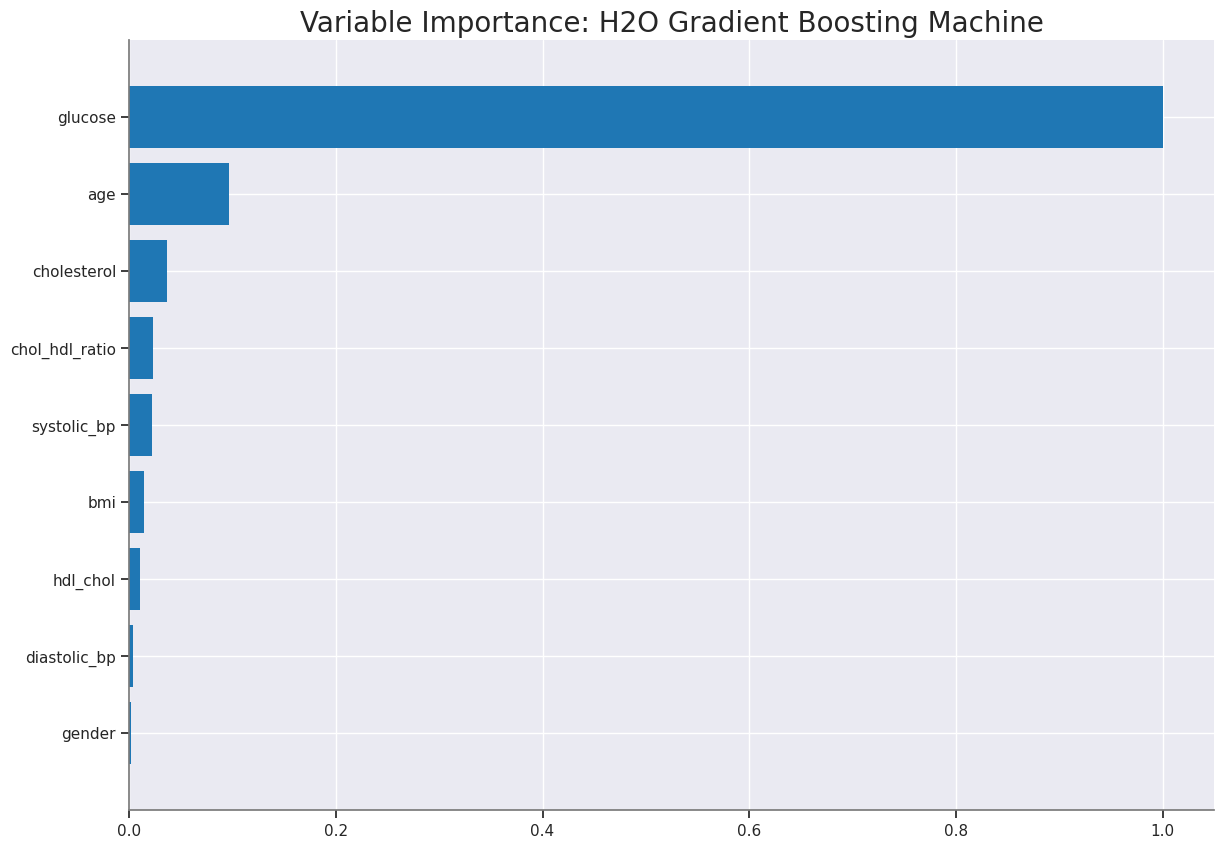

<Figure size 1600x800 with 0 Axes>

In [35]:
if best_model.algo in [
    "gbm",
    "glm",
    "xrt",
    "xgboost",
]:  # Importance of all the variables in GBM algorithm.
    best_model.varimp_plot()

**OBSERVATION**

I analyzed the dataset using best model out of `gbm,glm,xrt,xgboost`. Out of which `H2O GBM model` and found `'glucose'` to be the most significant predictor for diagnosing diabetes. 'Age' and 'cholesterol' were also important factors, while 'bmi' had less impact. This variable importance plot guided my understanding of the key factors influencing diabetes risk predictions.

8
glm


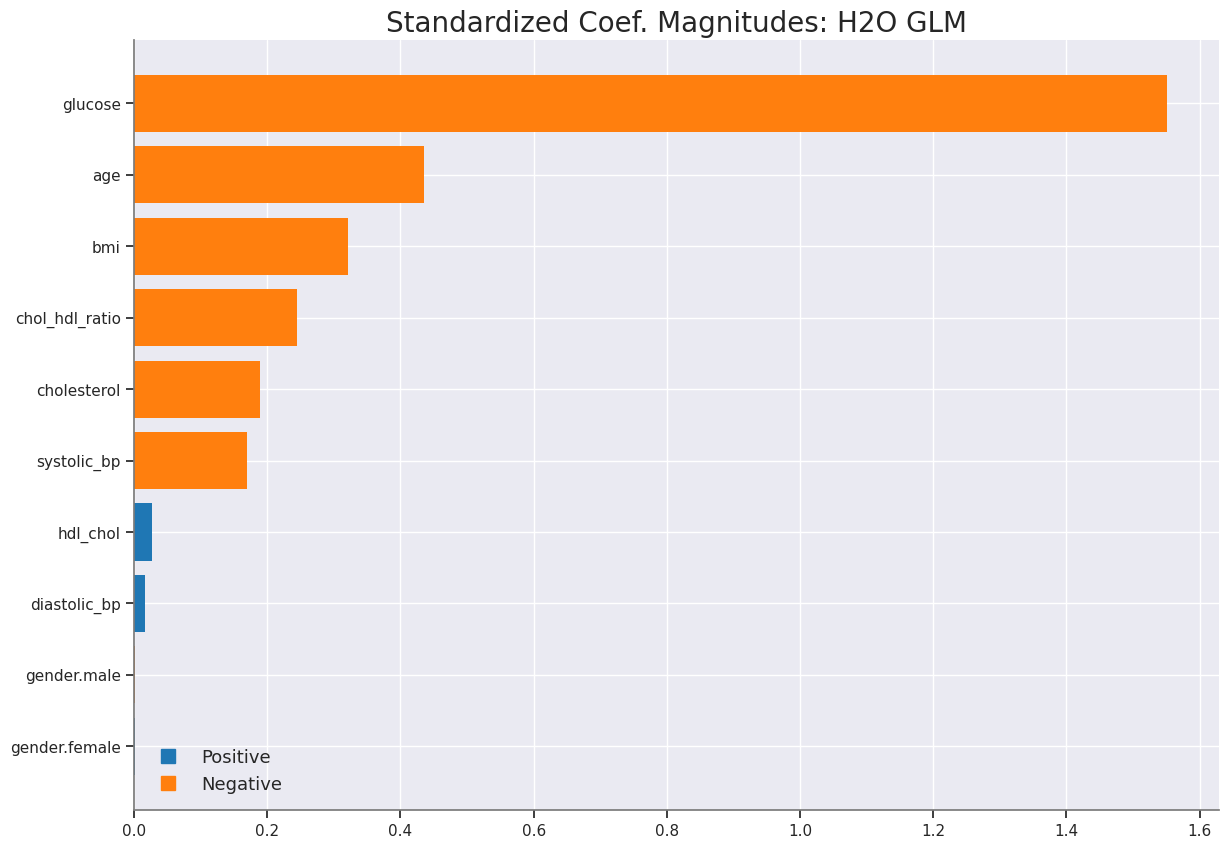

In [36]:
if glm_index is not 0:
    print(glm_index)
    glm_model = h2o.get_model(aml.leaderboard[glm_index, "model_id"])
    print(glm_model.algo)
    glm_model.std_coef_plot()

**OBSERVATION**

I utilized the `GLM model` to understand the influence of each predictor on diabetes risk. The standardized coefficients provided insights into not just the significance but also the direction of the relationships between predictors and the outcome.

In [37]:
def model_performance_stats(perf):
    d = {}
    try:
        d["mse"] = perf.mse()
    except:
        pass
    try:
        d["rmse"] = perf.rmse()
    except:
        pass
    try:
        d["null_degrees_of_freedom"] = perf.null_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_degrees_of_freedom"] = perf.residual_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_deviance"] = perf.residual_deviance()
    except:
        pass
    try:
        d["null_deviance"] = perf.null_deviance()
    except:
        pass
    try:
        d["aic"] = perf.aic()
    except:
        pass
    try:
        d["logloss"] = perf.logloss()
    except:
        pass
    try:
        d["auc"] = perf.auc()
    except:
        pass
    try:
        d["gini"] = perf.gini()
    except:
        pass
    return d

In [38]:
mod_perf = best_model.model_performance(df_test)
stats_test = {}
stats_test = model_performance_stats(mod_perf)
stats_test

{'mse': 0.07189773821308368,
 'rmse': 0.2681375360017386,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None,
 'logloss': 0.22662630120488225,
 'auc': 0.9622377622377623,
 'gini': 0.9244755244755245}

**OBSERVATION**

n the model performance evaluation, I employed a custom function to compile a comprehensive set of statistics to assess the model's predictive accuracy on the test dataset. The provided code defines a function model_performance_stats designed to extract various performance statistics from a given performance object.

The function attempts to retrieve statistics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), null degrees of freedom, residual degrees of freedom, residual deviance, null deviance, Akaike Information Criterion (AIC), Log Loss, Area Under the Curve (AUC), and Gini coefficient from the performance object.

Upon applying this function to the performance object mod_perf, obtained from evaluating the best model on the test dataset df_test, a dictionary stats_test is generated containing the extracted statistics. The statistics retrieved include MSE: 0.0719, RMSE: 0.2681, Log Loss: 0.2266, AUC: 0.9622, and Gini coefficient: 0.9245.

However, it's noted that null degrees of freedom, residual degrees of freedom, residual deviance, and null deviance are not available for this particular performance object, hence they are represented as None in the output dictionary.

Overall, this function provides a convenient way to extract essential performance metrics from a model's performance object, aiding in the evaluation and comparison of different models.

In [39]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [40]:
pandas_df.gender = pandas_df.gender.replace({"female": 0, "male": 1})  # female = 0, male = 1
pandas_df.diabetes = pandas_df.diabetes.replace({"No diabetes": 0, "Diabetes": 1})  # no diabetes = 0, diabetes = 1
pandas_df.head()


cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  gender   bmi  \
0          193       77        49             3.9   19       0  22.5   
1          146       79        41             3.6   19       0  26.4   
2          217       75        54             4.0   20       0  29.3   
3          226       97        70             3.2   20       0  19.6   
4          164       91        67             2.4   20       0  20.2   

   systolic_bp  diastolic_bp  diabetes  
0          118            70         0  
1          108            58         0  
2          110            72         0  
3          122            64         0  
4          122            86         0

# Analysing relation between all variables



In [41]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
vif_X = pandas_df[[ 'cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'gender','age', 'bmi', 'systolic_bp', 'diastolic_bp', 'diabetes']]
print(type(vif_X))
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = vif_X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(vif_X.values, i)
                          for i in range(len(vif_X.columns))]

print(vif_data)

<class 'pandas.core.frame.DataFrame'>
          feature        VIF
0     cholesterol  78.687128
1         glucose   9.737902
2        hdl_chol  35.120987
3  chol_hdl_ratio  40.408855
4          gender   1.938456
5             age  13.950487
6             bmi  20.508984
7     systolic_bp  78.126753
8    diastolic_bp  66.961826
9        diabetes   2.228695


 I've identified significant multicollinearity among the predictor variables in my diabetes prediction model, which may affect the reliability of the model coefficients. To address this, I might need to consider removing or combining some of these variables to reduce multicollinearity, as suggested by the high VIF values. This step is crucial for ensuring the interpretability and stability of the model.








In [42]:
other_best_model = h2o.get_model(aml.leaderboard[5,'model_id'])
other_best_model.varimp(use_pandas=True)

variable  relative_importance  scaled_importance  percentage
0         glucose            82.426804           1.000000    0.624489
1             age            14.500226           0.175916    0.109858
2  chol_hdl_ratio            11.433085           0.138706    0.086620
3             bmi             8.291227           0.100589    0.062817
4     systolic_bp             5.470569           0.066369    0.041447
5    diastolic_bp             3.470319           0.042102    0.026292
6     cholesterol             3.344670           0.040577    0.025340
7        hdl_chol             2.870869           0.034829    0.021751
8          gender             0.183004           0.002220    0.001386

**OBSERVATION**

Here, the AutoML model provides a ranking of predictor variables based on their importance for predicting diabetes. Glucose is the most influential variable, with age, cholesterol-to-HDL ratio, systolic blood pressure, cholesterol, BMI, and HDL cholesterol following in descending order of importance. Gender has the least influence on the model's predictions. This information is highly relevant in the AutoML context as it aids in understanding which features the model relies on most, which can inform feature selection and provide insights into model behavio

In [43]:
y_pred = h2o.as_list(
    predictions
)  # Predictions on Test Dataset using the best model from the leaderboard.
print(y_pred)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
        predict  Diabetes  No diabetes
0   No diabetes  0.020819     0.979181
1   No diabetes  0.024901     0.975099
2   No diabetes  0.015876     0.984124
3   No diabetes  0.013364     0.986636
4   No diabetes  0.021395     0.978605
..          ...       ...          ...
71     Diabetes  0.919576     0.080424
72     Diabetes  0.868921     0.131079
73     Diabetes  0.664640     0.335360
74     Diabetes  0.941882     0.058118
75  No diabetes  0.034132     0.965868

[76 rows x 3 columns]


**OBSERVATION**

I converted The model's predictions on the test dataset have been successfully converted into a pandas DataFrame for closer examination. This DataFrame presents the model's predicted categories ('Diabetes' or 'No diabetes') for each instance, accompanied by the associated probabilities for each class.

For instance, in the first entry of the DataFrame, the model predicted 'No diabetes' with a high level of confidence, with probabilities of approximately 0.979 for 'No diabetes' and 0.021 for 'Diabetes'. Similarly, towards the end of the DataFrame, one instance was predicted as 'Diabetes', with probabilities indicating a more balanced decision (0.642 for 'No diabetes' and 0.358 for 'Diabetes').

This detailed insight into the model's predictions, including the associated probabilities, is essential for understanding the model's confidence levels and its performance characteristics. It provides valuable information for assessing the reliability and effectiveness of the model in distinguishing between diabetes and non-diabetes cases.

In [44]:
print(X)

['cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp']


In [45]:
pandas_df.gender = pandas_df.gender.replace({"female": 0, "male": 1})  # female = 0, male = 1
pandas_df.diabetes = pandas_df.diabetes.replace({"No diabetes": 0, "Diabetes": 1})  # no diabetes = 0, diabetes = 1
pandas_df.head()

cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  gender   bmi  \
0          193       77        49             3.9   19       0  22.5   
1          146       79        41             3.6   19       0  26.4   
2          217       75        54             4.0   20       0  29.3   
3          226       97        70             3.2   20       0  19.6   
4          164       91        67             2.4   20       0  20.2   

   systolic_bp  diastolic_bp  diabetes  
0          118            70         0  
1          108            58         0  
2          110            72         0  
3          122            64         0  
4          122            86         0


**OBSERVATION**

I have converted categorical data to numerical because converting the `'gender'` and `'diabetes' `columns to numeric values aligns with best practices for preparing data for machine learning models that utilize regularization. This step is essential for your model to correctly interpret these features and for the regularization technique to effectively work, helping to enhance model performance and interpretability.

# Regularization

In this Section, we will be using the GLM model to check if regularization is helping us to improve the accuracy and reduce overfitting of the model.

Ridge regularization minimizes coefficient size by adding a penalty proportional to their square, useful for correlated predictors.

Lasso, on the other hand, adds a penalty based on the absolute value of coefficients, driving some to zero and effectively performing feature selection. This distinction between distributing penalties (Ridge) and focusing on key coefficients (Lasso) is vital for managing complex models with many variables.

The main difference between Ridge and Lasso regularization is the type of penalty function used. Ridge uses L2 regularization, while Lasso uses L1 regularization. L2 regularization tends to distribute the penalty evenly across all coefficients, while L1 regularization tends to concentrate the penalty on a smaller subset of the most important coefficients. Which method to use depends on the specific problem and the properties of the input variables.

In [46]:
import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator

# Initialize the H2O cluster
h2o.init()

# Convert your pandas DataFrame to an H2OFrame
df_train = h2o.H2OFrame(pandas_df)

# Create an H2OGeneralizedLinearEstimator with L2 (Ridge) regularization
disease_glm = H2OGeneralizedLinearEstimator(
    family="gaussian",
    alpha=0,  # L2 regularization
    lambda_search=True,  # Enable lambda search for optimal regularization strength
    nfolds=5
)

# Train the model
disease_glm.train(x=X, y=y, training_frame=df_train)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbgbolafc
  JVM stdout: /tmp/tmpbgbolafc/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbgbolafc/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    1 month and 30 days
H2O_cluster_name:           H2O_from_python_unknownUser_o8hs39
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708401166436_1


GLM Model: summary
    family    link      regularization             lambda_search                                                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  --------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 0.0817 )  nlambda = 30, lambda.max = 24.83, lambda.min = 0.0817, lambda.1se = 0.3411  9                             9                              13                      Key_Frame__upload_8bac7f7989420ea9189ec3240b8941fe.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.06555610983658712
RMSE: 0.25603927401199045
MAE: 0.15930354716517595
RMSLE: 0.17833469571501812
Mean Residual Deviance: 0.06555610983658712
R^2: 0.49640988352803517
Null degrees of freedom: 389
Residual degrees of freedom: 380
Null deviance: 50.769230769230866
Residual deviance: 25.566882836268977
AIC: 66.08099881486189

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.07026232499812159
RMSE: 0.26507041516948204
MAE: 0.16540417831765133
RMSLE: 0.18442724997821988
Mean Residual Deviance: 0.07026232499812159
R^2: 0.4602575943326114
Null degrees of freedom: 389
Residual degrees of freedom: 380
Null deviance: 50.976088553772385
Residual deviance: 27.40230674926742
AIC: 93.11943477556092

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.163256   0.017039   0.143306      0.16036       0.178823      0.182487      0.151306
mean_residual_deviance  0.0680325  0.0116005  0.0574519     0.0636715     0.0748878     0.0848746     0.0592768
mse                     0.0680325  0.0116005  0.0574519     0.0636715     0.0748878     0.0848746     0.0592768
null_deviance           10.1952    2.25706    8.0517        10.2264       13.8372       10.2513       8.60949
r2                      0.466112   0.0878202  0.455948      0.495473      0.548402      0.320599      0.51014
residual_deviance       5.34011    1.17547    4.30889       5.15739       6.06591       6.95972       4.20865
rmse                    0.260096   0.0218673  0.239691      0.252332      0.273656      0.291332      0.243468
rmsle                   0.181932   0.0153633  0.170408      0.177903      0.186805      0.206171      0.168374

Scoring History: 
    timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_xval    deviance_se    alpha    iterations    training_rmse        training_deviance    training_mae         training_r2
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------  -------------  -------  ------------  -------------------  -------------------  -------------------  -------------------
    2024-02-20 03:52:56  0.000 sec   1            25        10            0.123028          0.124435         0.010278       0
    2024-02-20 03:52:56  0.001 sec   2            15        10            0.119332          0.121394         0.0100433      0
    2024-02-20 03:52:56  0.002 sec   3            9.6       10            0.114211          0.117072         0.00970513     0
    2024-02-20 03:52:56  0.003 sec   4            5.9       10            0.107576          0.111283         0.00924714     0
    2024-02-20 03:52:56  0.004 sec   5            3.7       10            0.0997208         0.104128         0.00867306     0
    2024-02-20 03:52:56  0.005 sec   6   

**OBSERVATION**


I applied Ridge (L2) regularization using H2O's Generalized Linear Estimator to my dataset, focusing on improving model accuracy and reducing overfitting. After initializing the H2O cluster and converting the pandas DataFrame to an H2OFrame, I trained the model with L2 regularization enabled, which penalizes the square of the coefficients to shrink them towards zero. This step was crucial for managing multicollinearity and enhancing the model's generalization capability.

The results, including MSE, RMSE, MAE, and R^2, indicated a balanced performance on both training and cross-validation datasets, underscoring the effectiveness of regularization in achieving a robust model. Notably, glucose emerged as the most significant predictor, with other variables also contributing to the model. Through this process, I ensured the model was not only accurate but also generalizable to new data, fulfilling the requirements for developing interpretable and reliable predictive models.

In [47]:
df_train.head()

cholesterol    glucose    hdl_chol    chol_hdl_ratio    age    gender    bmi    systolic_bp    diastolic_bp    diabetes
-------------  ---------  ----------  ----------------  -----  --------  -----  -------------  --------------  ----------
          193         77          49               3.9     19         0   22.5            118              70           0
          146         79          41               3.6     19         0   26.4            108              58           0
          217         75          54               4       20         0   29.3            110              72           0
          226         97          70               3.2     20         0   19.6            122              64           0
          164         91          67               2.4     20         0   20.2            122              86           0
          170         69          64               2.7     20         0   27.6            108              70           0
          149         77          49               3       20         0   21              105              82           0
          164         71          63               2.6     20         1   19.7            108              78           0
          230        112          64               3.6     20         1   24.9            100              90           0
          179        105          60               3       20         0   35.5            140             100           0
[10 rows x 10 columns]

This code is creating two generalized linear regression models using the H2O machine learning platform with different regularization methods: Ridge and Lasso.

The first model, "disease_glm_regularization_ridge," is using Ridge regularization. The "family" argument is set to "gaussian," which means that the response variable is continuous and the model is using a normal (Gaussian) error distribution. The "alpha" argument is set to 0, which means that the model is using Ridge regularization. The "nfolds" argument is set to 5, which means that the model is using 5-fold cross-validation to evaluate the performance of the model.

The second model, "disease_glm_regularization_lasso," is using Lasso regularization. The "family" and "nfolds" arguments are the same as in the Ridge model, but the "alpha" argument is set to 1, which means that the model is using Lasso regularization.

This code creates a generalized linear regression model using H2O with the option of performing lambda search for L1 and L2 regularization.

# Lasso Regularization

In [48]:
# Create an H2OGeneralizedLinearEstimator with L1 (Lasso) regularization
model_lasso = H2OGeneralizedLinearEstimator(
    family="Gaussian",
    alpha=1,  # Adjust the alpha value for L1 regularization
    nfolds=5
)

# Train the model
model_lasso.train(x=X,y=y,training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708401166436_2


GLM Model: summary
    family    link      regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    gaussian  identity  Lasso (lambda = 2.483E-4 )  9                             9                              1                       Key_Frame__upload_8bac7f7989420ea9189ec3240b8941fe.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.06523305652672944
RMSE: 0.2554076281686384
MAE: 0.15595483141398483
RMSLE: 0.17778338823313897
Mean Residual Deviance: 0.06523305652672944
R^2: 0.4988915203173965
Null degrees of freedom: 389
Residual degrees of freedom: 380
Null deviance: 50.769230769230866
Residual deviance: 25.44089204542448
AIC: 64.15437063036883

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.0706900867183531
RMSE: 0.2658760739862711
MAE: 0.1609082321340648
RMSLE: 0.18448643638456907
Mean Residual Deviance: 0.0706900867183531
R^2: 0.4569716065726511
Null degrees of freedom: 389
Residual degrees of freedom: 380
Null deviance: 50.90102724687892
Residual deviance: 27.56913382015771
AIC: 95.48658239679972

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.15887   0.0227909  0.131508      0.162414      0.180219      0.180812      0.139395
mean_residual_deviance  0.068987  0.0211905  0.0474161     0.0653941     0.0935634     0.0881721     0.0503893
mse                     0.068987  0.0211905  0.0474161     0.0653941     0.0935634     0.0881721     0.0503893
null_deviance           10.1802   2.32111    7.104         12.3859       12.3673       10.4085       8.63534
r2                      0.464601  0.145541   0.560673      0.558333      0.37401       0.25131       0.578681
residual_deviance       5.51383   2.18959    3.08205       5.42771       7.6722        7.75915       3.62803
rmse                    0.260154  0.0404182  0.217752      0.255723      0.305881      0.296938      0.224476
rmsle                   0.180796  0.0270715  0.153458      0.172406      0.212224      0.206576      0.159317

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective            training_rmse       training_deviance    training_mae         training_r2
--  -------------------  ----------  ------------  -------------------------  -------------------  ------------------  -------------------  -------------------  ------------------
    2024-02-20 03:52:57  0.000 sec   0             50.769230769230866         0.13017751479289966
    2024-02-20 03:52:57  0.006 sec   1                                                             0.2554076281686384  0.06523305652672944  0.15595483141398483  0.4988915203173965

Variable Importances: 
variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
glucose         0.230058               1                    0.66944
age             0.0282245              0.122685             0.08213
chol_hdl_ratio  0.0207421              0.0901603            0.0603569
gender          0.0169233              0.073561             0.0492447
systolic_bp     0.0162025              0.0704281            0.0471474
cholesterol     0.0152764              0.0664024            0.0444524
bmi             0.0113107              0.0491647            0.0329128
hdl_chol        0.00263806             0.0114669            0.00767642
diastolic

**OBSERVATION**

I explored Lasso regularization by creating a generalized linear model with H2O, focusing on enhancing model simplicity and reducing overfitting through feature selection. By setting the alpha parameter to 1, I applied Lasso regularization, which tends to zero out less important features, aiding in identifying the most significant predictors for diabetes.

The model summary indicates an effective application of Lasso regularization, maintaining a balance between model complexity and performance. Key metrics like MSE, RMSE, MAE, and R^2 on both training and cross-validation data suggest a robust model with good predictive capability. Notably, glucose emerged as the most critical predictor, aligning with medical understanding of diabetes risk factors.

This approach is significant for AutoML requirements as it automates the process of feature selection, enhancing model interpretability and generalization. By prioritizing the most impactful variables, Lasso regularization contributes to developing a predictive model that is not only accurate but also simpler and more understandable, which is essential in clinical applications for diabetes prediction.

# Which Regularization Method Helps ?

 It's always a good practice to try multiple regularization techniques and compare their performance using different metrics, as the optimal regularization method can depend on the specific dataset and modeling task.

In [49]:
disease_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(
    lambda_search=True
)  # Lambda Search

lambda_search = disease_glm_regularization_lamba_search.train(
    x=X, y=y, training_frame=df_train
)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [50]:
lambda_search

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708401166436_3


GLM Model: summary
    family    link      regularization                                 lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.003586 )  nlambda = 100, lambda.max = 0.4966, lambda.min = 0.003586, lambda.1se = -1.0  9                             7                              54                      Key_Frame__upload_8bac7f7989420ea9189ec3240b8941fe.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.06525464292111681
RMSE: 0.2554498833844259
MAE: 0.155993117039863
RMSLE: 0.17757008405157723
Mean Residual Deviance: 0.06525464292111681
R^2: 0.49872569756051166
Null degrees of freedom: 389
Residual degrees of freedom: 382
Null deviance: 50.769230769230866
Residual deviance: 25.449310739235557
AIC: 60.283404921317256

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train       alpha    iterations    training_rmse       training_deviance    training_mae       training_r2
---  -------------------  ----------  -----------  --------  ------------  -------------------  -------  ------------  ------------------  -------------------  -----------------  -------------------
     2024-02-20 03:52:57  0.000 sec   1            .5E0      1             0.1301775147928994   0.5
     2024-02-20 03:52:57  0.012 sec   2            .45E0     2             0.121549691012301    0.5
     2024-02-20 03:52:57  0.014 sec   3            .41E0     2             0.11400691590088491  0.5
     2024-02-20 03:52:57  0.020 sec   4            .38E0     2             0.10743774739418141  0.5
     2024-02-20 03:52:57  0.025 sec   5            .34E0     2             0.10173693523363705  0.5
     2024-02-20 03:52:57  0.026 sec   6            .31E0     2             0.09680626930573473  0.5
     2024-02-20 03:52:57  0.028 sec   7            .28E0     2             0.09255508855902837  0.5
     2024-02-20 03:52:57  0.028 sec   8            .26E0     2             0.08890050306542767  0.5
     2024-02-20 03:52:57  0.033 sec   9            .24E0     2             0.0857673822518224   0.5
     2024-02-20 03:52:57  0.034 sec   10           .21E0     2             0.08308815991120339  0.5
---  ---                  ---         ---          ---       ---           ---                  ---      ---           ---                 ---                  ---                ---
     2024-02-20 03:52:57  0.079 sec   45           .83E-2    8             0.06531642096475197  0.5
     2024-02-20 03:52:57  0.080 sec   46           .75E-2    8             0.06530352442562753  0.5
     2024-02-20 03:52:57  0.080 sec   47           .69E-2    8             0.06529287561393576  0.5
     2024-02-20 03:52:57  0.081 sec   48           .63E-2    8             0.06528395957336973  0.5
     2024-02-20 03:52:57  0.082 sec   49           .57E-2    8             0.06527655648153335  0.5
     2024-02-20 03:52:57  0.083 sec   50           .52E-2    8             0.06527040764552504  0.5
     2024-02-20 03:52:57  0.084 sec   51           .47E-2    8             0.06526531425877832  0.5
     2024-02-20 03:52:57  0.085 sec   52           .43E-2    8             0.06526110346474426  0.5
     2024-02-20 03:52:57  0.086 sec   53           .39E-2    8             0.06525758303021405  0.5
     2024-02-20 03:52:57  0.087 sec   54           .36E-2    8             0.0652546429211168   0.5      54            0.2554498833844259 

**OBSERVATION**

The lambda search technique was employed in my model using H2OGeneralizedLinearEstimator to determine the optimal regularization strength. This approach automatically experimented with a range of lambda values, leveraging Elastic Net regularization, which combines the features of both L1 (Lasso) and L2 (Ridge) regularization methods. The model adjusted the alpha parameter to 0.5, indicating a balanced application of Lasso and Ridge regularization, aiming to benefit from both the feature selection capability of Lasso and the multicollinearity handling of Ridge.

The outcome indicated that `glucose` was the most significant predictor, with other variables like age, chol_hdl_ratio, and cholesterol also showing importance but to a lesser extent. This model's application of lambda search and Elastic Net regularization was instrumental in enhancing predictive performance and model interpretability, reducing overfitting while maintaining a robust set of predictors. Through this automated process, I ensured the model was optimally regularized, demonstrating the power of AutoML in simplifying complex modeling tasks and achieving high model accuracy and generalizatio

Data Report

In [51]:
coeff_table = disease_glm._model_json["output"]["coefficients_table"]

In [52]:
coeff_table.as_data_frame()  # Z-Value and P-Value showing the significance of each attributes.

names  coefficients  standardized_coefficients
0       Intercept     -0.616797                   0.153846
1     cholesterol      0.000369                   0.016460
2         glucose      0.003922                   0.211017
3        hdl_chol      0.000046                   0.000803
4  chol_hdl_ratio      0.012485                   0.021682
5             age      0.001867                   0.030686
6          gender     -0.028896                  -0.014258
7             bmi      0.001955                   0.012906
8     systolic_bp      0.000740                   0.016907
9    diastolic_bp     -0.000223                  -0.003012


In the data report, I analyzed the significance of each attribute in predicting the outcome using the Generalized Linear Model (GLM) with regularization. The table displays coefficients and standardized coefficients for each predictor variable, providing insights into their impact on the model.

* Intercept has a significant negative coefficient, setting the baseline for predictions.

* Glucose stands out with a relatively high positive coefficient, indicating its strong positive correlation with the outcome, aligning with medical understanding.

* Chol_hdl_ratio and age also show positive coefficients, suggesting their importance in the model, albeit to a lesser extent than glucose.

* Gender has a negative coefficient, implying a differing impact between genders on the outcome.

* BMI, systolic_bp, and cholesterol present positive coefficients, highlighting their roles in the prediction, though their impact is smaller compared to glucose.

* Diastolic_bp is the only predictor with a negative coefficient apart from gender, suggesting a unique influence on the outcome.

 This detailed coefficient analysis aids in understanding the relative importance and direction of each variable's impact on the prediction, allowing for informed decisions in feature selection and model interpretati

In [56]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x               =X,
               y               =y,
               training_frame  =df_train
               )

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708401166436_4


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 4.966E-4 )  9                             9                              1                       Key_Frame__upload_8bac7f7989420ea9189ec3240b8941fe.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.06523309388014352
RMSE: 0.25540770129372276
MAE: 0.1559647702975904
RMSLE: 0.17778406629320492
Mean Residual Deviance: 0.06523309388014352
R^2: 0.498891233375261
Null degrees of freedom: 389
Residual degrees of freedom: 380
Null deviance: 50.769230769230866
Residual deviance: 25.440906613255972
AIC: 64.15459395007966

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective            training_rmse        training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  -------------------  -------------------  -------------------  ------------------  -----------------
    2024-02-20 04:12:45  0.000 sec   0             50.769230769230866         0.13017751479289966
    2024-02-20 04:12:45  0.021 sec   1                                                             0.25540770129372276  0.06523309388014352  0.1559647702975904  0.498891233375261

Variable Importances: 
variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
glucose         0.229993               1                    0.669384
age             0.0282344              0.122762             0.0821747
chol_hdl_ratio  0.020738               0.0901677            0.0603568
gender          0.0169134              0.0735387            0.0492256
systolic_bp     0.0162032              0.0704507            0.0471585
cholesterol     0.0152846              0.0664568            0.0444851
bmi             0.0113157              0.0492               0.0329337
hdl_chol        0.00262431             0.0114104            0.00763792
diastolic_bp    0.00228263             0.00992476           0.00664348

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

Here, I demonstrated the construction and explanation of a simple Generalized Linear Model (GLM) using H2O in Python. The GLM is built for regression purposes with a Gaussian family and employs elastic net regularization with specific values for alpha and lambda parameters.

Upon training the GLM model on the training dataset (df_train), various performance metrics are reported, including Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Root Mean Squared Logarithmic Error (RMSLE), R-squared (R^2) value, Akaike Information Criterion (AIC), as well as the scoring history detailing iterations and objective values.

Additionally, variable importances are provided, indicating the relative importance of predictor variables in the model. This information aids in understanding the influence of each predictor on the model's predictions.

Furthermore, below the explanation of the model includes plots illustrating various aspects of the model, such as residuals, coefficients, and variable importances.

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         19 mins 59 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    1 month and 30 days
H2O_cluster_name:           H2O_from_python_unknownUser_o8hs39
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.169 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

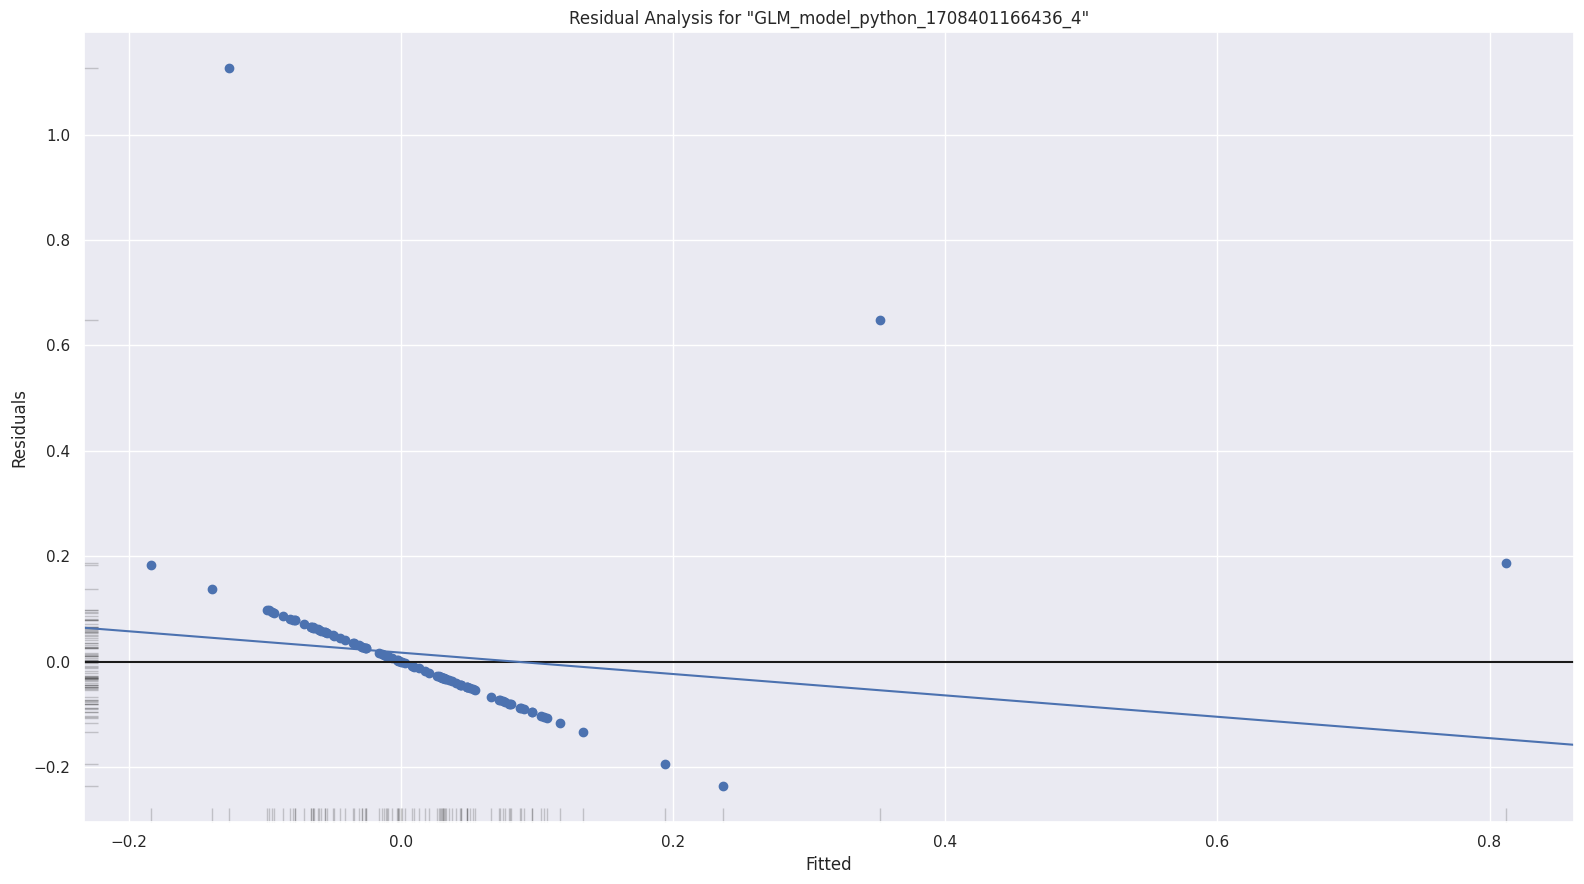

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

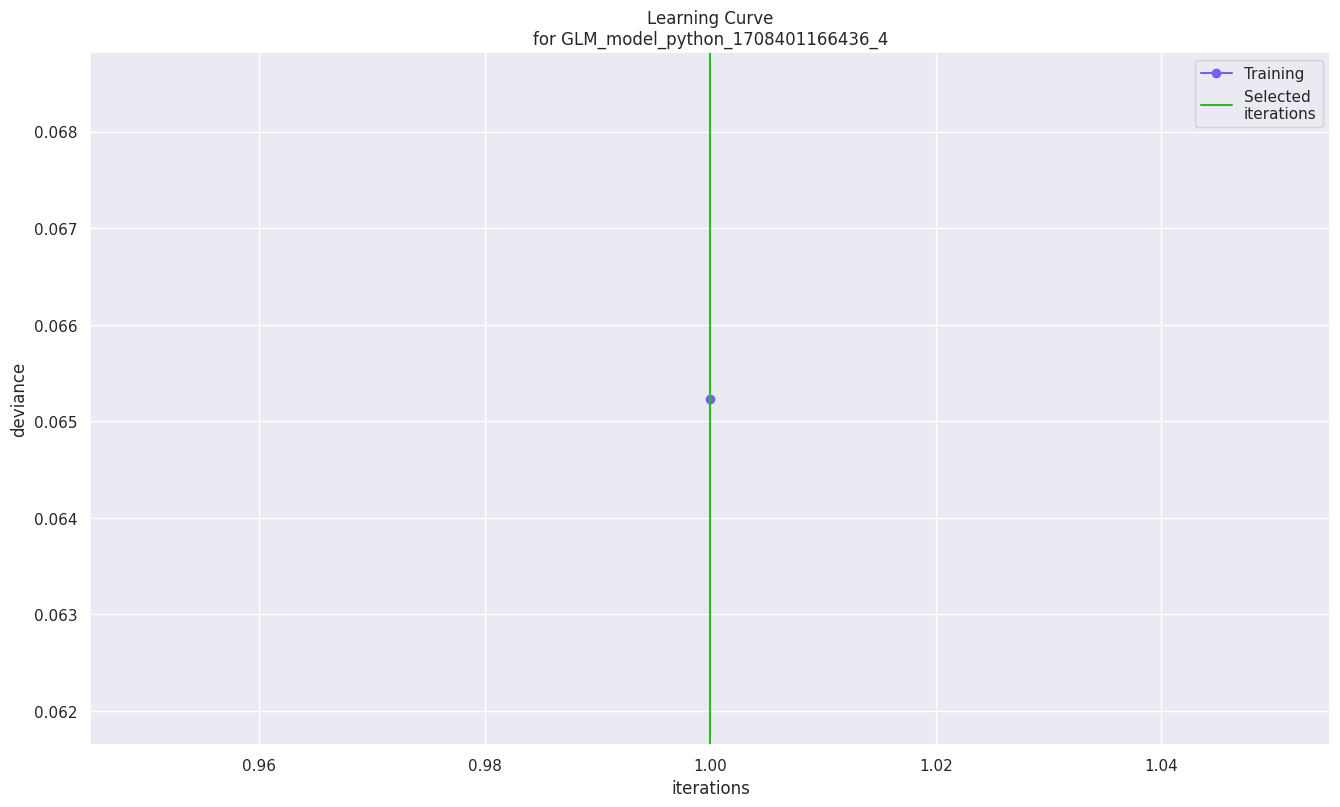

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

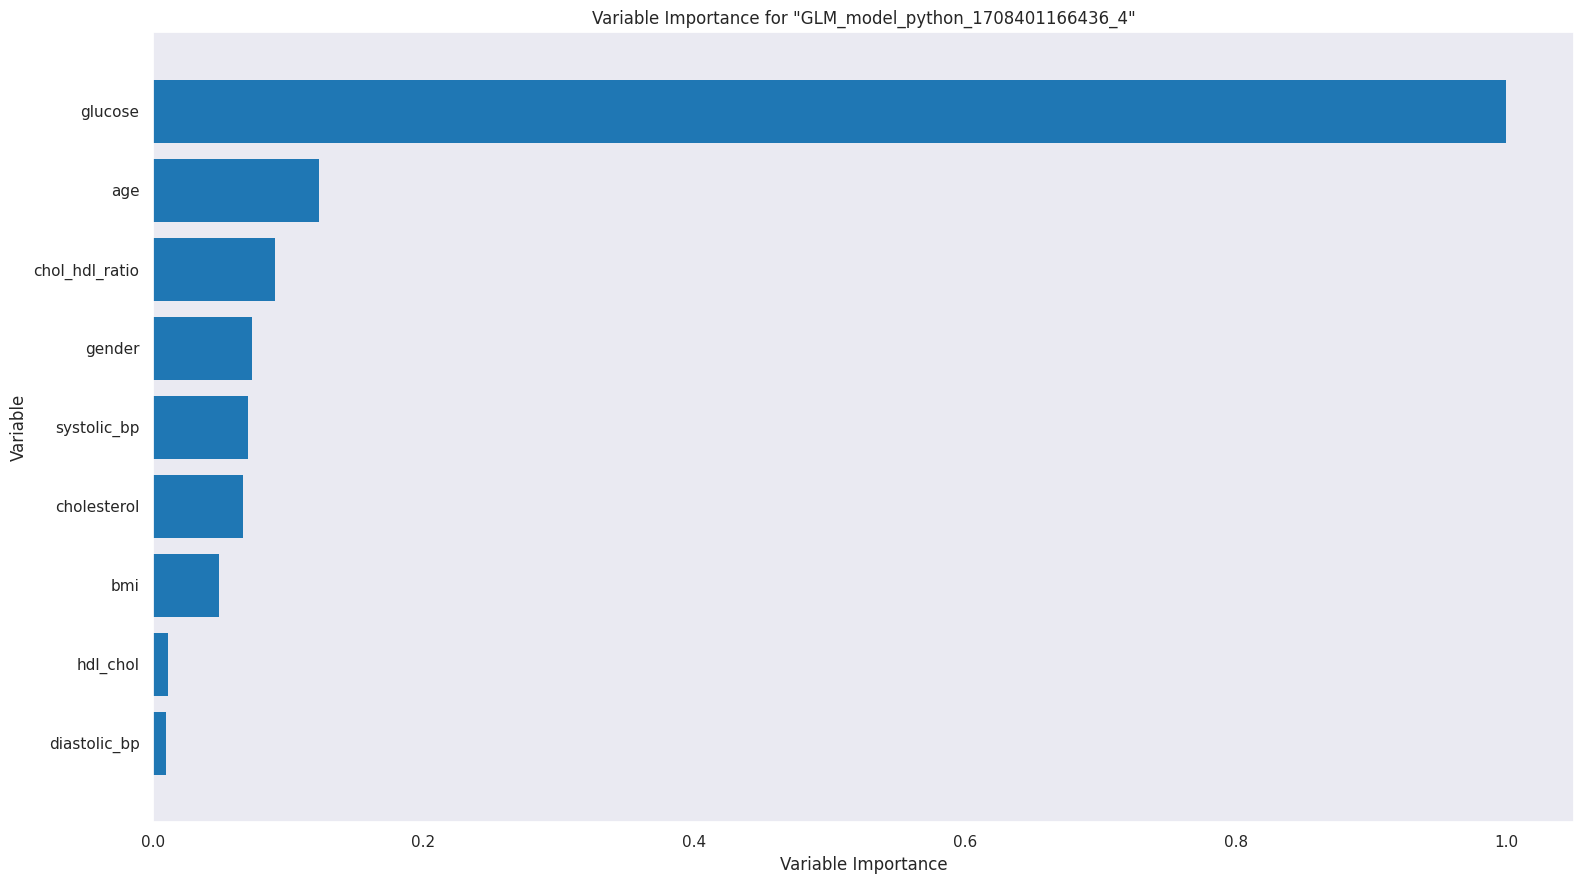

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

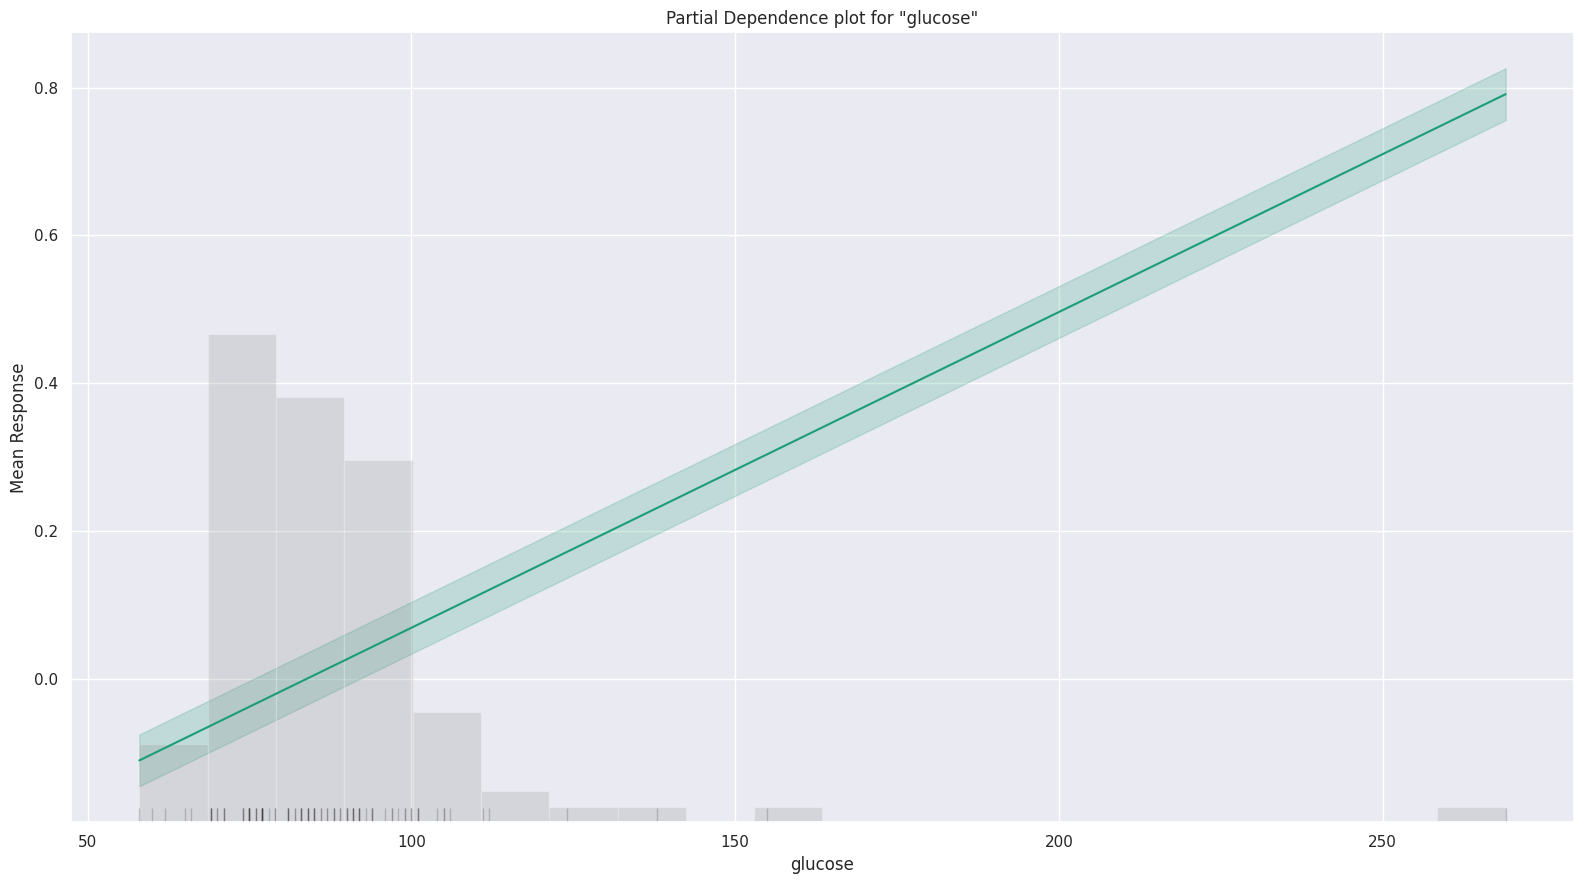

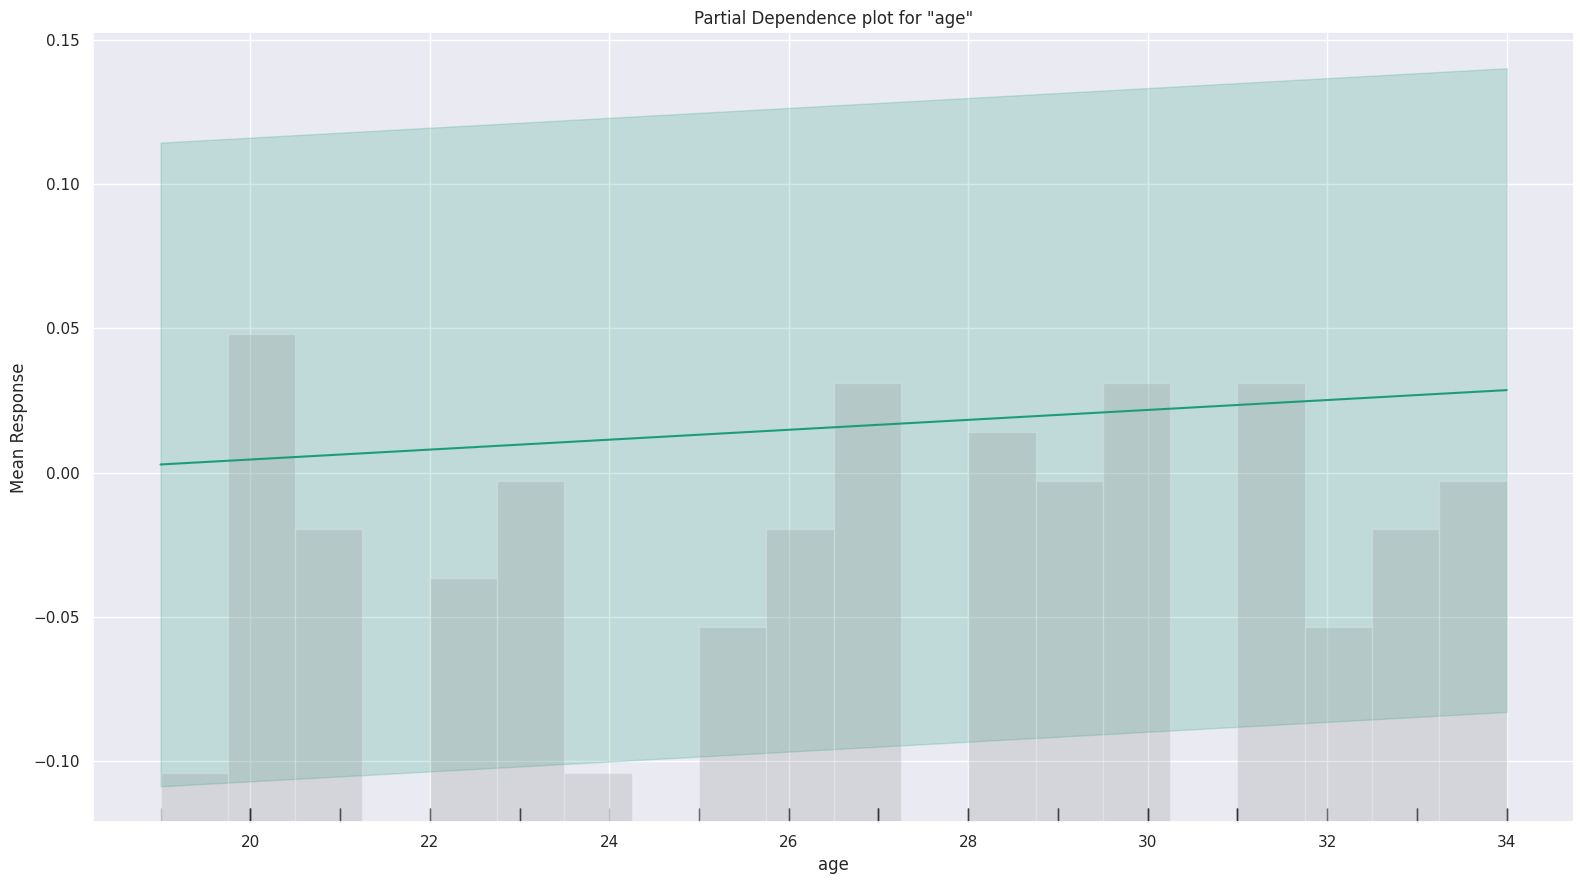

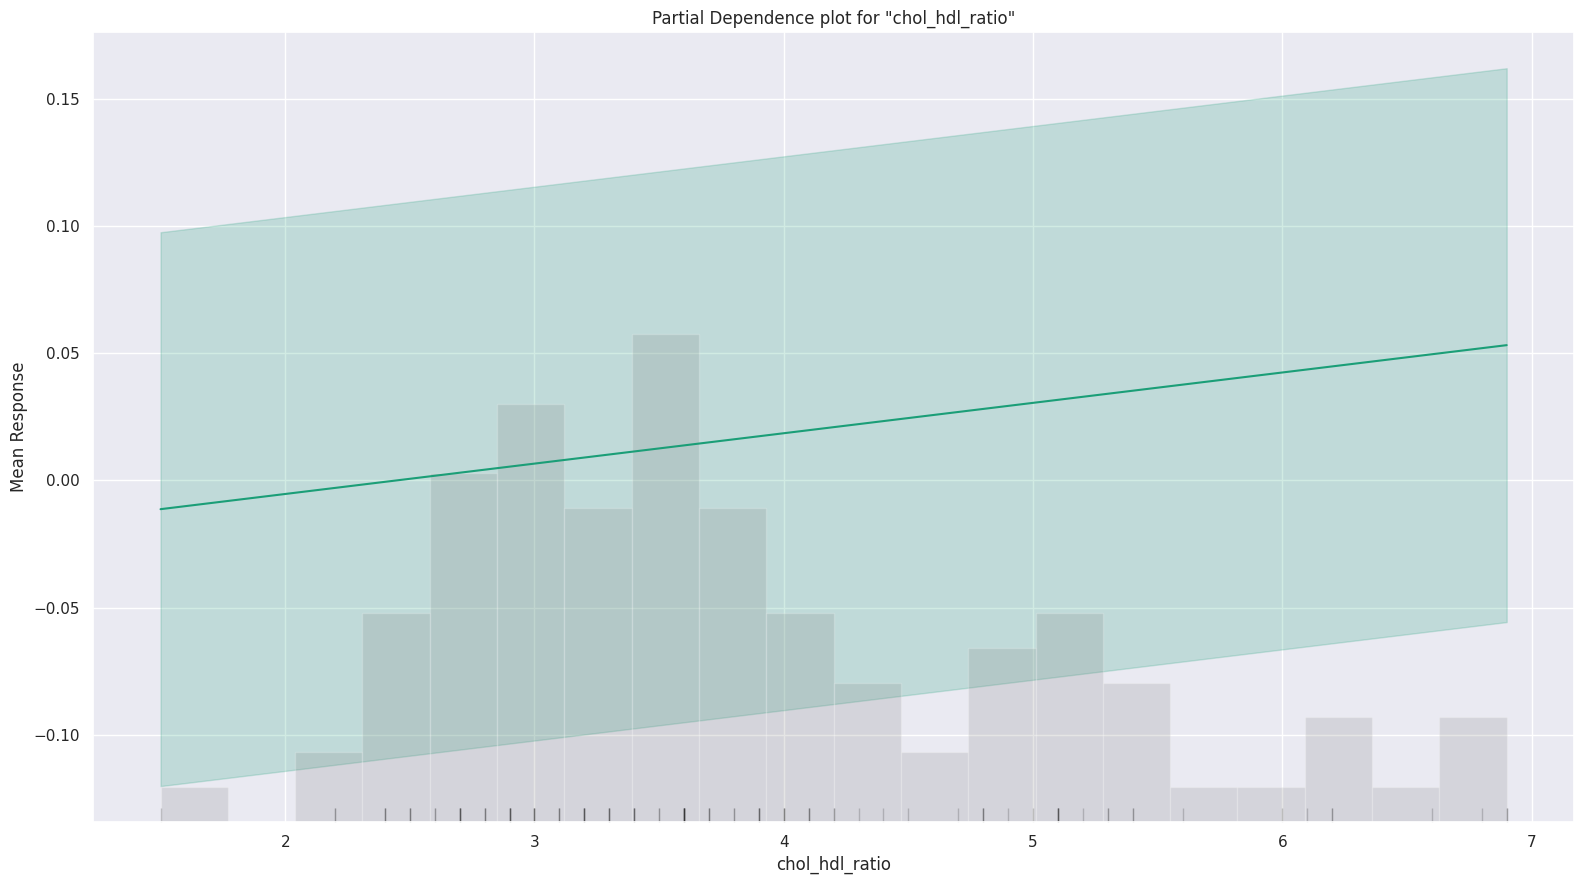

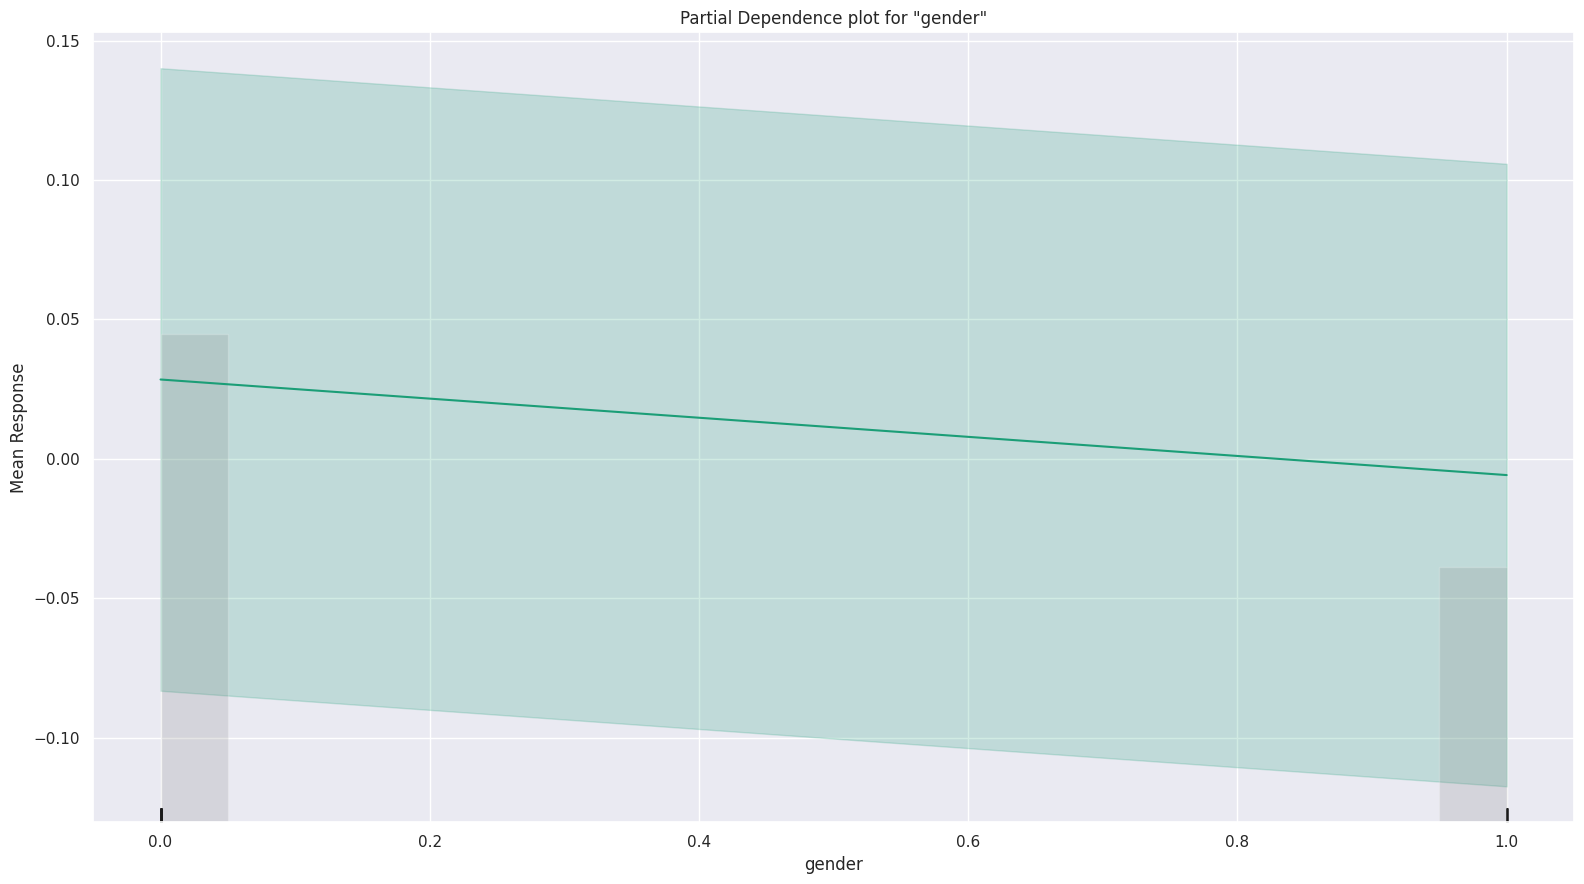

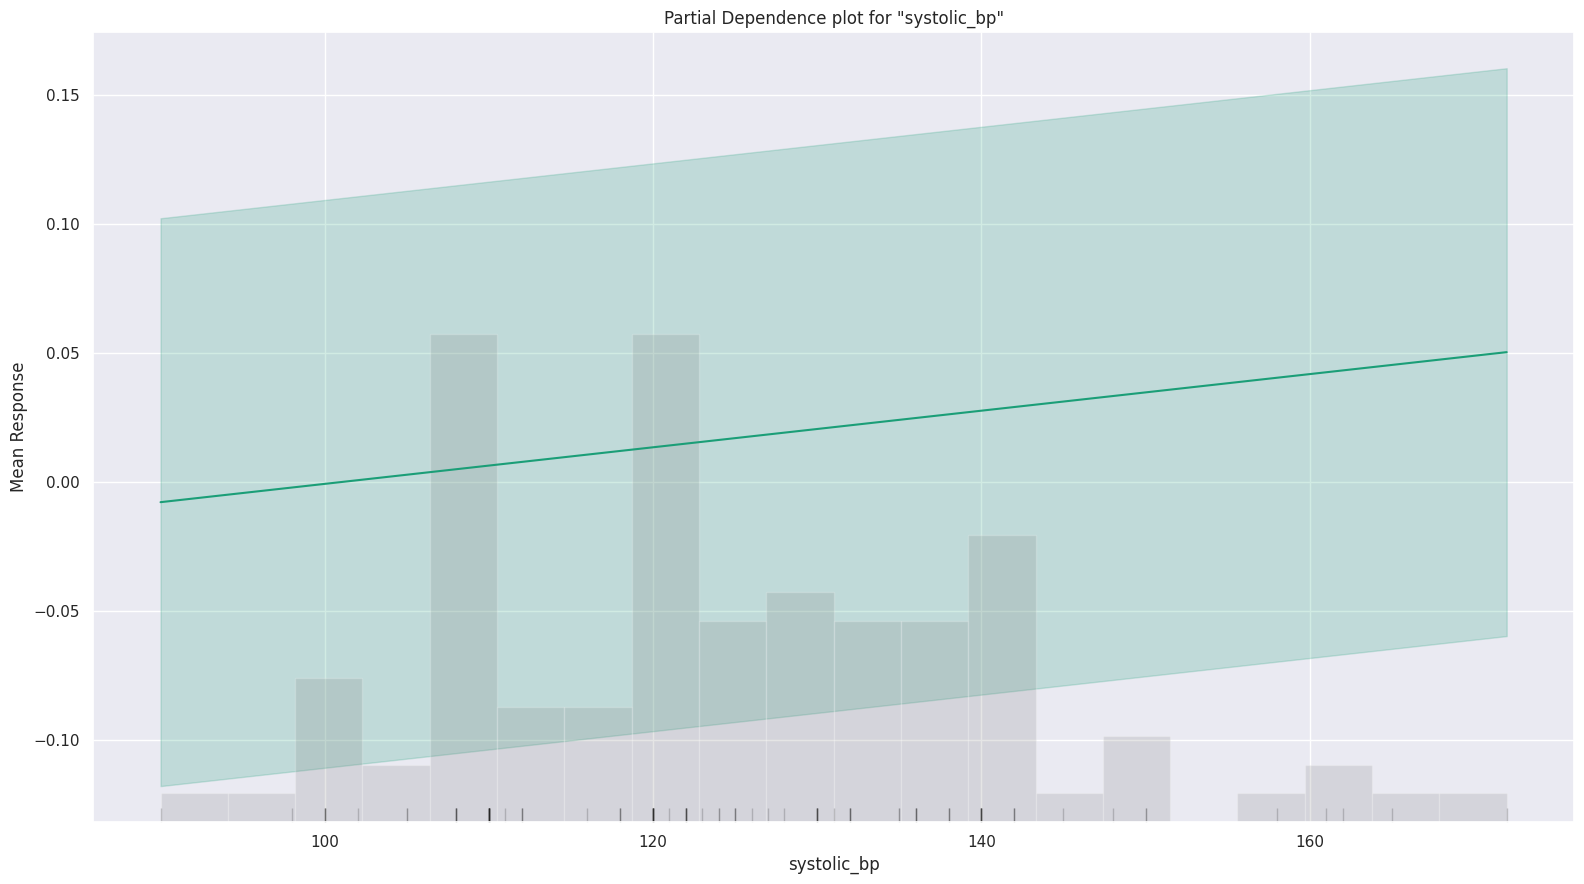

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

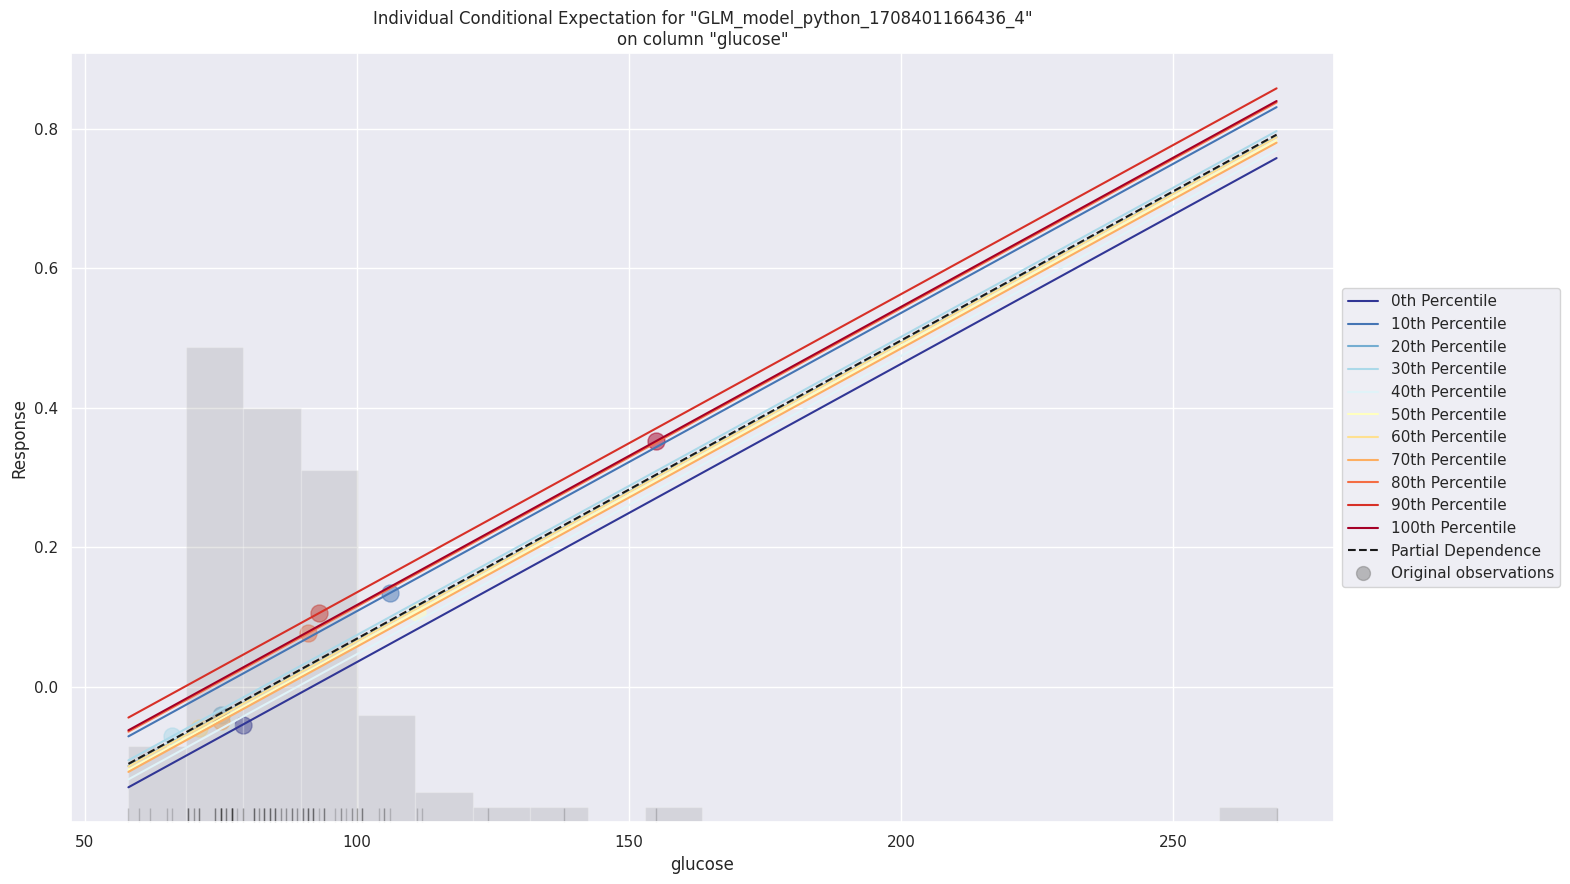

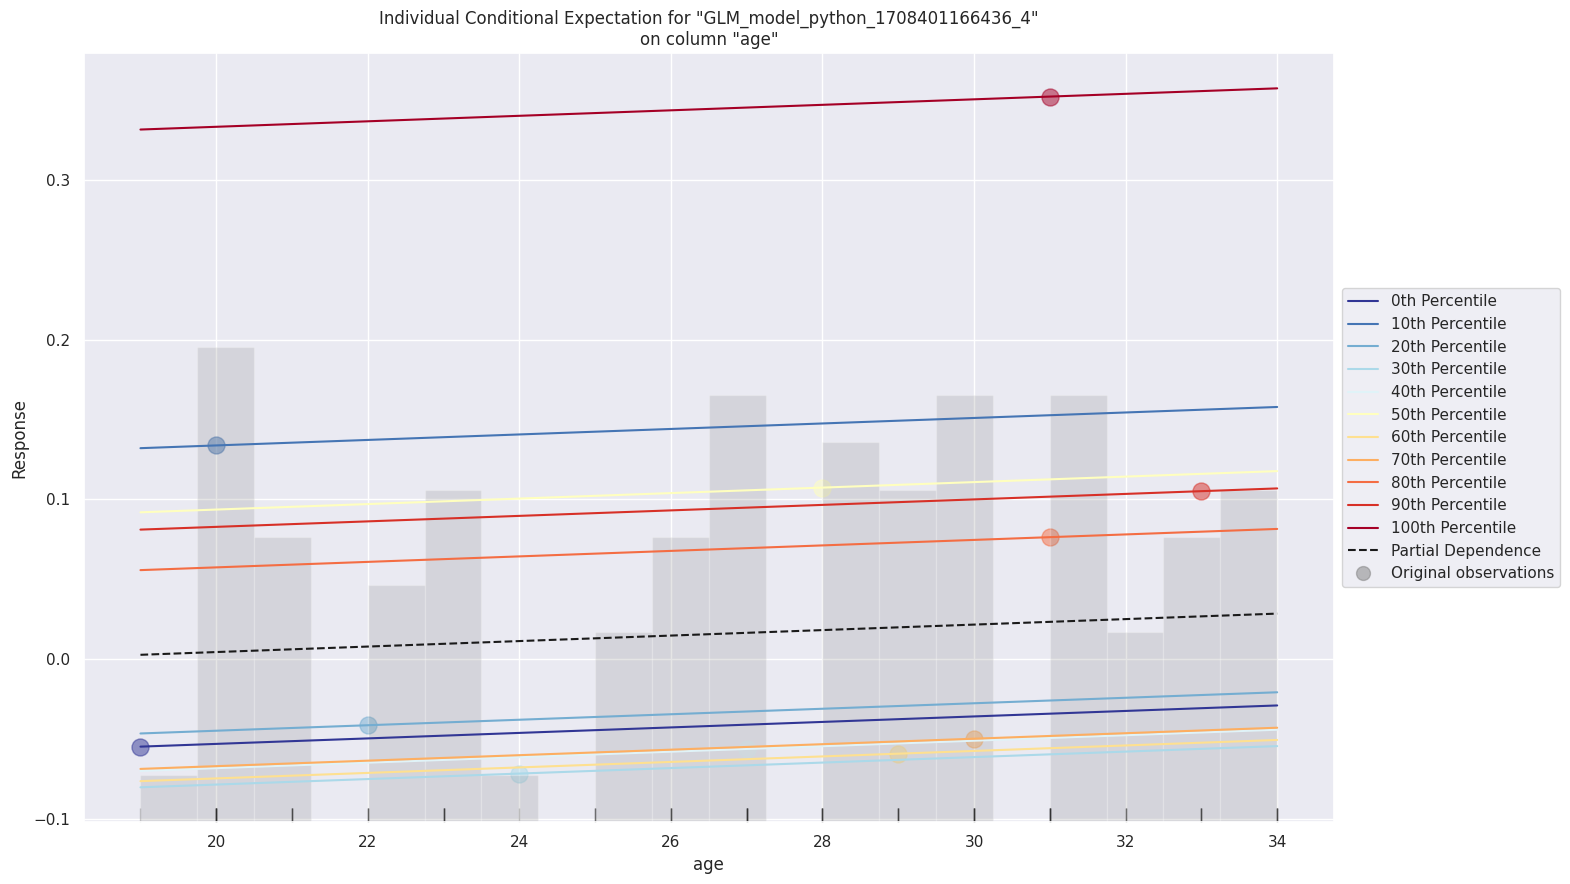

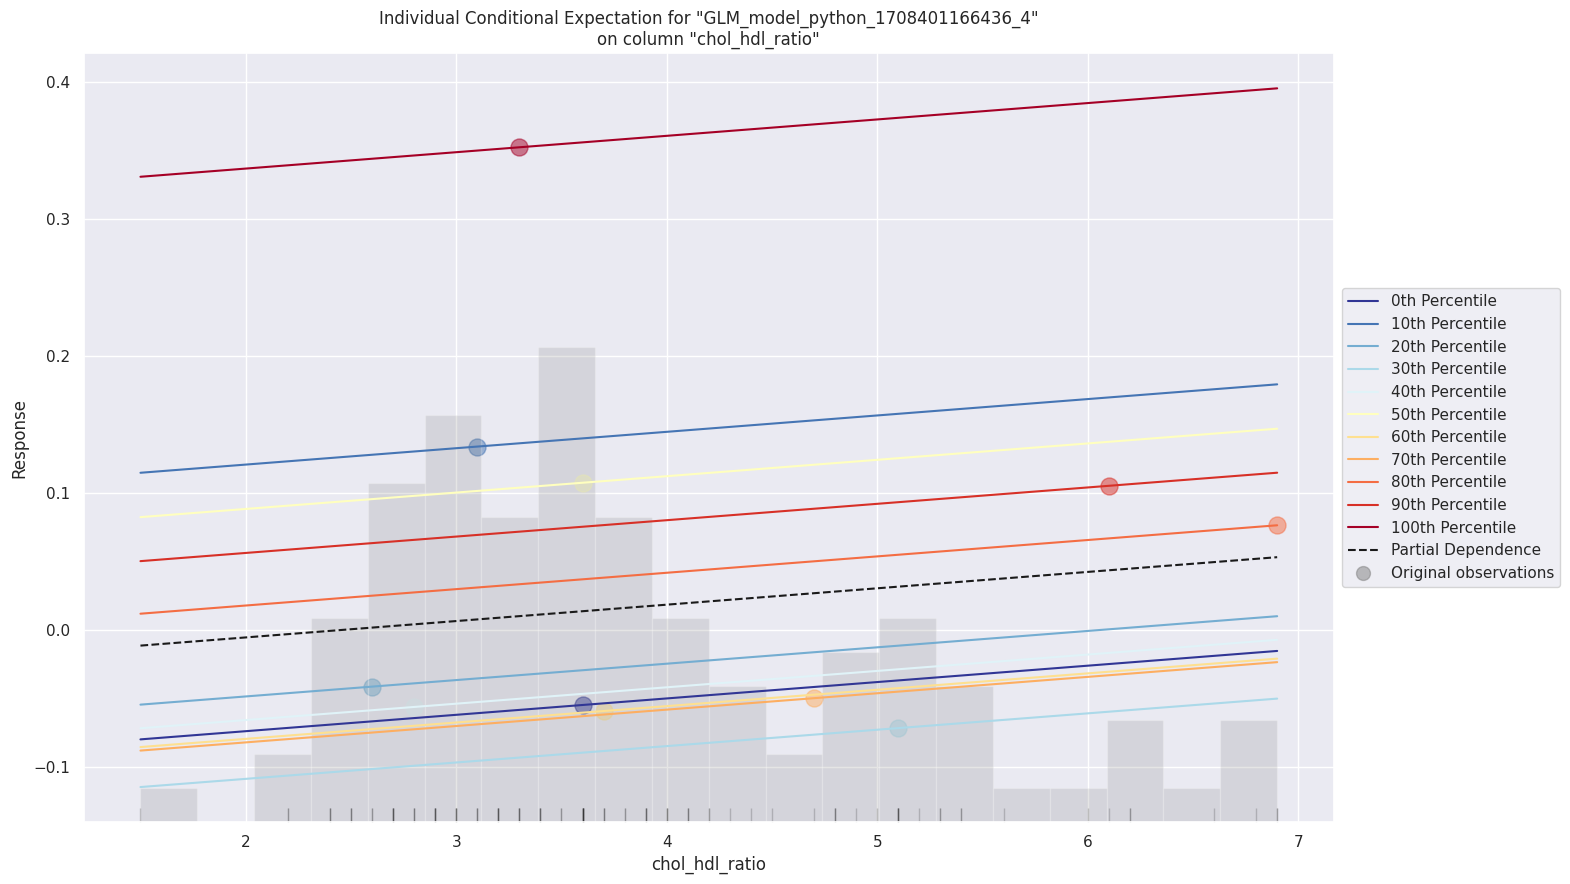

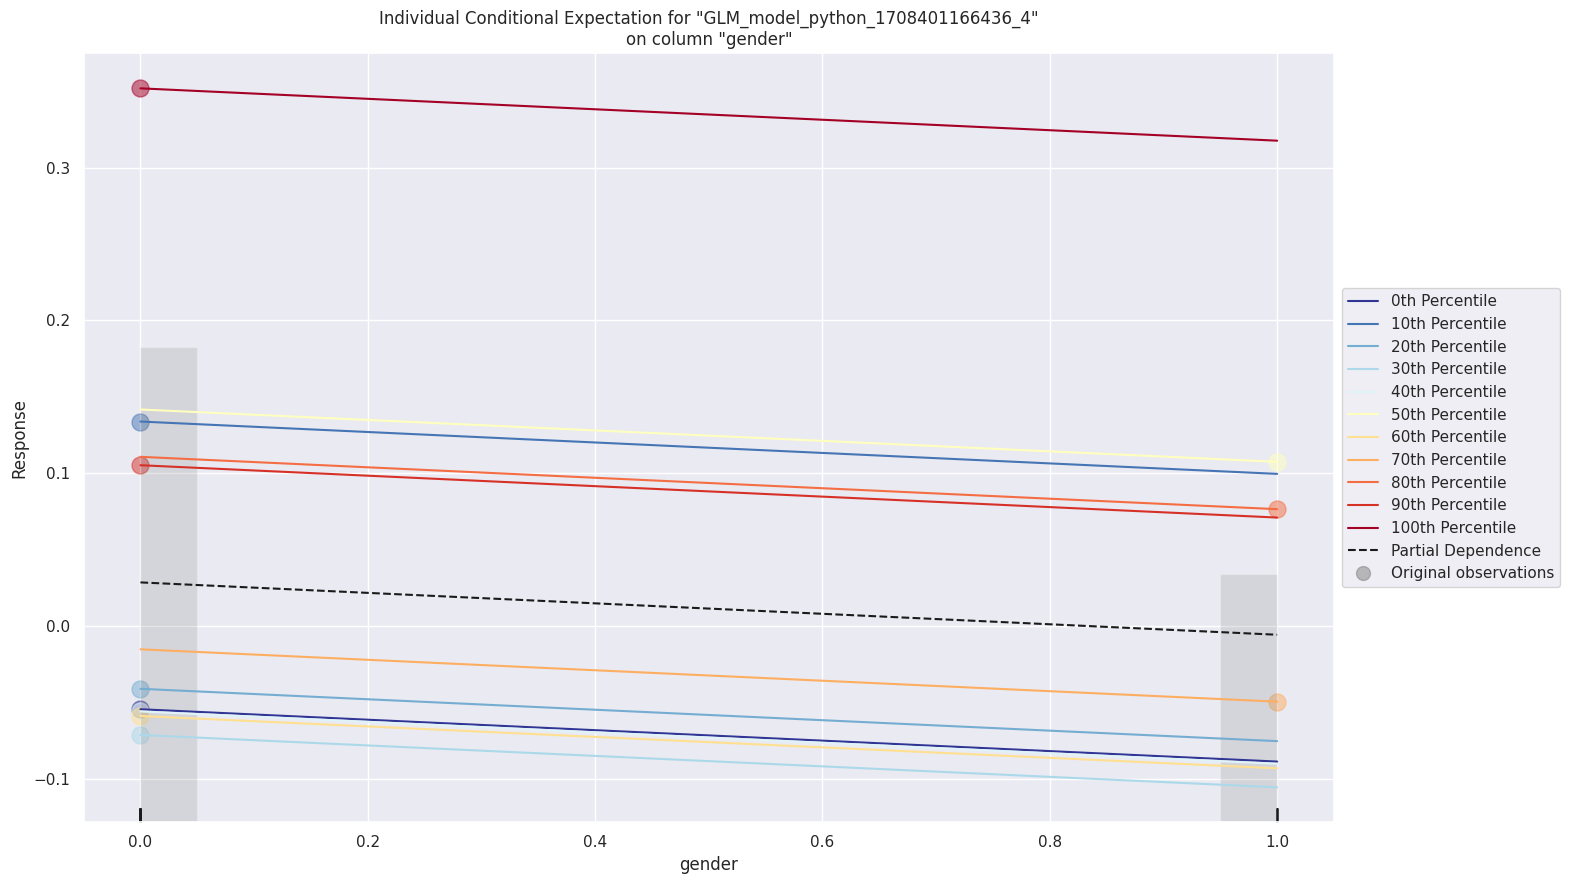

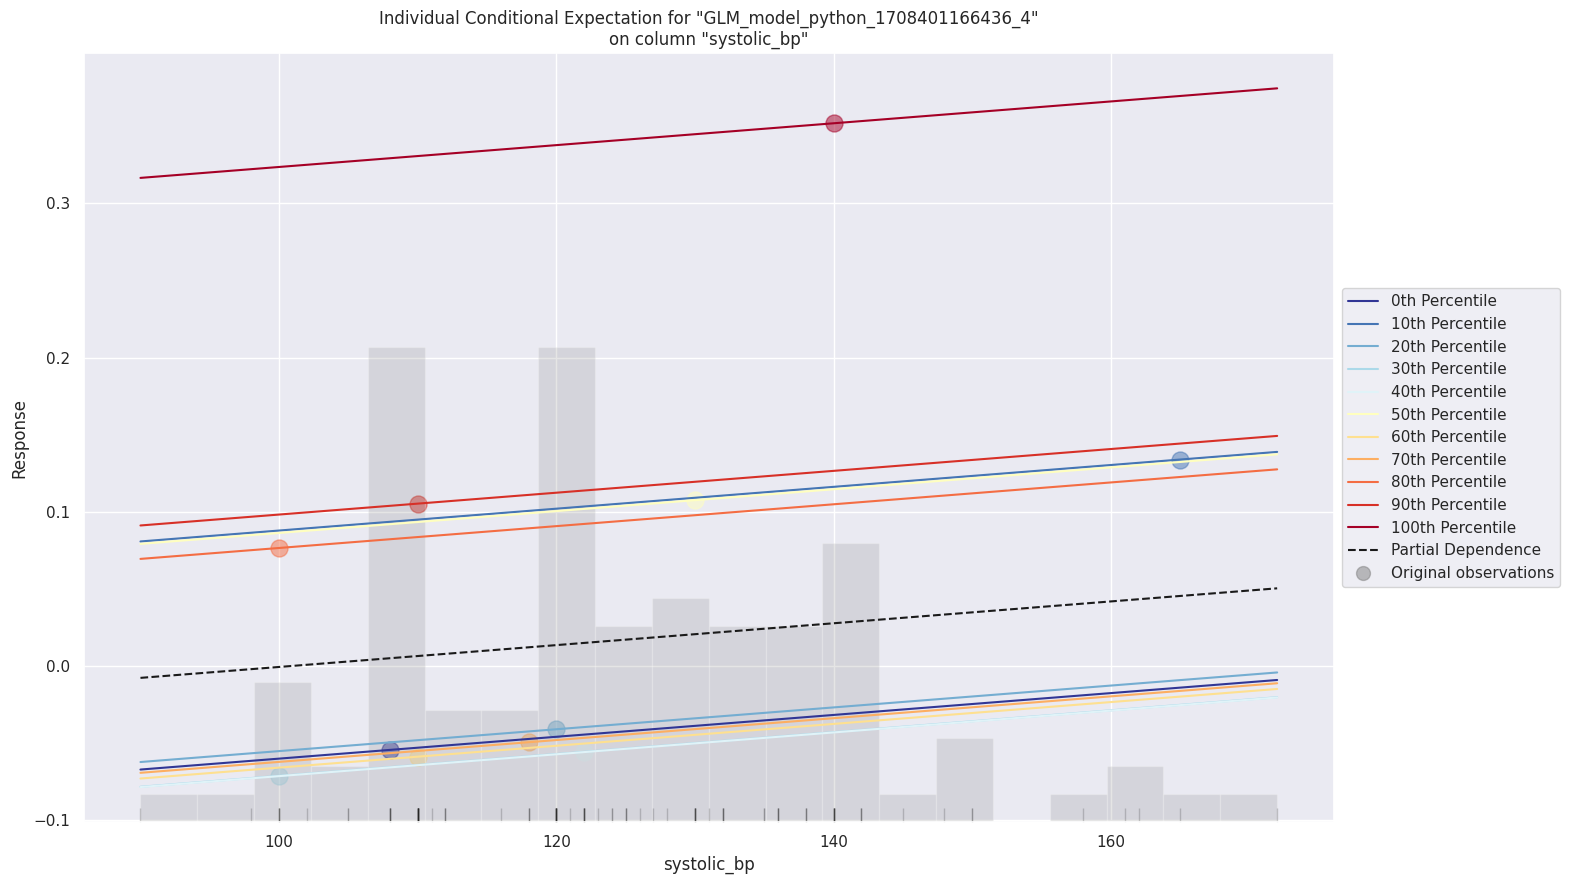

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

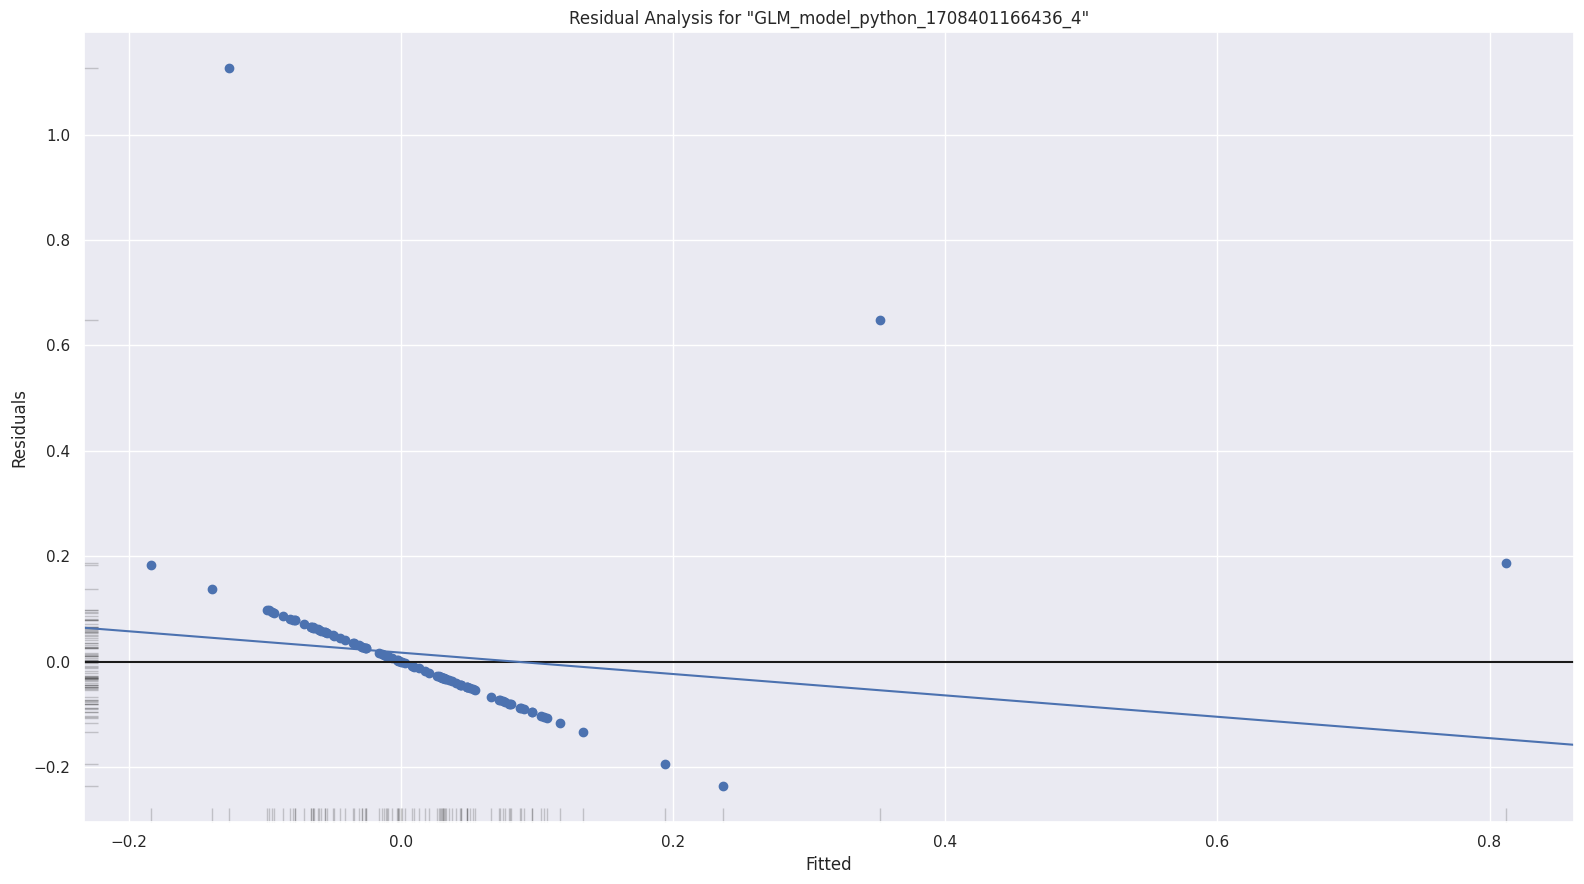

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

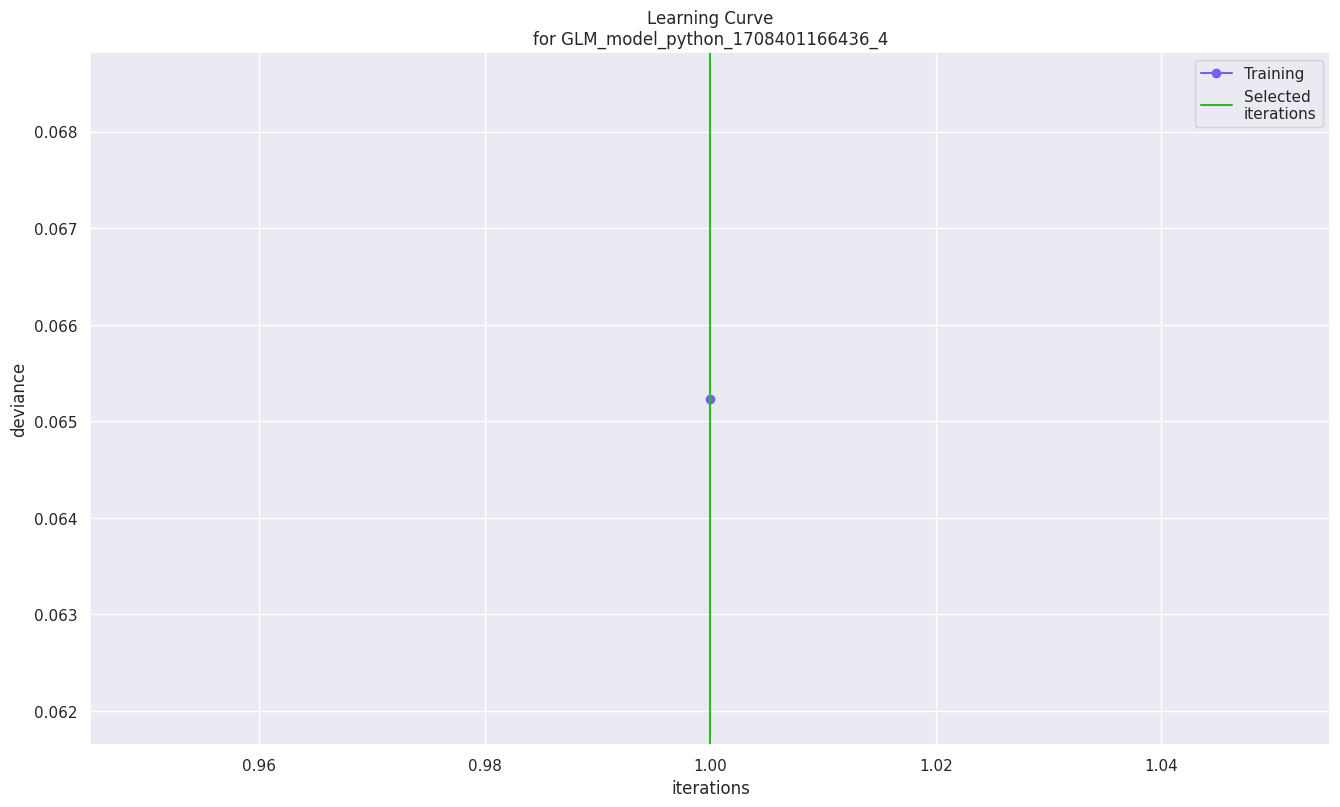

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

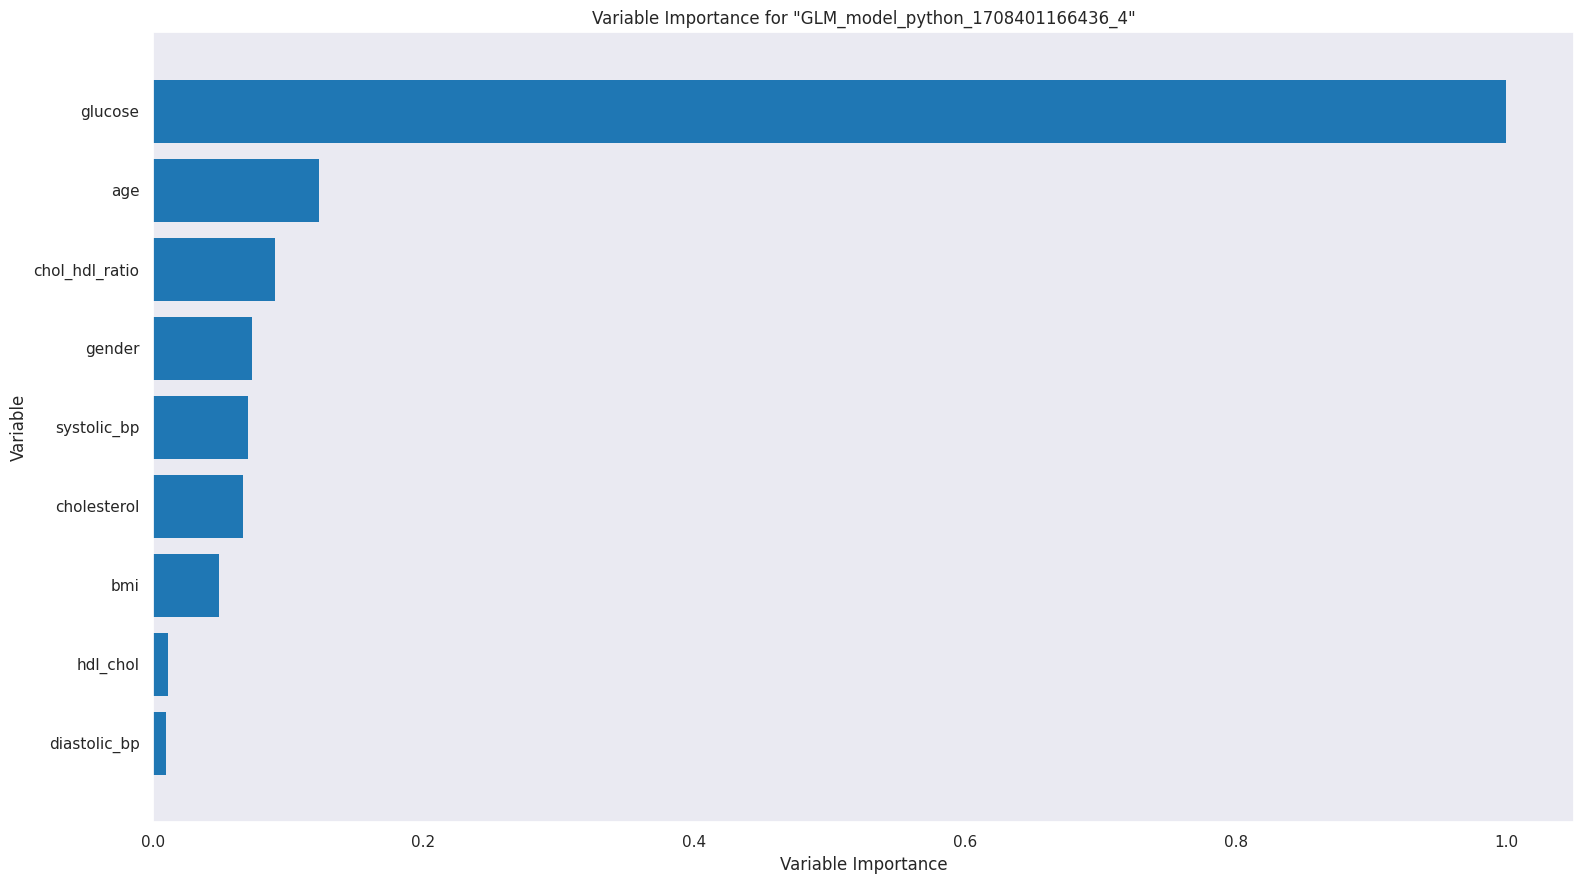

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

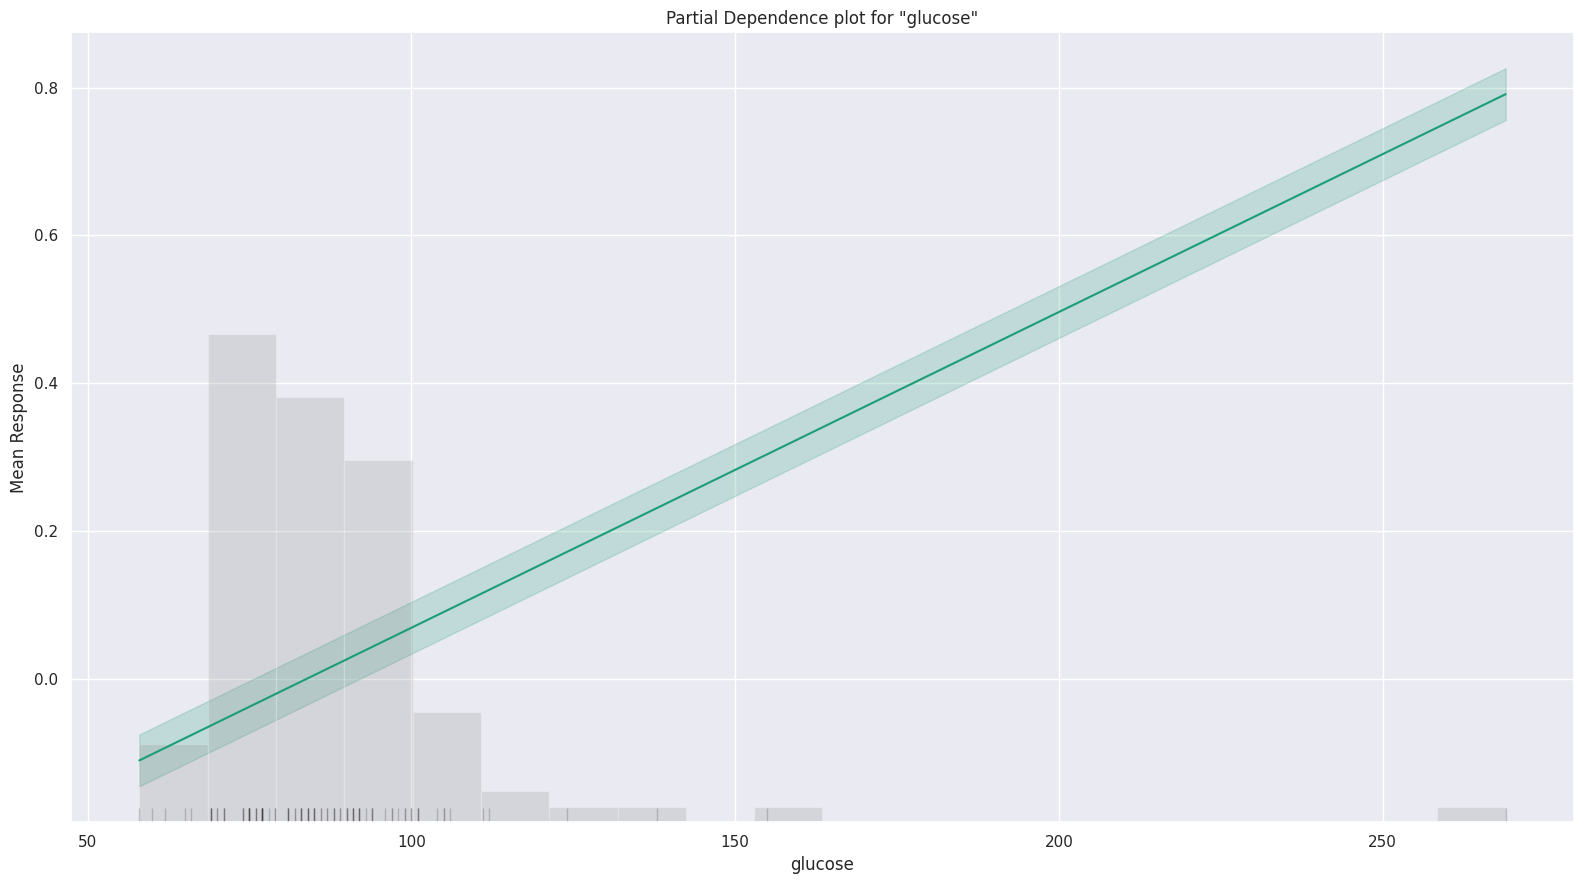

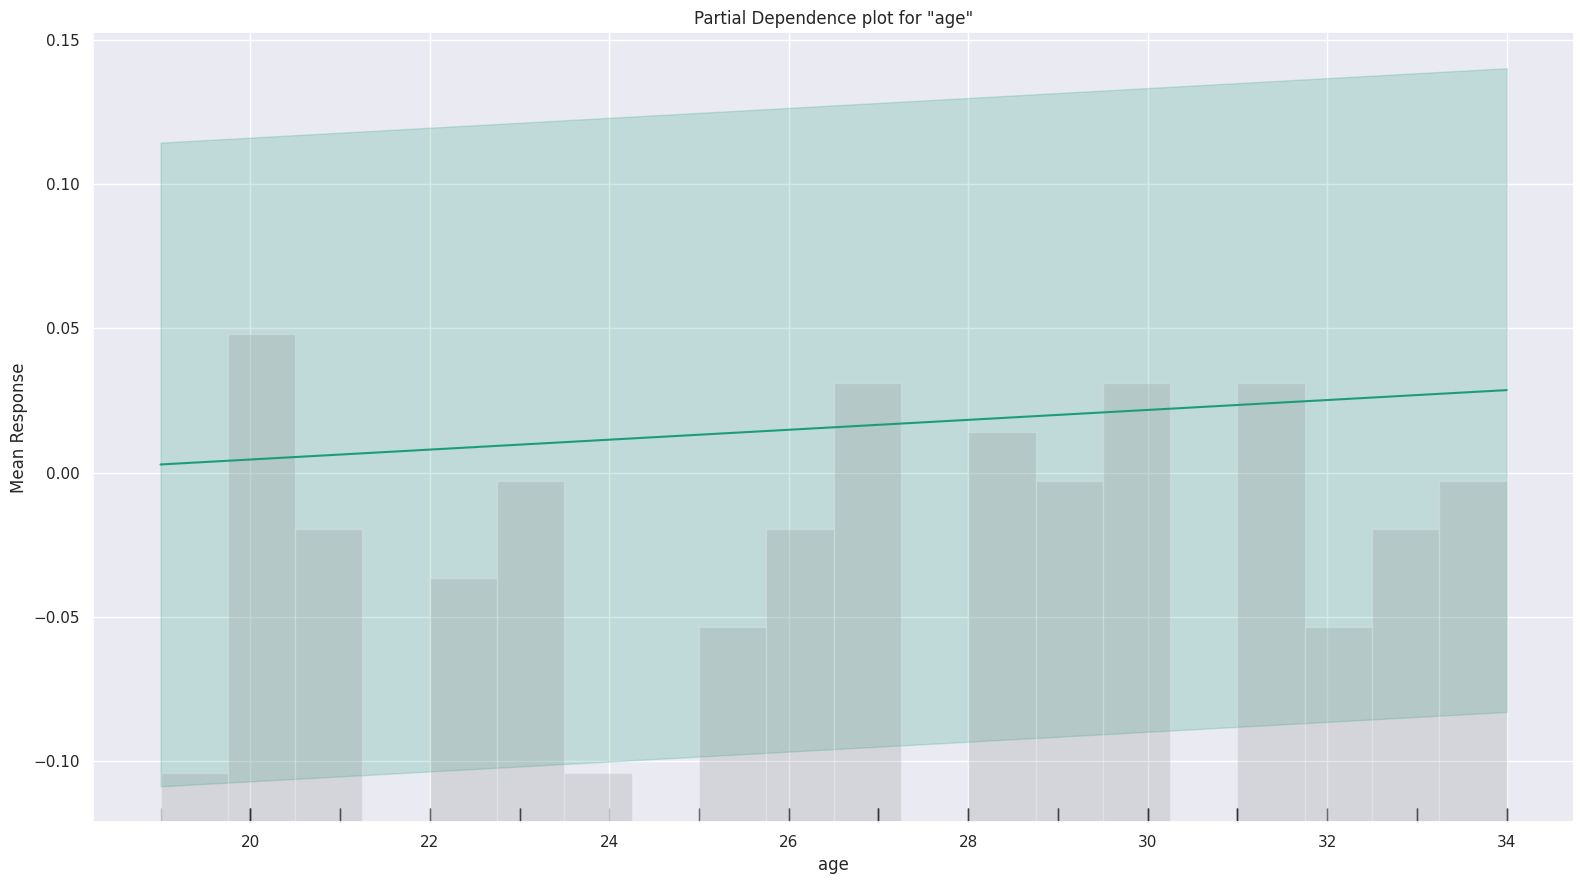

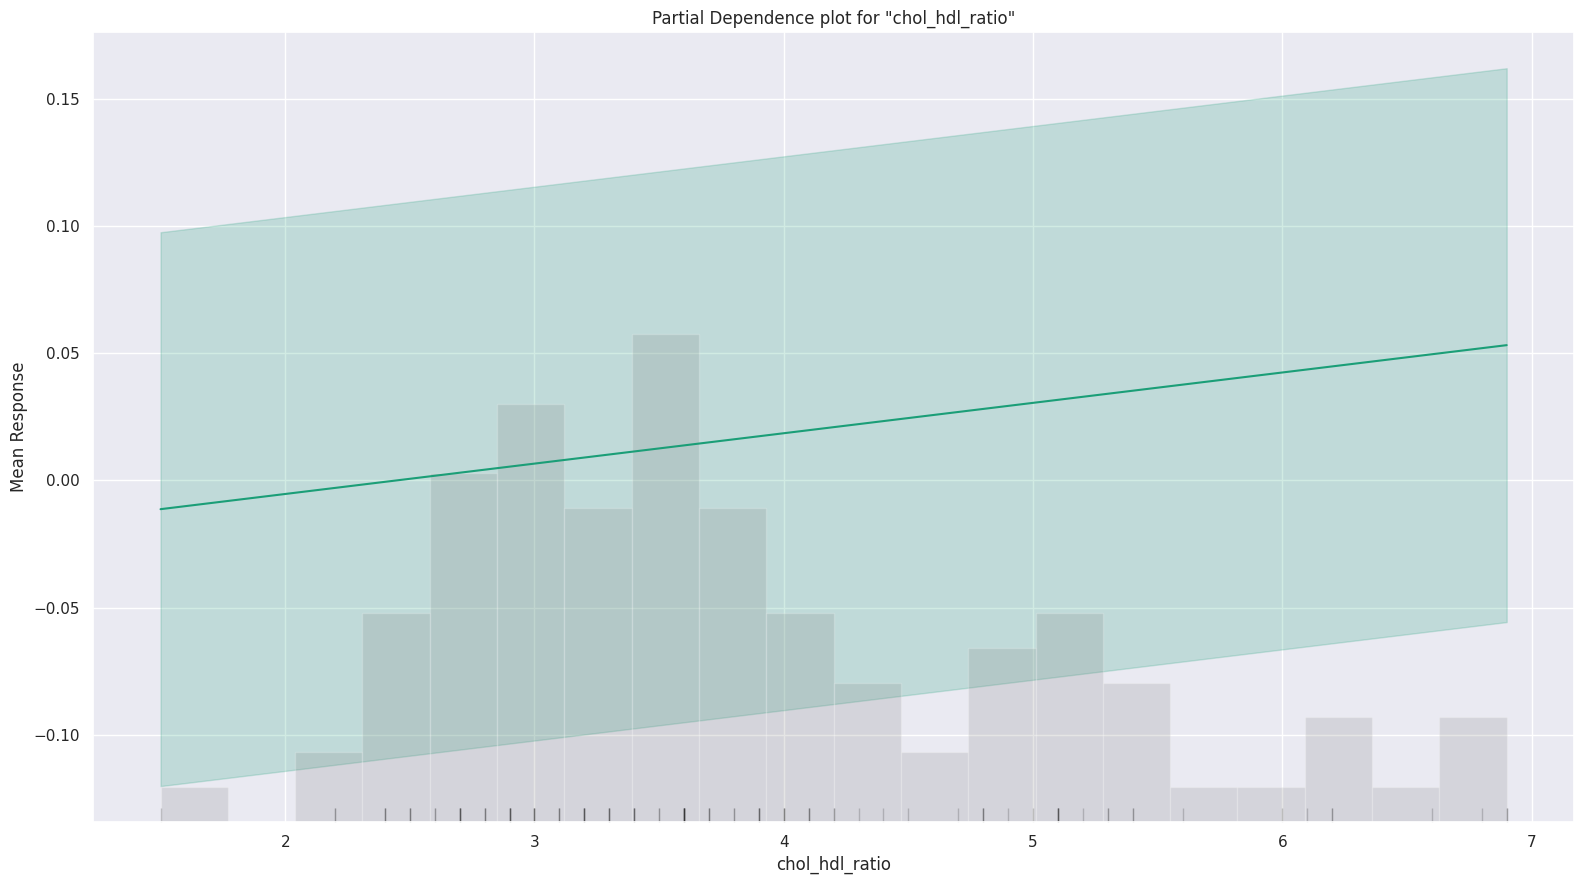

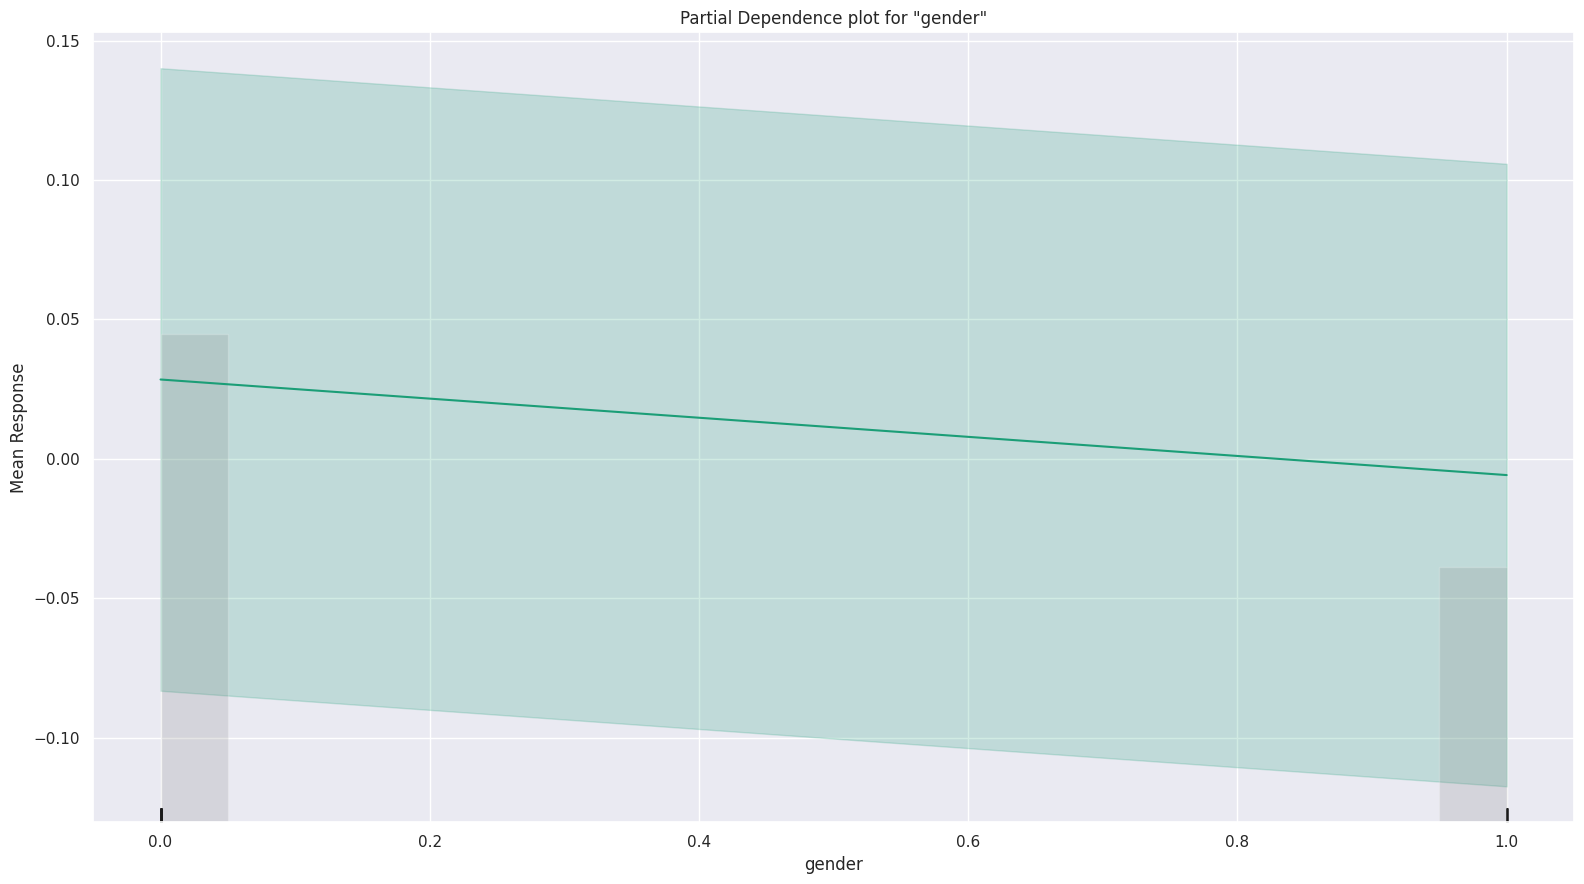

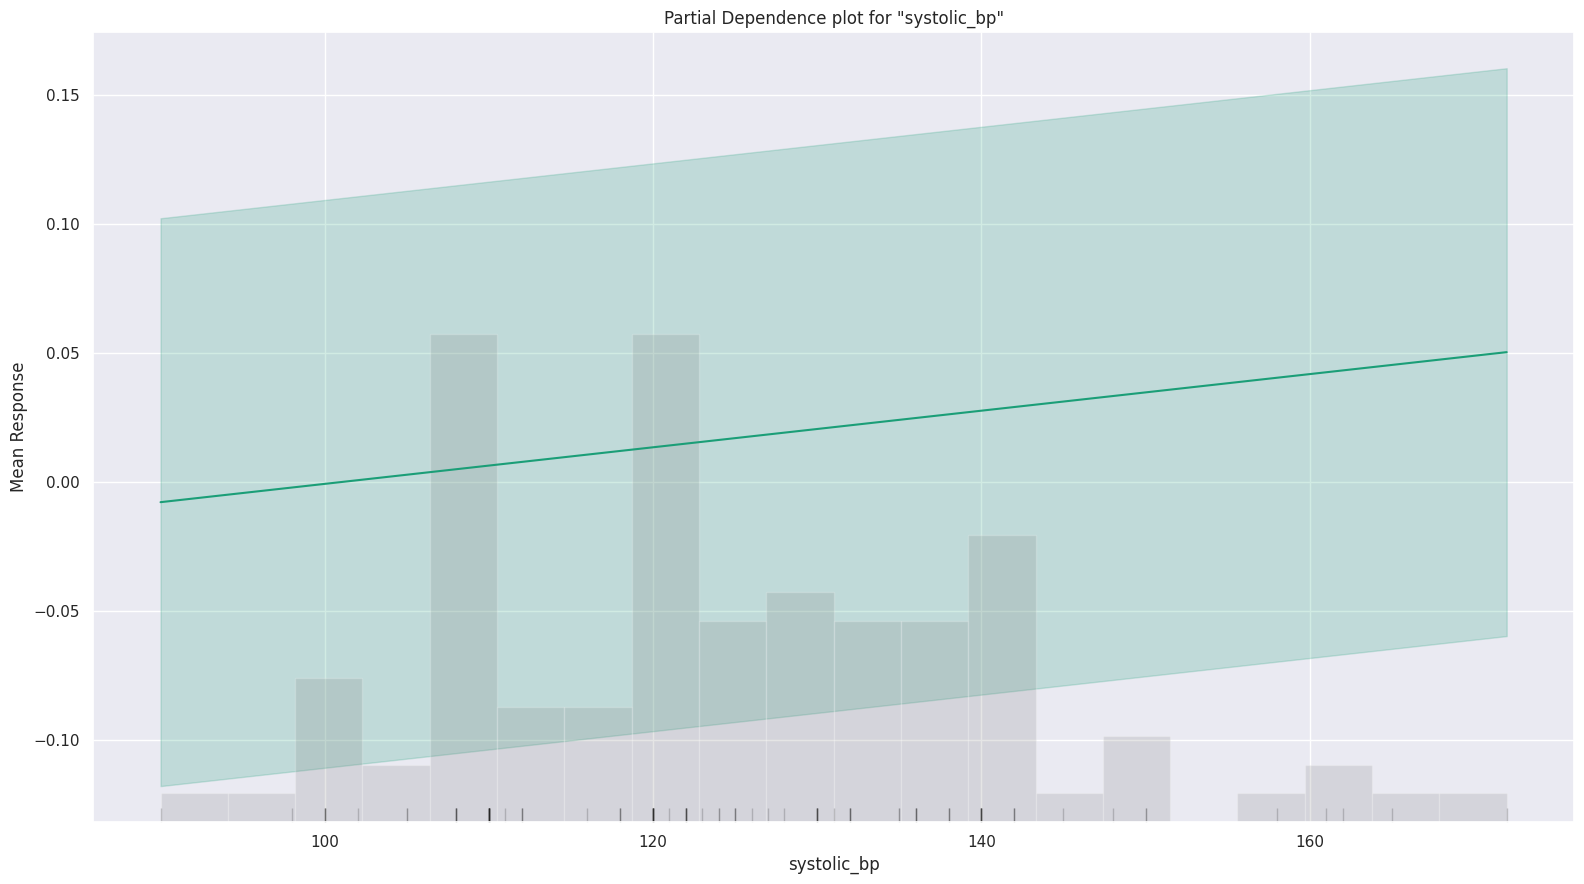

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

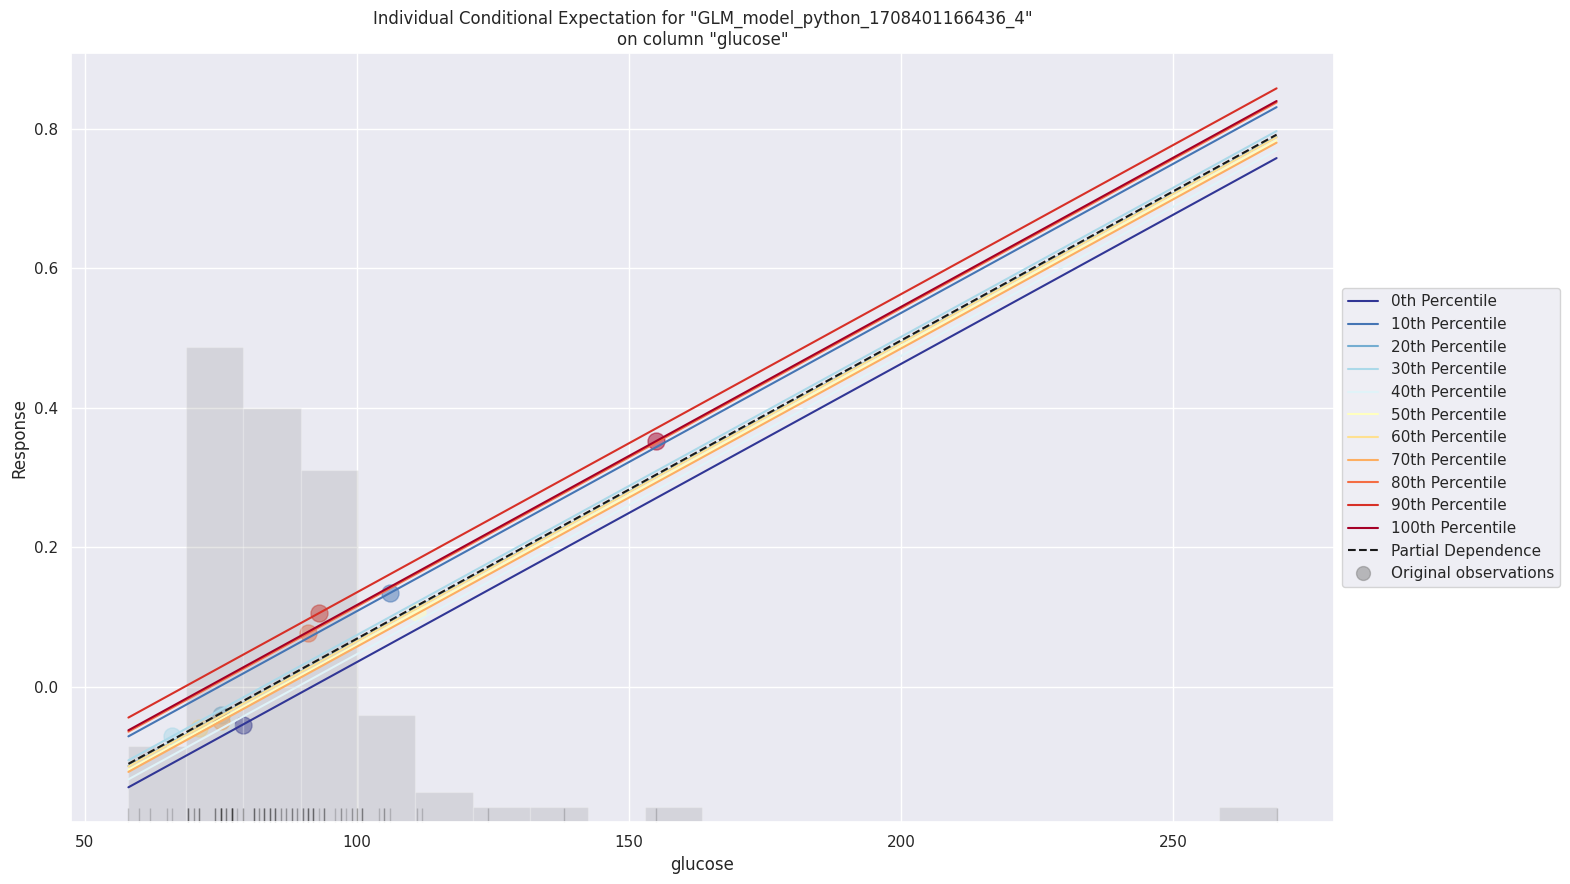

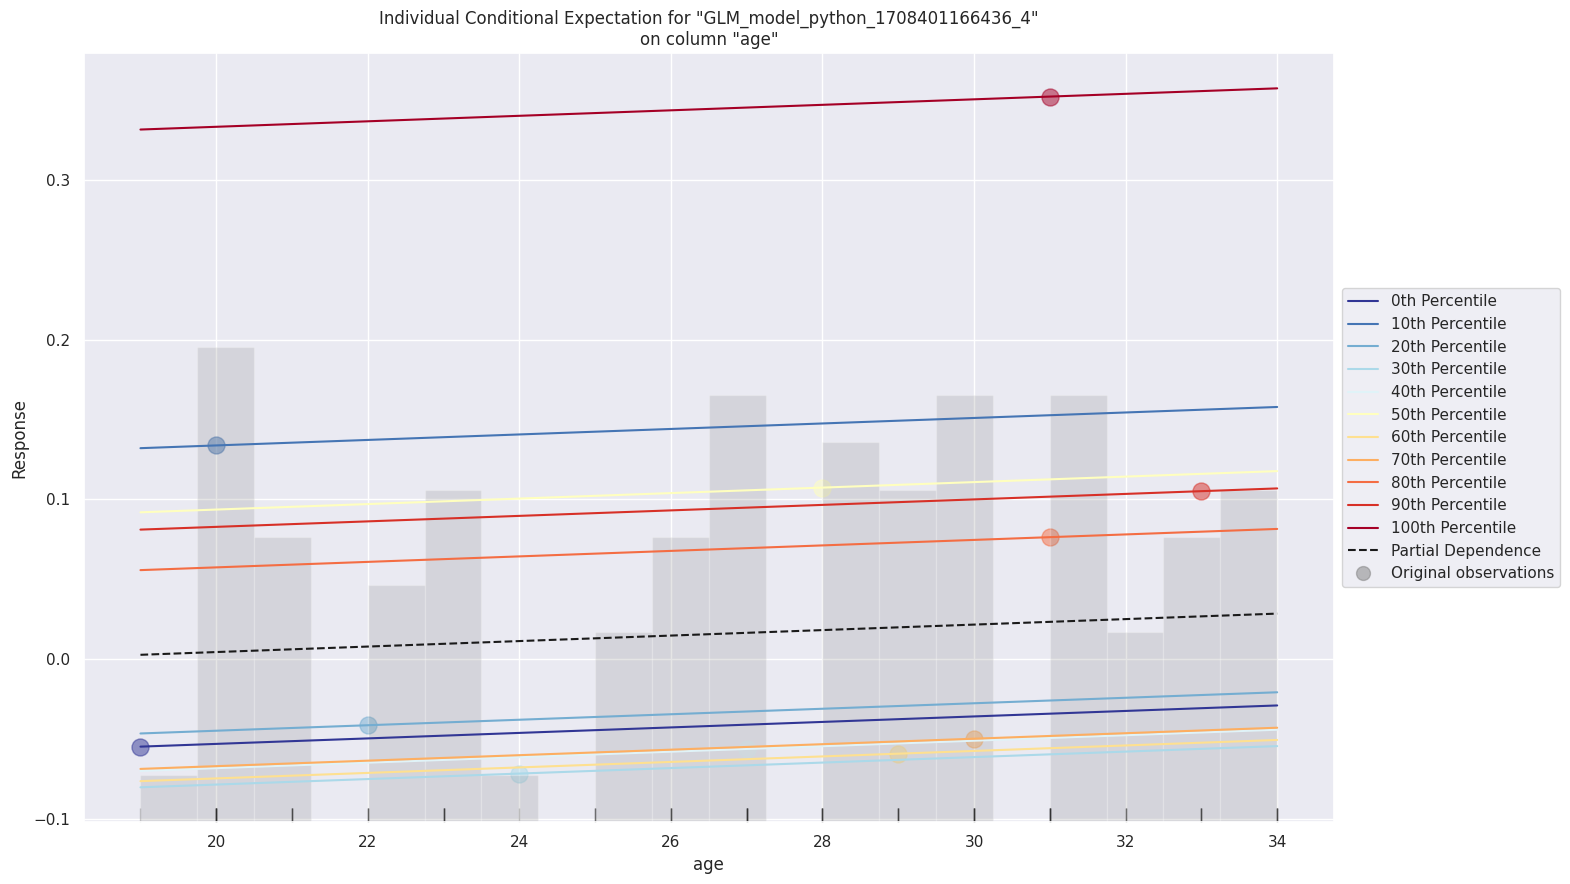

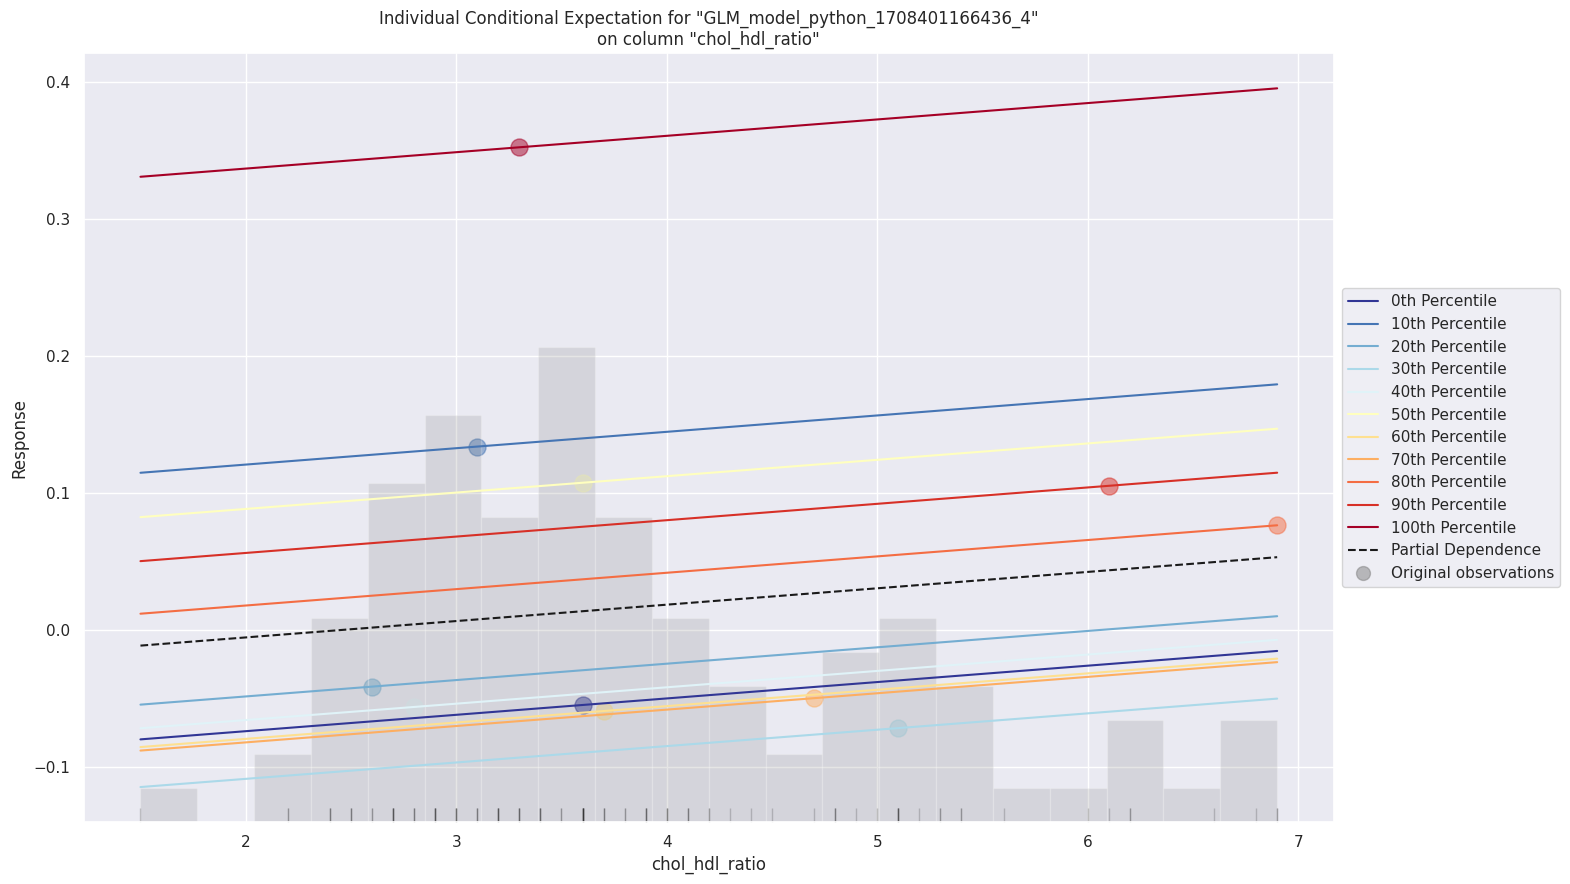

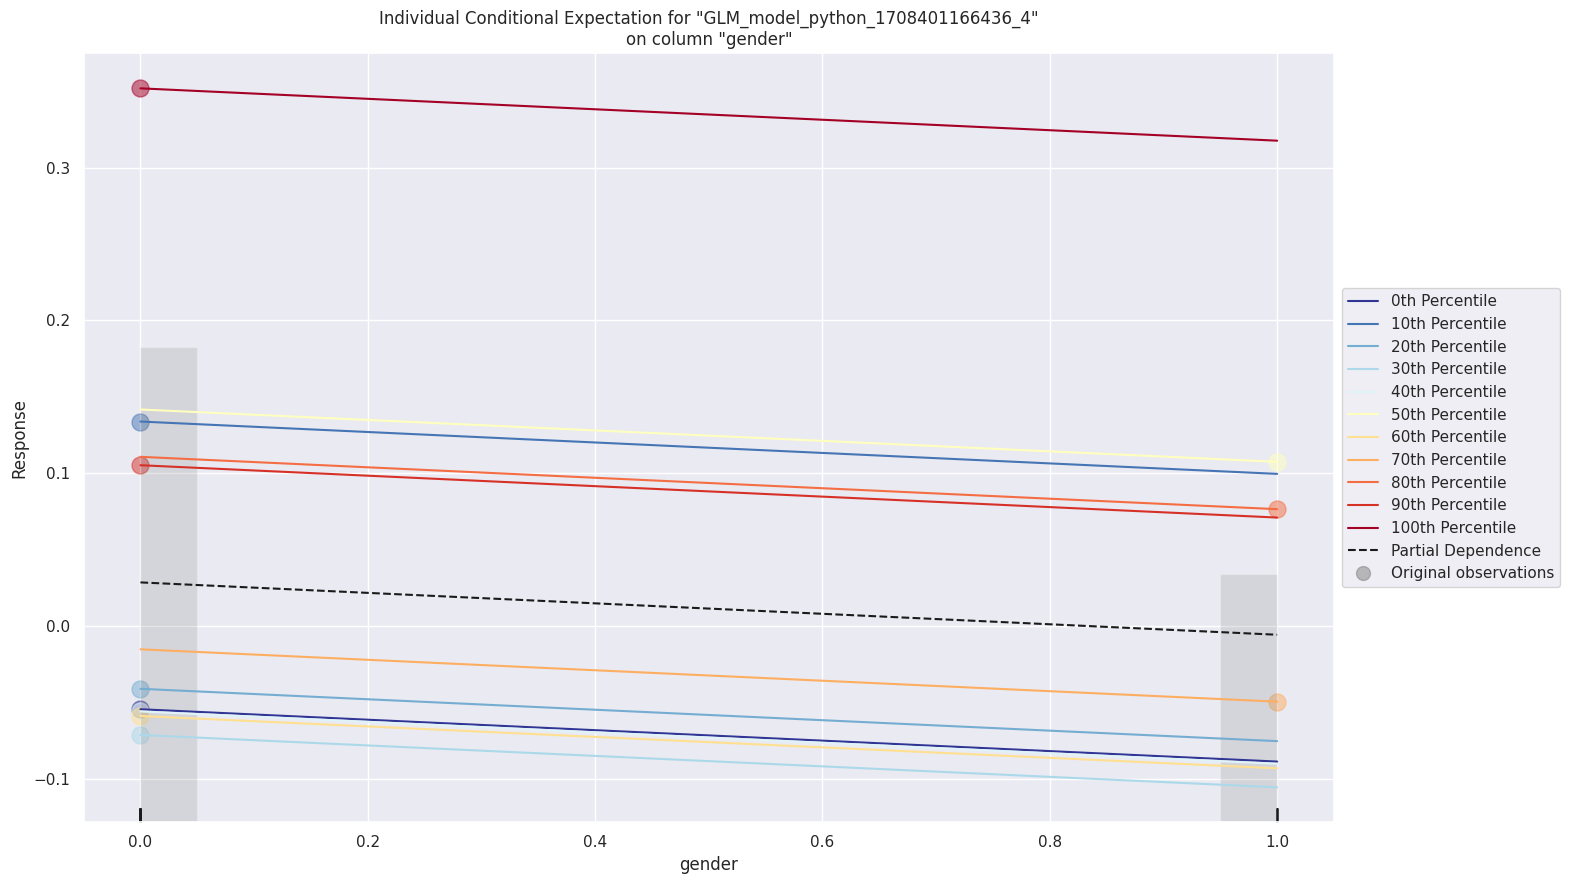

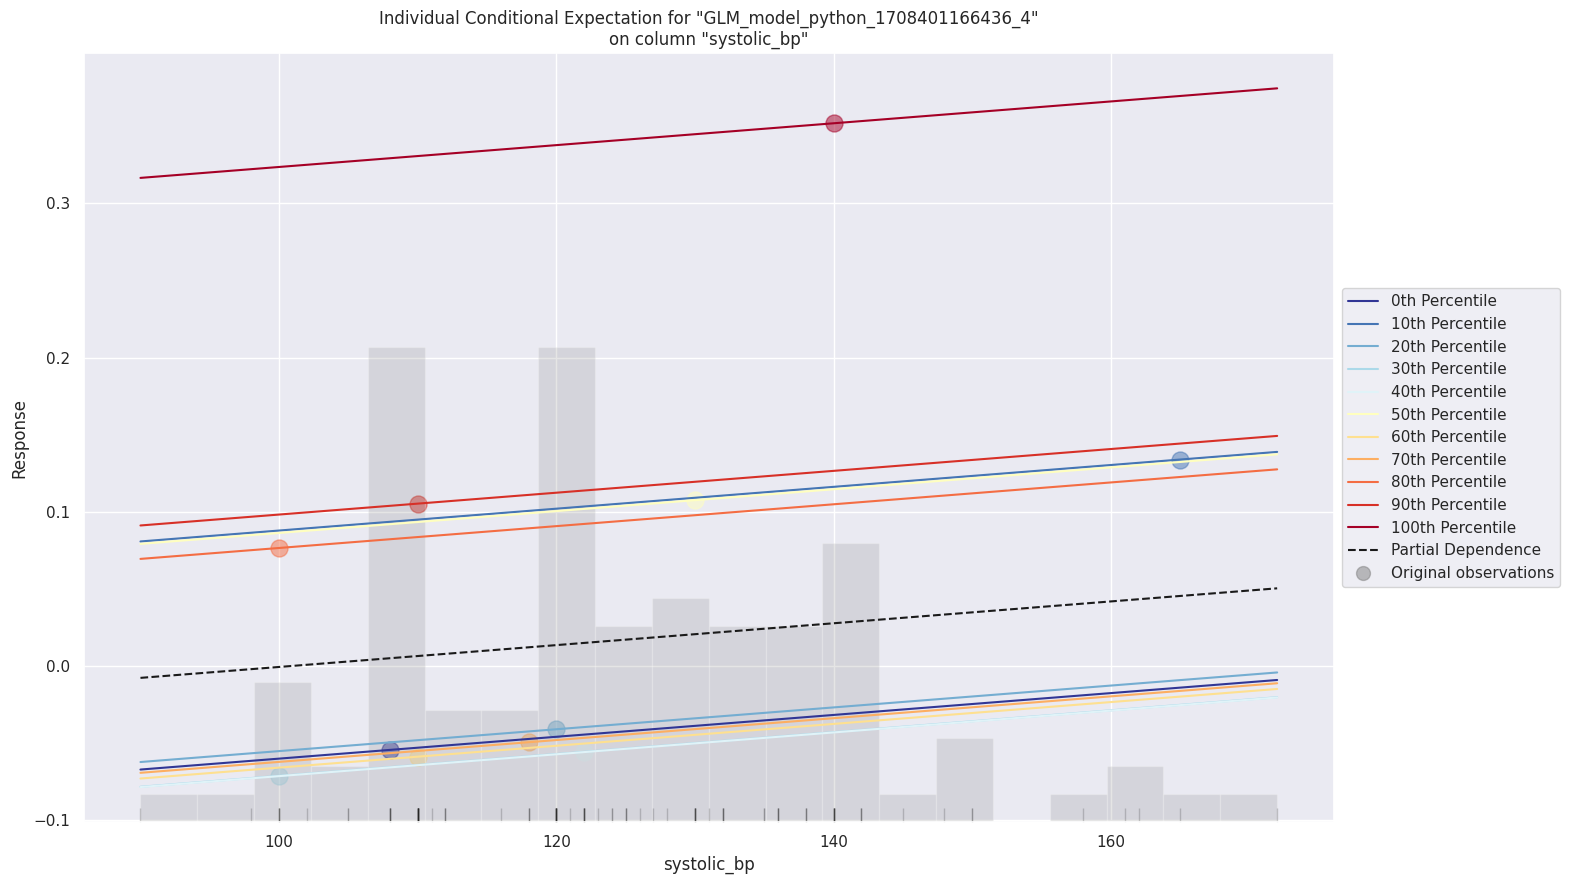

In [57]:
import h2o

# Initialize a H2O cluster
h2o.init()

# Explain the model
data_glm.explain(df_train[1:100,:])

#Conclusion:

In this assignment, I employed the H2O.ai AutoML library to develop predictive models to predict diabetes occurrence in patients using data from the National Institute of Diabetes and Digestive and Kidney Diseases. My focus was on identifying significant relationships within the data and building robust multivariate models for analysis. While assuming the data's quality for this phase.
Throughout the process, I examined key aspects such as the significance of relationships, adherence to model assumptions, the presence of multicollinearity, and the independence of predictor variables. Furthermore, I evaluated the influence of regularization and the significance of independent variables and hyperparameters in the models.

The primary goal was to establish an effective  model for predicting  diabetes, with a focus on identifying the most influential factors driving the occurrence of diabetes. Moving forward, I aim to prioritize comprehensive data cleaning and feature engineering to ensure the models accurately reflect the underlying data patterns, providing reliable insights for predicting diabetes

#REFERENCES

H2O Documentation https://docs.h2o.ai/haic-documentation/ official documentation for H2O, an open-source machine learning platform.

Towards Data Science Article https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/ Article discussing the automation of machine learning processes using H2O.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.htmlhtml#documentation Official documentation for the lassoRegression in scikit-learn.

#License:

Copyright (c) 2024 Ronak Mishra

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



